###### Notebook for pickling Rapa4 CD1d data Peptides - only include H1N1 California/07/2009, H3N2 X31 and H5N1 viet1203 HA or NA peptides
### Can generate pickle files for both IgG and IgM but needs to be run twice, once for each isotype.
#### Data is pickled into a file that allows loading multiple datasets for comparisions etc.
##### October 2021


In [272]:
%load_ext autoreload
%autoreload
%matplotlib inline
from scipy import io
import pandas as pd
import numpy as np
import sys 
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import glob
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as distance
import statsmodels.api as sm
from sklearn import metrics
import seaborn as sns
import getpass
import os
import matplotlib
import re       # regular expressions
from itertools import chain
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project specific parameters that must be set:

### The user needs to select the following:

0. mac/linux/lab/home flag
1. project name
2. antibody isotype


In [300]:
# 1. select where you are running script:
# needs to be updated using switch?
mac_flag = 0  # 0 for PC users, 1 for MAC users (Tomer)
linux_flag = 0
home_flag = 0
user_name = getpass.getuser() 

# 2. select project name
project_name = 'Rapa4'

# 3. antibody subtypes (list - currently each isotype is loaded and run sepeartely...):
isotype_name = ['IgM']

#4. HA flag: # True # False
HA_flag = False

# plotting parameters:
# set default values for label sizes for figures:
# sns.set_context("paper", rc={'font.size':18, 'axes.titlesize':18, 'axes.labelsize':16, 'xtick.labelsize': 14, 
#                                  'ytick.labelsize': 14 })   

##From Shlomia
style_dict = {'notebook':{"lines.linewidth": 2,"font.size":18, "axes.labelsize":16,
                "axes.titlesize":22, "xtick.labelsize":12, "ytick.labelsize":12, "legend.fontsize":12}, 
            'paper': {"lines.linewidth": 2,"font.size":20, "axes.labelsize":24,
                "axes.titlesize":28, "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":20}}

sns.set_context(style_dict['paper'])

In [301]:
if mac_flag:
#     MAIN_PATH = '/Users/'
    ROOT_PATH = os.path.join('/Users', user_name, 'Dropbox', 'HertzLab_HertzLab')
    #MAIN_PATH = '/Volumes/HertzLab_NAS/'
    SAVE_PATH = os.path.join(ROOT_PATH, 'ArrayData', project_name) 
    #sys.path.append('/Volumes/HertzLab_NAS/Code/Python/Utils/')
    sys.path.append(ROOT_PATH + '/Code/Python/Utils/')

elif linux_flag:
    MAIN_PATH = '/home/'
    ROOT_PATH = os.path.join(MAIN_PATH, user_name, 'Dropbox', 'HertzLab')
elif home_flag:
    sys.path.append("C:\\Users\\udish\\Python\\")
    sys.path.append("C:\\Users\\udish\\Python\\Utils\\")
    ROOT_PATH = os.path.join('C:\\Users\\udish\\', project_name) 
else:
    ROOT_PATH = os.path.join('//132.72.92.166', 'HertzLab_NAS') 
    sys.path.append("\\\\132.72.92.166\\HertzLab_NAS\\Code\\Python\\")
    sys.path.append("\\\\132.72.92.166\\HertzLab_NAS\\Code\\Python\\Utils\\")
    
if home_flag:
    SAVE_PATH = os.path.join('C:\\Users\\udish\\', project_name)
else:
    SAVE_PATH = os.path.join(ROOT_PATH, 'ArrayData', 'Influenza', project_name)   

FIG_PATH = SAVE_PATH + '/' + 'Figs_RAPA_survival_paper/'
ORIG_PATH = os.path.join(ROOT_PATH, 'ArrayData', 'Influenza', project_name) 
DOC_PATH  = os.path.join(ORIG_PATH, 'docs')



In [302]:
os.path.exists(ROOT_PATH)

True

### load lab specific pacakges (can only be done after paths are set)

In [303]:
import amplotlib as amp
from amplotlib import mlab
import amutils as amutils

### additional parameters with usual defaults:

In [304]:
# which baseline adjusment to perform can be subtraction, division, or both
adjustment_method = 'both' # will adjust for both subrtaction and division

type_flag  = 'median' # uses the median over replicates of an antigen. Can also be 'mean'
font_size = 12  

y_lims = [0, 65000] # max height of y in graphs
y_lims_summary = [0, 32500] # max height of y in summary stat graphs

## load data from pickle file

In [305]:
if HA_flag:
    pickle_file = SAVE_PATH + '/Rapa4_' + isotype_name[0] + '_Final_peptide_Rapa3_HA_data.pkl'
else:
    pickle_file = SAVE_PATH + '/Rapa4_' + isotype_name[0] + '_Final_peptide_Rapa3_NA_data.pkl'

with open(pickle_file, "rb") as f:
     pickle_dict = pickle.load(f)
print(pickle_dict.keys())

dict_keys(['exp_dates', 'arr_df', 'bg_df', 'ab_df', 'group_inds', 'group_inds_survival_ip', 'time_dict', 'ind_dict', 'adjusted_ind_dict', 'fold_rise_ind_dict', 'pre_group_inds', 'prot_names', 'prot_strs', 'prot_names_4_presentation', 'post_group_inds', 'antigens', 'antigens_sorted', 'exp_group_CD1d_vs_WT', 'exp_group_names_CD1d_vs_WT', 'exp_grant_groups', 'exp_grant_group_names', 'exp_groups', 'exp_group_names', 'arr_summary_stats_peptides', 'arr_summary_stats_peptides_labels', 'adjusted_arr_summary_stats_peptides', 'adjusted_arr_summary_stats_peptides_labels', 'fold_rise_stats_peptides', 'fold_rise_stats_peptides_labels', 'selected_threshold'])


In [306]:
# unpack pickle file so that environment now has arr_df, exp_dates etc. (all listed above)
for k, v in pickle_dict.items():
    curr_command = k + ' = ' + 'pickle_dict[' + '\"' + k + '\"]'
    exec(curr_command)

In [307]:
# For IgM only
arr_df.loc['D14_PBS_Dead_56','group']

'PBS_Dead'

## Only keep data for the IP experiment (Rapa 3)

In [308]:
arr_df = arr_df[arr_df['exp_type'] == 'i.p.']
arr_df.shape

(38, 538)

### REMOVE all other groups from group_inds

In [309]:
group_inds.pop('Rapa_Dead_WT')
group_inds.pop('Rapa_Live_WT')
group_inds.pop('Rapa_Dead_CD1d')
group_inds.pop('Rapa_Live_CD1d')

group_inds.pop('PBS_Dead_WT')
group_inds.pop('PBS_Live_WT')
group_inds.pop('PBS_Dead_CD1d')
group_inds.pop('PBS_Live_CD1d')

Index(['D14_PBS_Live_14_B3', 'D14_PBS_Live_15_B3', 'D14_PBS_Live_20_B3',
       'D14_PBS_Live_21_B3', 'D14_PBS_Live_23_B3', 'D14_PBS_Live_86_B2',
       'D14_PBS_Live_87_B2', 'D14_PBS_Live_89_B2'],
      dtype='object', name='ptid')

### Add weight data at infection

In [310]:
weight_filename = os.path.join(DOC_PATH, 'Mouse_weights_Tomer_3_(150515).xlsx')
weight_df = pd.read_excel(weight_filename)
weight_df['Mouse #'] = weight_df['Mouse #'].apply(lambda x: str(x))
weight_df['Weight'] = weight_df['Weight'].apply(lambda x: float(x))
arr_df.loc[:, 'mouse_num'] = arr_df['mouse_id'].apply(lambda x: x.split('_')[1])

weight_df.set_index('Mouse #', inplace=True)
arr_df = arr_df.join(weight_df, on='mouse_num')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [311]:
weight_df.loc['56']


Group      PBS
Weight    19.9
Name: 56, dtype: object

In [312]:
arr_df.loc['D14_PBS_Dead_56']

NA_X31_7                       20
NA_X31_22                    1508
NA_X31_27                    5367
NA_X31_32                      20
NA_X31_37                   10342
                            ...  
NA_Vie1203_431_binarized        1
(H5)N1_breadth                 43
mouse_num                      56
Group                         PBS
Weight                       19.9
Name: D14_PBS_Dead_56, Length: 541, dtype: object

### Dump arr_df into file for ML analysis (Liel)

In [313]:
prot_str =  'HA' if HA_flag else 'NA'
filename = os.path.join(SAVE_PATH, 'array_data_RAPA3_' + prot_str + '_' + isotype_name[0] + '.xlsx')
writer = pd.ExcelWriter(filename)
arr_df.to_excel(writer)
writer.save()


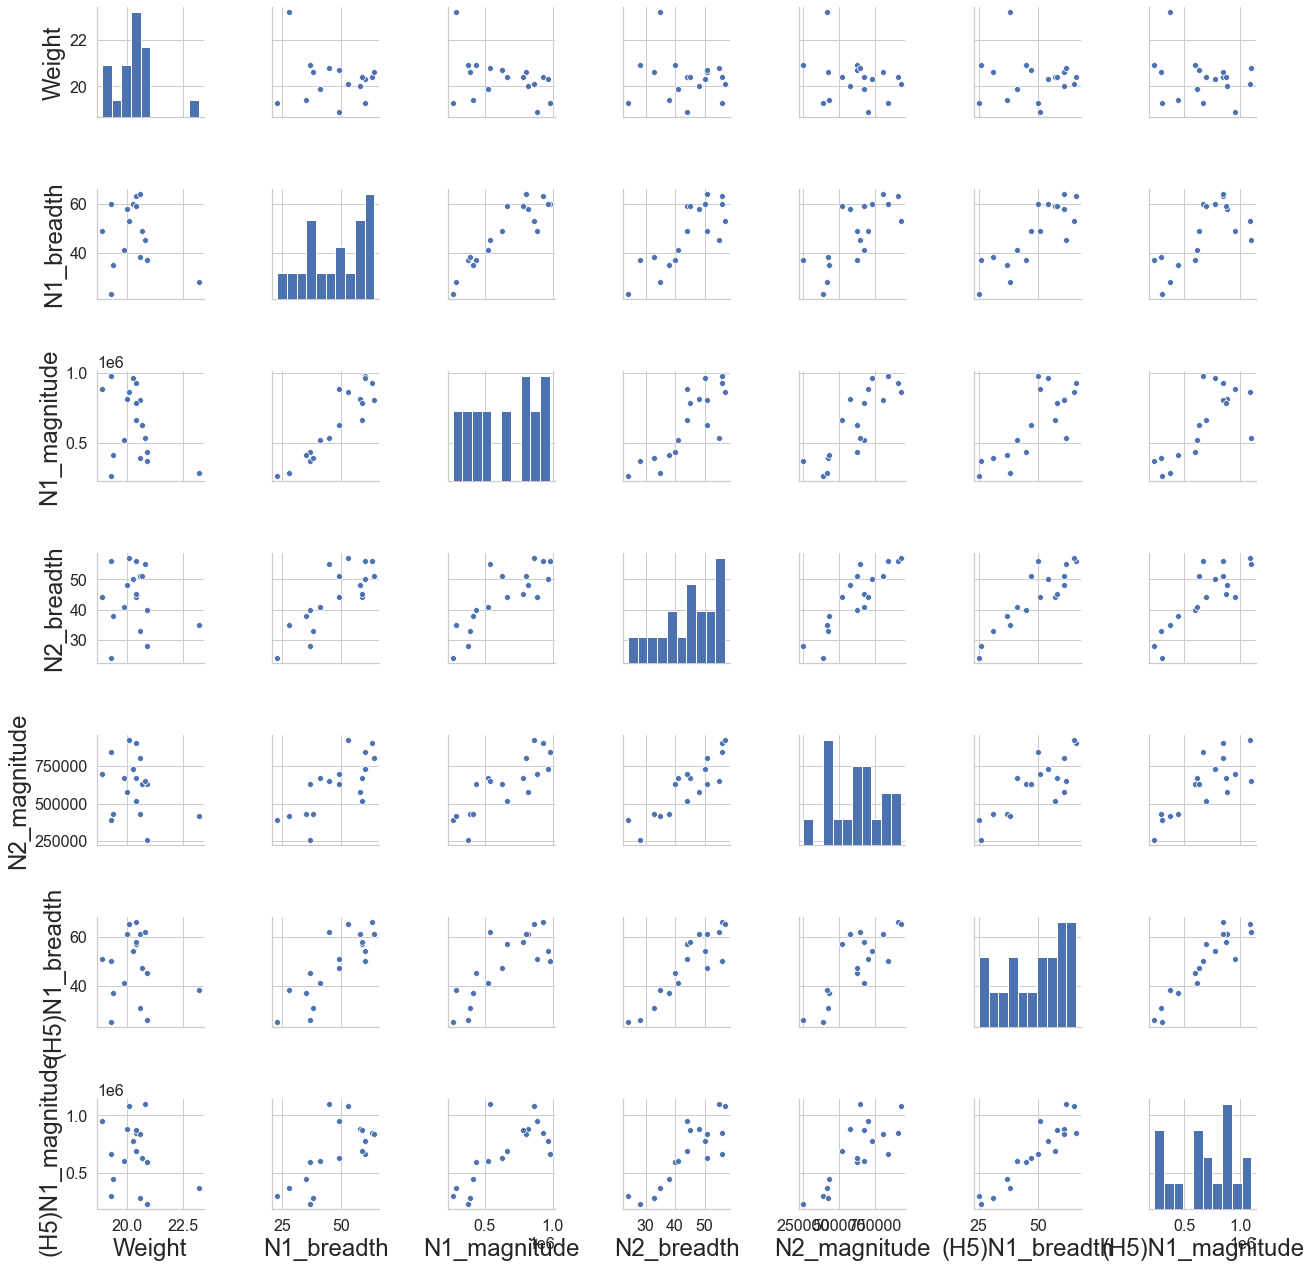

In [314]:
stat, p_val = scipy.stats.ranksums(arr_df[arr_df['group'] == 'Rapa_Dead']['Weight'], arr_df[arr_df['group'] == 'Rapa_Live']['Weight'])
stat, p_val = scipy.stats.ranksums(arr_df[arr_df['group'] == 'PBS_Dead']['Weight'], arr_df[arr_df['group'] == 'PBS_Live']['Weight'])

stat, p_val


sns.pairplot(arr_df[arr_df.Group == 'RAP'][['Weight'] + arr_summary_stats_peptides])

# if FIG_PATH is not None:
#     filename = FIG_PATH  + isotype_name[0] + '_Correlation_between_Weight_MA' 
#     f.savefig(filename)

In [163]:
b_palette = sns.color_palette('Reds', 20)
p_palette = sns.color_palette('Blues', 20)
# palette = [b_palette[5], p_palette[5], b_palette[6], p_palette[6]]
palette = [p_palette[17], p_palette[3], b_palette[17], b_palette[3] ]
#palette = sns.color_palette('BuPu', 8)
sns.set_style("ticks")

## Figure 1 vaccine strain 

In [164]:
arr_df.loc[:, 'timepoint'] = arr_df.index.map(lambda x: x.split('_')[0])
arr_df.tail()

NA_X31_7  NA_X31_22  NA_X31_27  NA_X31_32  NA_X31_37  \
ptid                                                                     
D14_Rapa_Live_71      20.0     3510.0    13134.0       20.0    11327.0   
D14_Rapa_Live_73      20.0     2742.0      951.0       20.0    18632.0   
D14_Rapa_Live_76      20.0     1186.0     3217.0       20.0    18997.0   
D14_Rapa_Live_78      20.0      436.0     3982.0       20.0     2865.0   
D14_Rapa_Live_80      20.0     7707.0     3127.0       20.0     2767.0   

                  NA_X31_42  NA_X31_47  NA_X31_52  NA_X31_57  NA_X31_62  ...  \
ptid                                                                     ...   
D14_Rapa_Live_71       60.0       40.0       20.0     2289.0     7108.0  ...   
D14_Rapa_Live_73     1109.0       20.0       20.0      420.0     1321.0  ...   
D14_Rapa_Live_76      382.0       20.0       38.0      626.0     3826.0  ...   
D14_Rapa_Live_78      509.0       20.0       27.0      214.0      344.0  ...   
D14_Rapa_Live_80     9893.0      121.0       76.0     1949.0      986.0  ...   

                  NA_Vie1203_406_binarized  NA_Vie1203_411_binarized  \
ptid                                                                   
D14_Rapa_Live_71                         0                         0   
D14_Rapa_Live_73                         0                         0   
D14_Rapa_Live_76                         0                         0   
D14_Rapa_Live_78                         0                         1   
D14_Rapa_Live_80                         0                         1   

                  NA_Vie1203_416_binarized  NA_Vie1203_421_binarized  \
ptid                                                                   
D14_Rapa_Live_71                         1                         1   
D14_Rapa_Live_73                         1                         1   
D14_Rapa_Live_76                         1                         1   
D14_Rapa_Live_78                         1                         1   
D14_Rapa_Live_80                         1                         1   

                  NA_Vie1203_426_binarized  NA_Vie1203_431_binarized  \
ptid                                                                   
D14_Rapa_Live_71                         1                         1   
D14_Rapa_Live_73                         1                         1   
D14_Rapa_Live_76                         1                         1   
D14_Rapa_Live_78                         1                         1   
D14_Rapa_Live_80                         1                         1   

                  (H5)N1_breadth  mouse_num  Group  Weight  
ptid                                                        
D14_Rapa_Live_71            41.0         71    RAP    19.9  
D14_Rapa_Live_73            51.0         73    RAP    18.9  
D14_Rapa_Live_76            37.0         76    RAP    19.4  
D14_Rapa_Live_78            38.0         78    RAP    23.2  
D14_Rapa_Live_80            62.0         80    RAP    20.8  

[5 rows x 541 columns]

In [165]:
curr_exp_groups = ['PBS_Live', 'PBS_Dead', 'Rapa_Live', 'Rapa_Dead' ]

In [166]:
dot_cmap = sns.color_palette('Reds', 20)
dot_cmap_b = sns.color_palette('Blues', 20)

In [167]:
dot_cmap

[(0.9985236447520185, 0.9297808535178778, 0.8968858131487889),
 (0.9970472895040369, 0.8987773933102653, 0.8525951557093425),
 (0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9921107266435987, 0.8050288350634371, 0.726320645905421),
 (0.9891580161476355, 0.75040369088812, 0.6539792387543253),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9882352941176471, 0.6261437908496732, 0.5084967320261438),
 (0.9880661284121492, 0.5657823913879277, 0.44029219530949637),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.985113417916186, 0.4476739715494041, 0.32218377547097277),
 (0.974717416378316, 0.37810073048827375, 0.26620530565167244),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.9392848904267589, 0.23932333717800847, 0.17762399077277968),
 (0.8901960784313725, 0.18562091503267975, 0.15294117647058825),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.7785467128027681, 0.08996539792387544, 0.110

In [168]:
import importlib

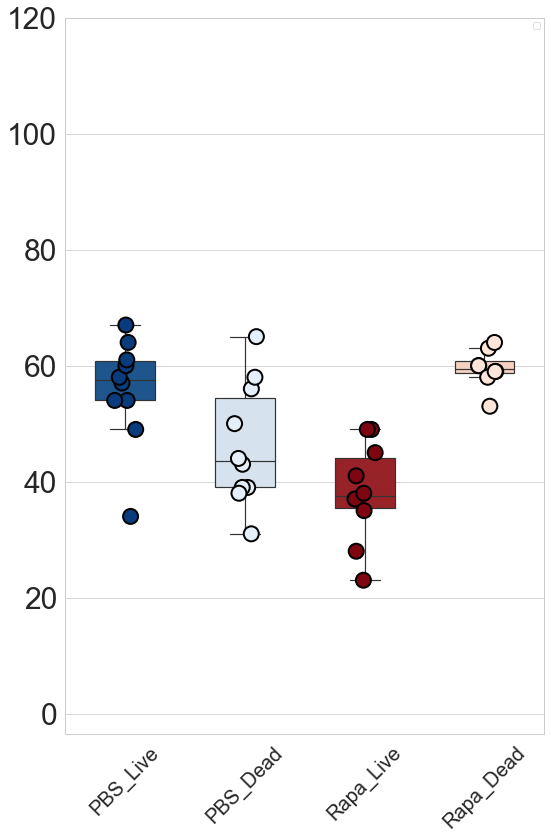

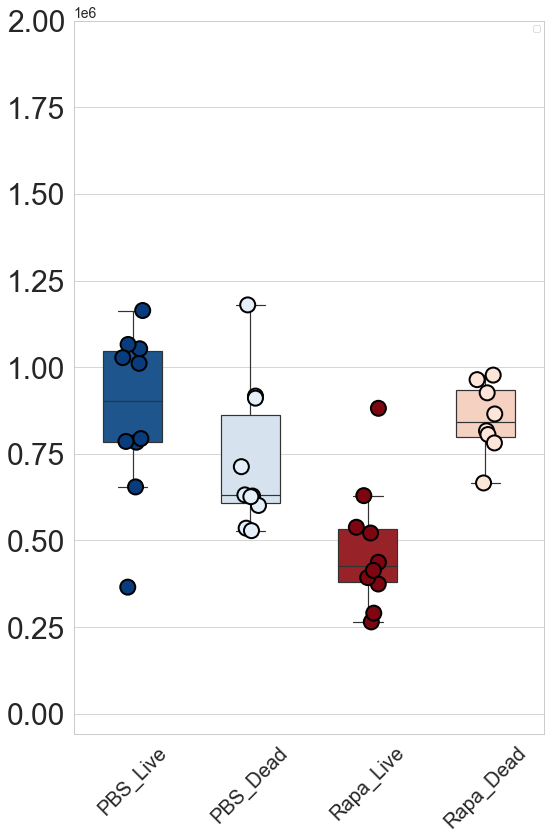

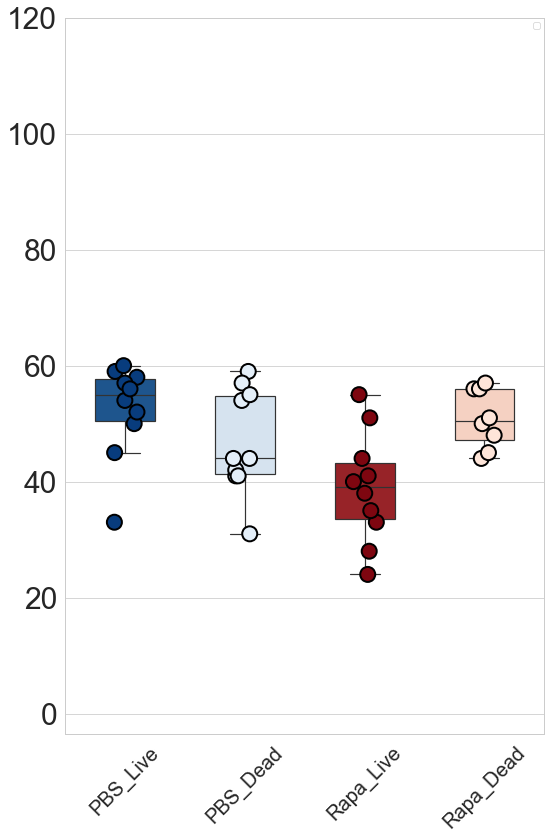

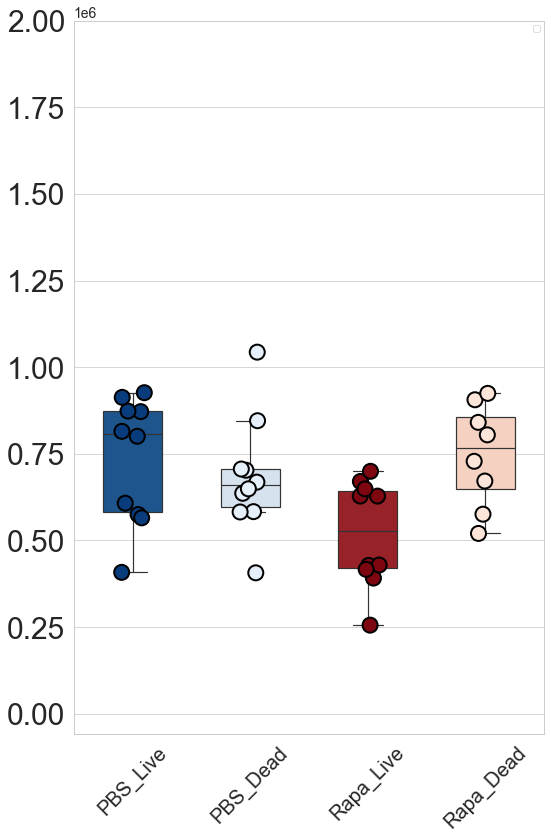

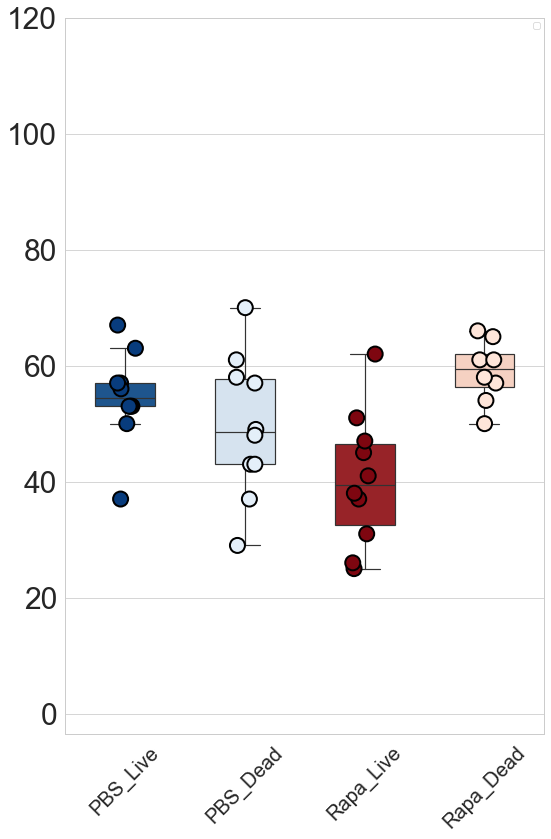

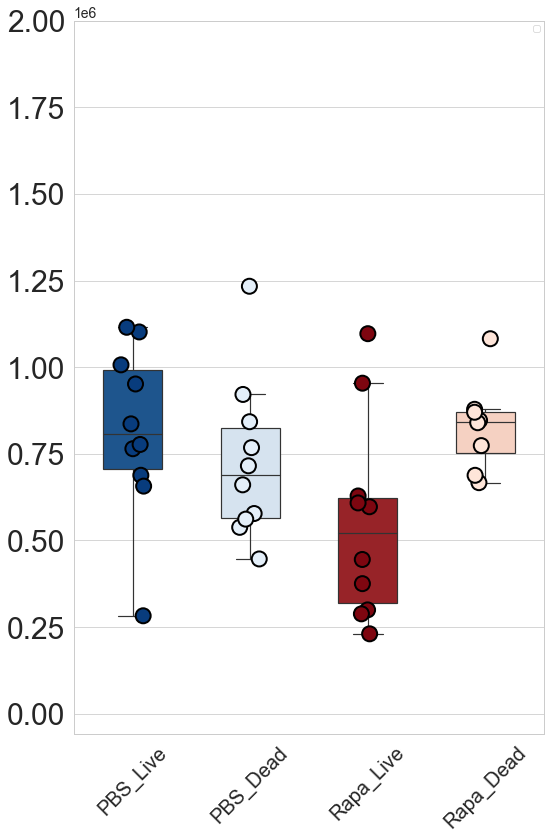

In [169]:
importlib.reload(amp)
# For HA peptides

# PBS blue and Rapa red
#live dark and dead light 

group_dot_colors = [dot_cmap_b[19], dot_cmap_b[1], dot_cmap[19], dot_cmap[1] ]

# Magnitude and Breadth pre vs post
antigen_names = dict(zip(arr_summary_stats_peptides, arr_summary_stats_peptides))
fig_names = dict(zip(arr_summary_stats_peptides, arr_summary_stats_peptides))
if isotype_name[0] == 'IgM':
    if HA_flag:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 100], [0, 1500000], [0, 100], [0, 1500000], [0, 100], [0, 1500000]]))
    else:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 120], [0, 2000000], [0, 120], [0, 2000000], [0, 120], [0, 2000000]]))
else:
    if HA_flag:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 80], [0, 1000000], [0, 80], [0, 1000000],[0, 80], [0, 1000000]]))
    else:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 80], [0, 1100000], [0, 80], [0, 1100000],[0, 80], [0, 1100000]]))

    
    
f = amp.plot_summary_stat_boxplots_by_exp_groups(arr_df=arr_df, arr_summary_stats=arr_summary_stats_peptides,
                                                 arr_summary_stats_labels = arr_summary_stats_peptides_labels, 
                                                 order=curr_exp_groups, box_width=0.5,
                                                 palette=palette, point_size=15, fig_size=(8,12),
                                                 y_lims=y_lims_dict_peptides, group_dot_colors=group_dot_colors,
                                                 exp_group_labels=curr_exp_groups, plot_title=False,
                                                 fig_prefix=isotype_name[0] +'_NA_paper1_1_', fig_path=FIG_PATH)


In [142]:
#All live in purpule and all dead in green
b_palette = sns.color_palette('BrBG', 20)
a_palette = sns.color_palette('Purples', 20)
palette = [a_palette[15], b_palette[15], b_palette[15], a_palette[3]] # 1 and 3 for the bellow figure
sns.set_style("ticks") 

dot_cmap_c = sns.color_palette('BrBG', 20)
dot_cmap_d = sns.color_palette('Purples', 20)

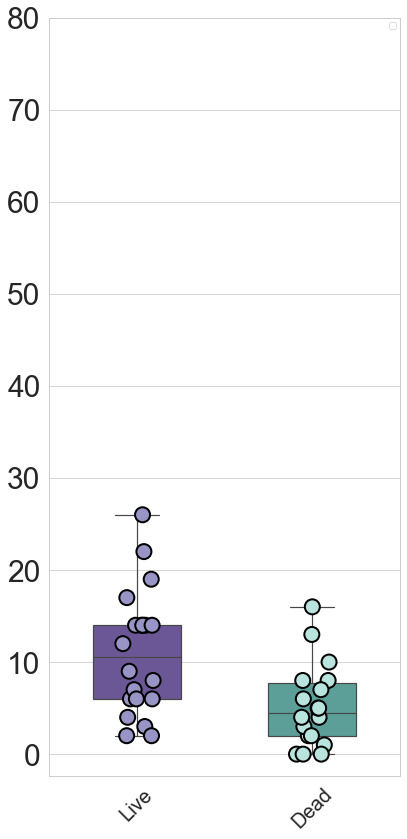

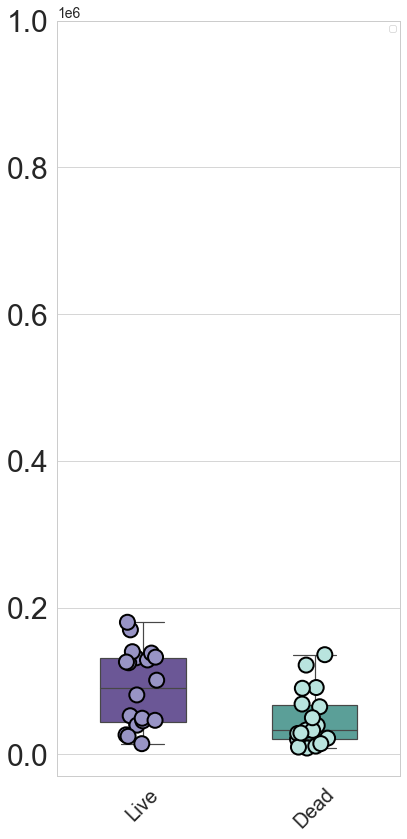

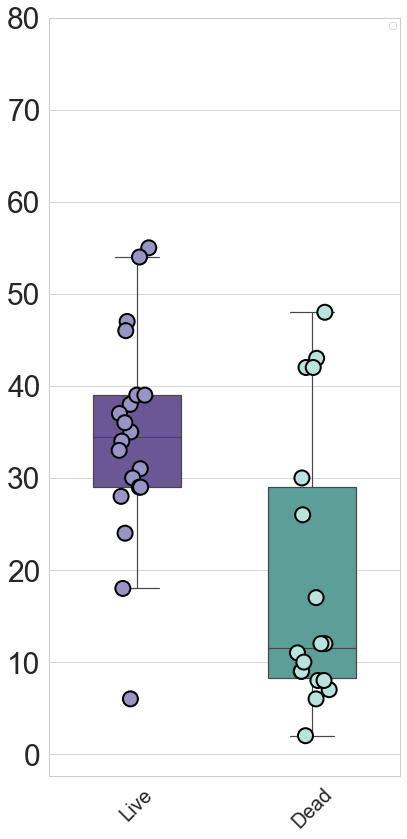

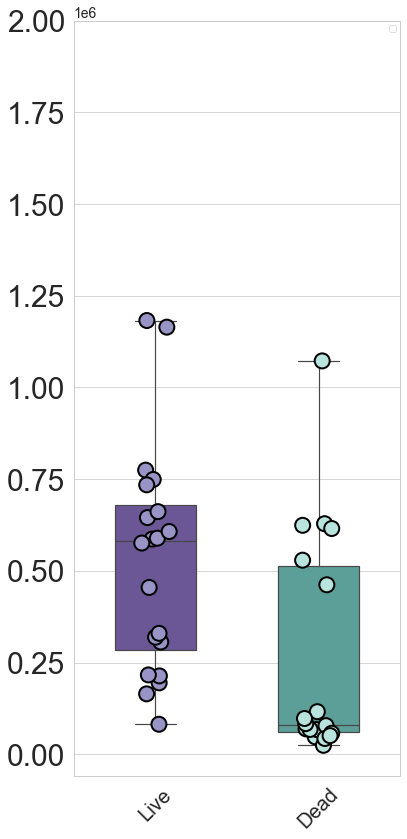

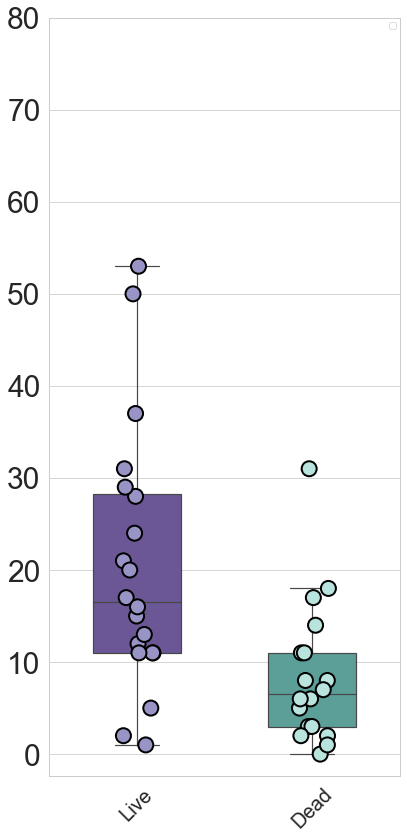

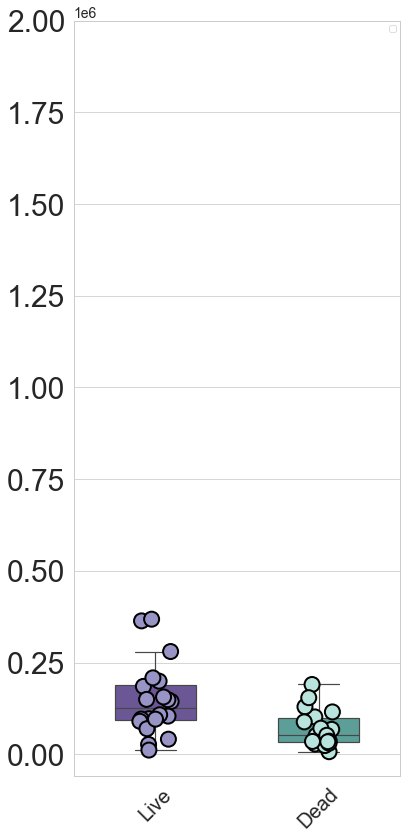

In [143]:
# For HA peptides
# HA peptides , survival group ( live (purpule) vs. dead (green) )

group_dot_colors = [dot_cmap_d[10],  dot_cmap_c[12]]


# Magnitude and Breadth pre vs post
antigen_names = dict(zip(arr_summary_stats_peptides, arr_summary_stats_peptides))
fig_names = dict(zip(arr_summary_stats_peptides, arr_summary_stats_peptides))
if isotype_name[0] == 'IgM':
    if HA_flag:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 100], [0, 1500000], [0, 100], [0, 1500000], [0, 100], [0, 1500000]]))
    else:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 120], [0, 2000000], [0, 120], [0, 2000000], [0, 120], [0, 2000000]]))
else:
    if HA_flag:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 80], [0, 1000000], [0, 80], [0, 1000000],[0, 80], [0, 1000000]]))
    else:
        y_lims_dict_peptides = dict(zip(arr_summary_stats_peptides, [ [0, 80], [0, 1000000], [0, 80], [0, 2000000],[0, 80], [0, 2000000]]))

    
f = amp.plot_summary_stat_boxplots_by_exp_groups(arr_df=arr_df, arr_summary_stats=arr_summary_stats_peptides,
                                                 arr_summary_stats_labels = arr_summary_stats_peptides_labels, 
                                                 order=['Live', 'Dead'], group_column='survival_group', box_width=0.5,
                                                 palette=[palette[0], palette[2]], point_size=15, plot_title=False,
                                                 y_lims=y_lims_dict_peptides, group_dot_colors=group_dot_colors,
                                                 exp_group_labels=['Live', 'Dead'], fig_size=(6,12),
                                                 fig_prefix=isotype_name[0] +'_Survival_paper1_2_', fig_path=FIG_PATH)


In [ ]:
arr_summary_stats_peptides

TypeError: can only concatenate list (not "str") to list

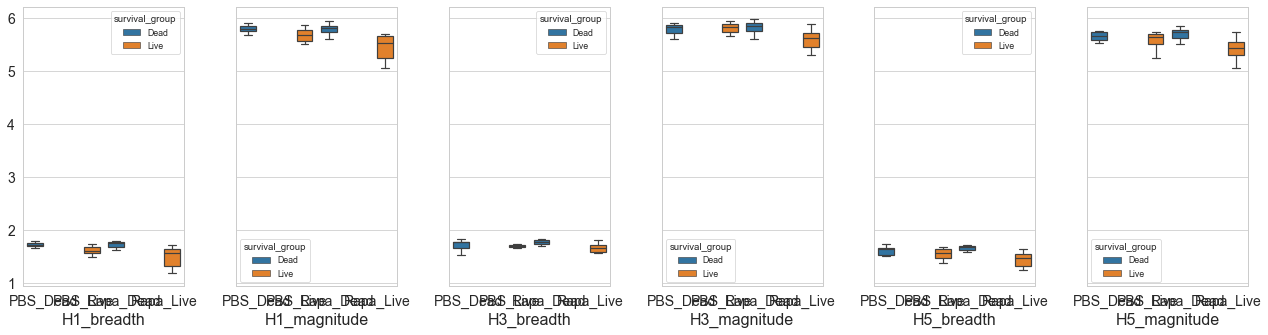

In [185]:
# multipul box plot in one figure 
# curr_strains  = pd.Index(['SARS_CoV_2_S1', 'SARS_CoV_2_RBD', 'SARS_CoV_2_S1wS2_Delta', 'OC43_S1wS2', '229E_S1', 'HKU1_S1']) + '_AUC_normalized'
# f, axes = plt.subplots(1,len(curr_strains), figsize=(18,5),sharey=True)
# for ax_i, var in enumerate(curr_strains):
#     ax = axes.flatten()[ax_i]
#     sns.boxplot(x='group', y =np.log10(curr_df[var]), hue = 'time_point', data=curr_df, ax=ax, showfliers=False )
#     ax.set_ylabel('')
#     ax.set_xlabel(var.replace('_AUC_normalized', ''))
#     #ax.set_ylim(-1.3, 1) # added to make sure graphs are comparable 

# f.suptitle('Vacinated uninfected')
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_PATH, curr_isotype + '_Variants_Vacinated_uninfected_boxplot.png'), dpi=300, bbox_inches='tight', facecolor='w')
# plt.show()

curr_strains  = pd.Index(['H1_breadth', 'H1_magnitude', 'H3_breadth', 'H3_magnitude', 'H5_breadth', 'H5_magnitude']) 
f, axes = plt.subplots(1,len(curr_strains), figsize=(18,5),sharey=True)
for ax_i, var in enumerate(curr_strains):
    ax = axes.flatten()[ax_i]
    sns.boxplot(x='group', y =np.log10(arr_df[var]), hue ='survival_group', data=arr_df, ax=ax, showfliers=False )
    ax.set_ylabel('')
    ax.set_xlabel(var.replace('_AUC_normalized', ''))
    #ax.set_ylim(-1.3, 1) # added to make sure graphs are comparable 

f.suptitle('')
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, isotype_name + '_Variants_Vacinated_uninfected_boxplot.png'), dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [ ]:
print('Ranksum tests comparing live to dead  mice {0} magnitude and breadth responses to NA peptides:\n'.format(isotype_name[0] ))
for a in arr_summary_stats_peptides:
    
    stat, p_val = scipy.stats.ranksums(arr_df.loc[group_inds['Rapa_Live']][a], arr_df.loc[group_inds['Rapa_Dead']][a])
    print('Ranksum test comparing Rapa_Live to Rapa_Dead responses to {0}: stat = {1:.2f}, p = {2:.6f}'.format(a, stat, p_val))

    stat, p_val = scipy.stats.ranksums(arr_df.loc[group_inds['PBS_Live']][a], arr_df.loc[group_inds['PBS_Dead']][a])
    print('Ranksum test comparing PBS_Live to PBS_Dead responses to {0}: stat = {1:.2f}, p = {2:.6f}'.format(a, stat, p_val))
    
    stat, p_val = scipy.stats.ranksums(arr_df.loc[group_inds['Rapa_Live']][a], arr_df.loc[group_inds['PBS_Live']][a])
    print('Ranksum test comparing Rapa_Live to PBS_Live responses to {0}: stat = {1:.2f}, p = {2:.6f}'.format(a, stat, p_val))

    stat, p_val = scipy.stats.ranksums(arr_df.loc[group_inds['Rapa_Dead']][a], arr_df.loc[group_inds['PBS_Dead']][a])
    print('Ranksum test comparing Rapa_Dead to PBS_Dead responses to {0}: stat = {1:.2f}, p = {2:.6f}'.format(a, stat, p_val))
    

    print('--------------------------------------*-------------------------------------')

## Compare stats on live/dead for Rapa3 only (i.p.) across treatment arms

In [257]:
print('Ranksum tests {0} magnitude and breadth responses to HA or NA peptides comparing live to dead  mice across treatment groups :\n'.format(isotype_name[0] ))

for a in arr_summary_stats_peptides:
    
    stat, p_val = scipy.stats.ranksums(arr_df.loc[group_inds_survival_ip['Live']][a], arr_df.loc[group_inds_survival_ip['Dead']][a])
    print('Ranksum test comparing Live to Dead responses to {0}: stat = {1:.2f}, p = {2:.6f}'.format(a, stat, p_val))    

print('--------------------------------------*-------------------------------------')

Ranksum tests IgG magnitude and breadth responses to HA or NA peptides comparing live to dead  mice across treatment groups :

Ranksum test comparing Live to Dead responses to N1_breadth: stat = 2.73, p = 0.006267
Ranksum test comparing Live to Dead responses to N1_magnitude: stat = 2.60, p = 0.009270
Ranksum test comparing Live to Dead responses to N2_breadth: stat = 2.75, p = 0.005994
Ranksum test comparing Live to Dead responses to N2_magnitude: stat = 2.98, p = 0.002864
Ranksum test comparing Live to Dead responses to (H5)N1_breadth: stat = 2.92, p = 0.003461
Ranksum test comparing Live to Dead responses to (H5)N1_magnitude: stat = 2.75, p = 0.005994
--------------------------------------*-------------------------------------


## Compute group summary stats

In [258]:
group_inds

{'Rapa_Live': Index(['D28_Rapa_Live_57', 'D28_Rapa_Live_62', 'D28_Rapa_Live_64',
        'D28_Rapa_Live_66', 'D28_Rapa_Live_69', 'D28_Rapa_Live_71',
        'D28_Rapa_Live_73', 'D28_Rapa_Live_76', 'D28_Rapa_Live_78',
        'D28_Rapa_Live_80'],
       dtype='object', name='ptid'),
 'PBS_Live': Index(['D28_PBS_Live_14', 'D28_PBS_Live_19', 'D28_PBS_Live_27',
        'D28_PBS_Live_33', 'D28_PBS_Live_39', 'D28_PBS_Live_43',
        'D28_PBS_Live_47', 'D28_PBS_Live_49', 'D28_PBS_Live_52',
        'D28_PBS_Live_54'],
       dtype='object', name='ptid'),
 'Rapa_Dead': Index(['D28_Rapa_Dead_58', 'D28_Rapa_Dead_59', 'D28_Rapa_Dead_67',
        'D28_Rapa_Dead_86', 'D28_Rapa_Dead_88', 'D28_Rapa_Dead_90',
        'D28_Rapa_Dead_91', 'D28_Rapa_Dead_95'],
       dtype='object', name='ptid'),
 'PBS_Dead': Index(['D28_PBS_Dead_1', 'D28_PBS_Dead_12', 'D28_PBS_Dead_16',
        'D28_PBS_Dead_22', 'D28_PBS_Dead_28', 'D28_PBS_Dead_3',
        'D28_PBS_Dead_31', 'D28_PBS_Dead_5', 'D28_PBS_Dead_56',
      

In [287]:
# group summary stats :
group_summary_stats = amutils.compute_exp_group_summary_stats_by_protein(arr_df=arr_df, prot_names=prot_names, 
                                                   prot_strs=prot_strs, group_inds=group_inds,
                                                   ind_dict=ind_dict, summary_stat_func=np.median)


# # group summary stats adjusted:
# group_summary_stats_baseline_subtracted = amutils.compute_exp_group_summary_stats_by_protein(arr_df=arr_df, prot_names=prot_names, 
#                                                    prot_strs=prot_strs, group_inds=group_inds,
#                                                    ind_dict=adjusted_ind_dict, summary_stat_func=np.median)

# # group summary stats adjusted:
# group_summary_stats_fold_rise = amutils.compute_exp_group_summary_stats_by_protein(arr_df=arr_df, prot_names=prot_names, 
#                                                    prot_strs=prot_strs, group_inds=group_inds,
#                                                    ind_dict=fold_rise_ind_dict, summary_stat_func=np.median)


In [288]:
arr_summary_stats_peptides

['N1_breadth',
 'N1_magnitude',
 'N2_breadth',
 'N2_magnitude',
 '(H5)N1_breadth',
 '(H5)N1_magnitude']

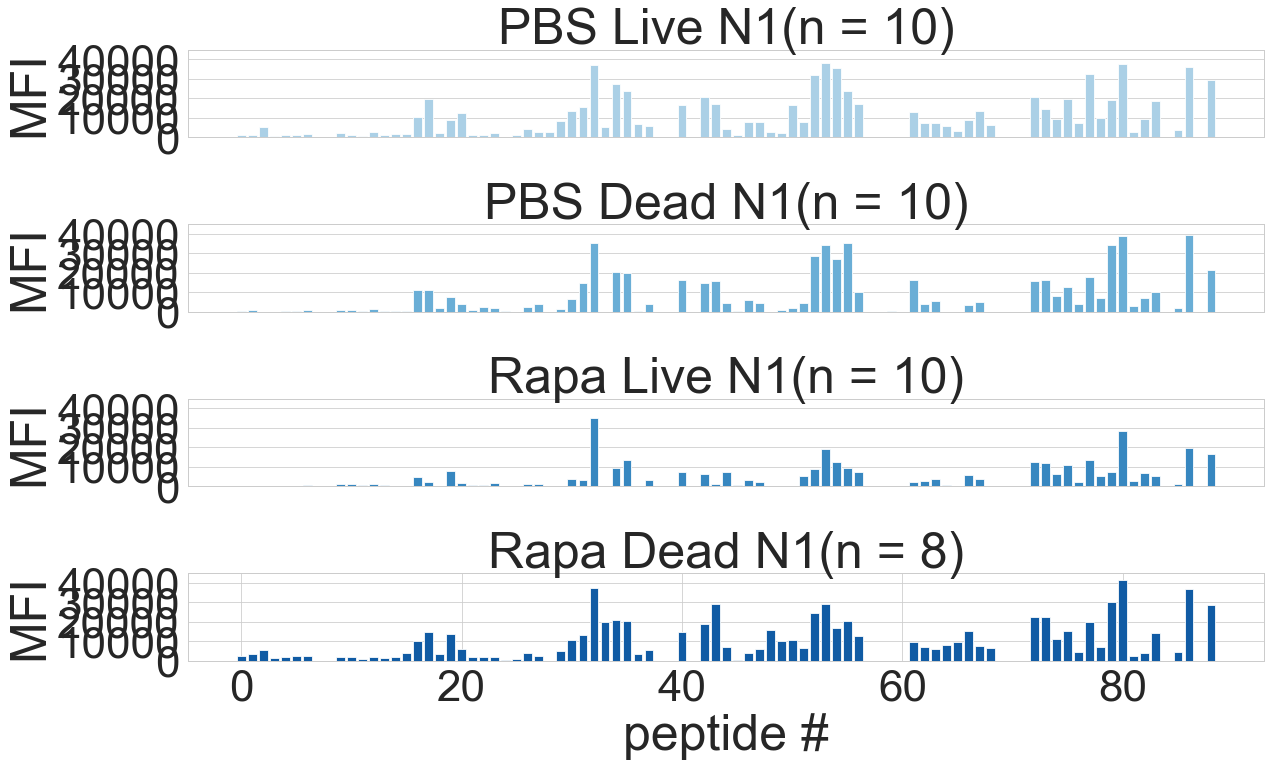

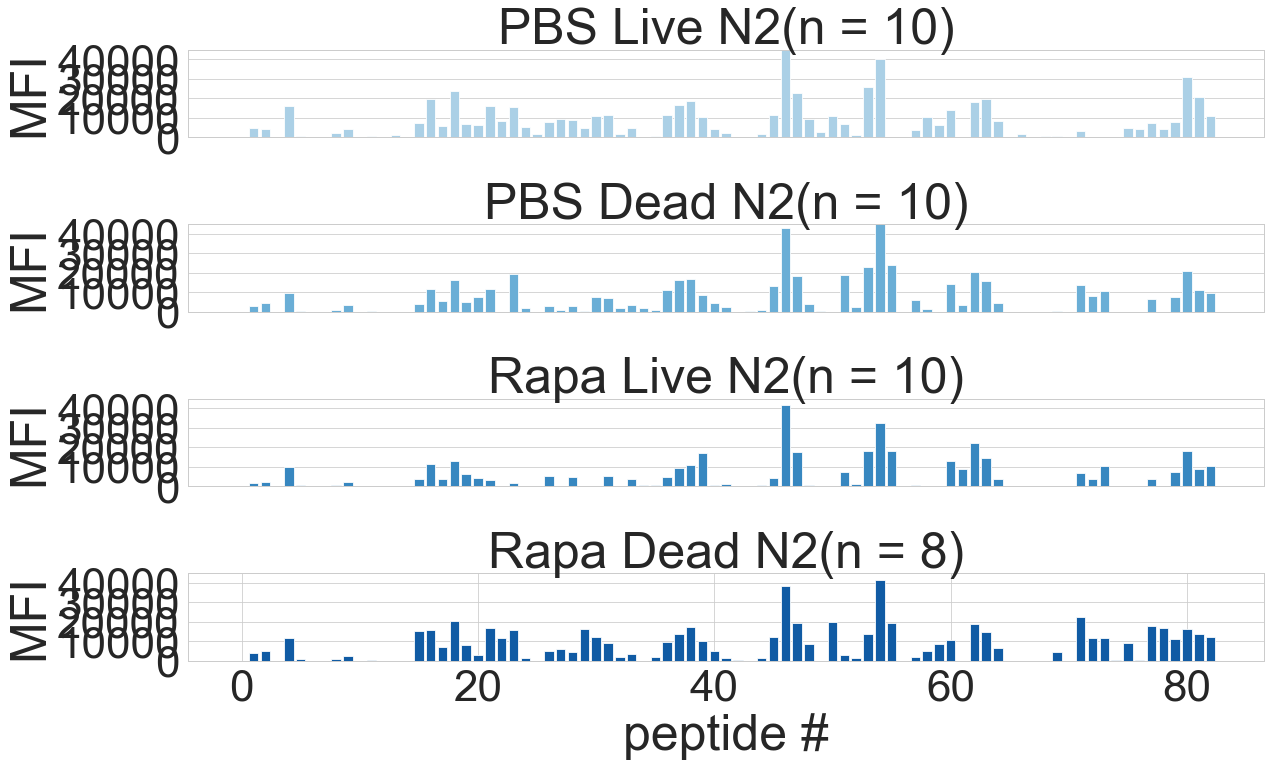

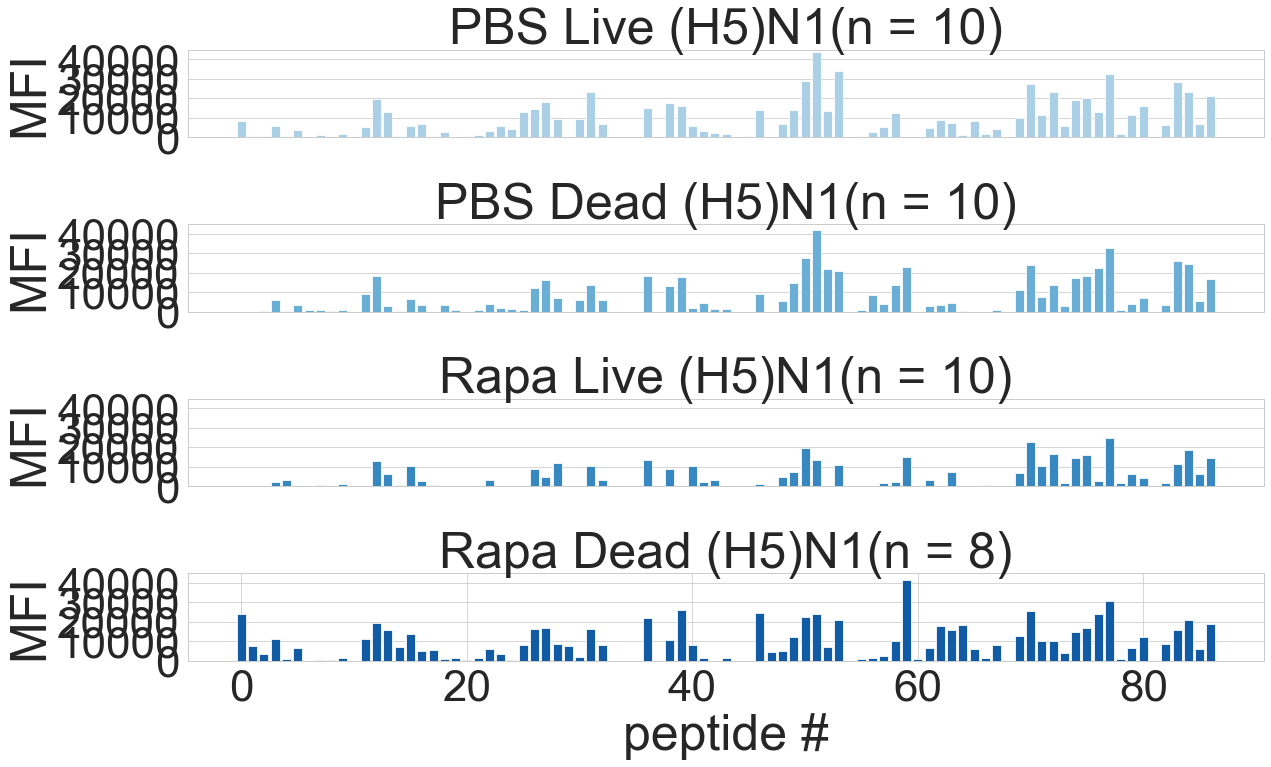

In [289]:
for s in prot_strs:

    f = amp.plot_summary_stat_responses_by_exp_groups(group_summary_stats=group_summary_stats,
                                                      exp_groups=curr_exp_groups, prot_str=s,
                                                      exp_group_labels=curr_exp_groups, y_lims=[0, 45000],
                                                      fig_prefix='group_stats_', fig_path=FIG_PATH)


In [290]:
def corrfunc(x, y, type='pearson', **kws):
    if type == 'pearson':
        r, p = scipy.stats.pearsonr(x, y)
    elif type == 'spearman':
        r, p = scipy.stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}, p = {:.4f}".format(r, p),
                xy=(.6, 0.9), xycoords=ax.transAxes, fontsize=16)

## Analyze single antigens:

In [291]:
a = arr_df[antigens].max() < 2000
arr_df[a.loc[a].index].shape

(38, 18)

In [292]:
import importlib
importlib.reload(amutils)

<module 'amutils' from '\\\\132.72.92.166\\HertzLab_NAS\\Code\\Python\\Utils\\amutils.py'>

In [293]:
ind_dict

{'NA_Cal09': Index(['NA_Cal09_1', 'NA_Cal09_6', 'NA_Cal09_11', 'NA_Cal09_16', 'NA_Cal09_21',
        'NA_Cal09_26', 'NA_Cal09_31', 'NA_Cal09_36', 'NA_Cal09_41',
        'NA_Cal09_46', 'NA_Cal09_51', 'NA_Cal09_56', 'NA_Cal09_61',
        'NA_Cal09_66', 'NA_Cal09_71', 'NA_Cal09_76', 'NA_Cal09_81',
        'NA_Cal09_86', 'NA_Cal09_91', 'NA_Cal09_96', 'NA_Cal09_101',
        'NA_Cal09_106', 'NA_Cal09_111', 'NA_Cal09_116', 'NA_Cal09_121',
        'NA_Cal09_126', 'NA_Cal09_131', 'NA_Cal09_136', 'NA_Cal09_141',
        'NA_Cal09_146', 'NA_Cal09_151', 'NA_Cal09_156', 'NA_Cal09_161',
        'NA_Cal09_166', 'NA_Cal09_171', 'NA_Cal09_176', 'NA_Cal09_181',
        'NA_Cal09_186', 'NA_Cal09_191', 'NA_Cal09_196', 'NA_Cal09_201',
        'NA_Cal09_206', 'NA_Cal09_211', 'NA_Cal09_216', 'NA_Cal09_221',
        'NA_Cal09_226', 'NA_Cal09_236', 'NA_Cal09_241', 'NA_Cal09_246',
        'NA_Cal09_251', 'NA_Cal09_256', 'NA_Cal09_261', 'NA_Cal09_266',
        'NA_Cal09_271', 'NA_Cal09_276', 'NA_Cal09_281', 'N

## Analyzing single peptides across the 4 treatment groups

Number of peptides remaining for comparisons after blinded filtering for NA_Cal09 is 51
Number of peptides remaining for comparisons after blinded filtering for NA_X31 is 54
Number of peptides remaining for comparisons after blinded filtering for NA_Vie1203 is 57


Results for comparisons of group Rapa_Live to group Rapa_Dead for N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0    NA_Cal09_11   a=1, b=9, c=6, d=2  0.012821          0.653846  0.072650   
1    NA_Cal09_86   a=4, b=6, c=8, d=0  0.012821          0.653846  0.072650   
2   NA_Cal09_146   a=1, b=9, c=5, d=3  0.042986          1.000000  0.168639   
3   NA_Cal09_166   a=2, b=8, c=7, d=1  0.015220          0.776224  0.077622   
4   NA_Cal09_186   a=1, b=9, c=5, d=3  0.042986          1.000000  0.168639   
5   NA_Cal09_216   a=4, b=6, c=8, d=0  0.012821          0.653846  0.072650   
6   NA_Cal09_241  a=0, b=10, c=5, d=3  0.006536          0.333333  0.072650   
7   NA_Cal09_246  a=0, b=10, c=8, d=0  0.000023          0.001166  0.001166   
8   NA_Cal09_316   a=4, b=6, c=8, d=0  0.012821          0.653846  0.072650   
9   NA_Cal09_326   a=1, b=9, c=6, d=2  0.012821          0.653846  0.072650   
10  NA_Cal09_331   a=2, b=8, c=8, d=0  0.001051          0.053613  0.017871   
11  NA_Cal09_346   a=1, b=9, c=8, d=0  0.000411          0.020979  0.010490   
12  NA_Cal09_421   a=5, b=5, c=8, d=0  0.035948          1.000000  0.166667   

   isotype              group_names  
0      IgM  Rapa_Live vs. Rapa_Dead  
1      IgM  Rapa_Live vs. Rapa_Dead  
2      IgM  Rapa_Live vs. Rapa_Dead  
3      IgM  Rapa_Live vs. Rapa_Dead  
4      IgM  Rapa_Live vs. Rapa_Dead  
5      IgM  Rapa_Live vs. Rapa_Dead  
6      IgM  Rapa_Live vs. Rapa_Dead  
7      IgM  Rapa_Live vs. Rapa_Dead  
8      IgM  Rapa_Live vs. Rapa_Dead  
9      IgM  Rapa_Live vs. Rapa_Dead  
10     IgM  Rapa_Live vs. Rapa_Dead  
11     IgM  Rapa_Live vs. Rapa_Dead  
12     IgM  Rapa_Live vs. Rapa_Dead



Results for comparisons of group Rapa_Live to group Rapa_Dead for N2
-------------------------------------------------


Antigen       Fisher Counts   p-value  adjusted p-value   q-value  \
0   NA_X31_27  a=1, b=9, c=6, d=2  0.012821          0.692308  0.115385   
1  NA_X31_127  a=2, b=8, c=8, d=0  0.001051          0.056767  0.011353   
2  NA_X31_162  a=1, b=9, c=8, d=0  0.000411          0.022213  0.007404   
3  NA_X31_332  a=2, b=8, c=8, d=0  0.001051          0.056767  0.011353   
4  NA_X31_342  a=8, b=2, c=1, d=7  0.015220          0.821884  0.117412   
5  NA_X31_412  a=1, b=9, c=8, d=0  0.000411          0.022213  0.007404   
6  NA_X31_427  a=1, b=9, c=8, d=0  0.000411          0.022213  0.007404   

  isotype              group_names  
0     IgM  Rapa_Live vs. Rapa_Dead  
1     IgM  Rapa_Live vs. Rapa_Dead  
2     IgM  Rapa_Live vs. Rapa_Dead  
3     IgM  Rapa_Live vs. Rapa_Dead  
4     IgM  Rapa_Live vs. Rapa_Dead  
5     IgM  Rapa_Live vs. Rapa_Dead  
6     IgM  Rapa_Live vs. Rapa_Dead



Results for comparisons of group Rapa_Live to group Rapa_Dead for (H5)N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0     NA_Vie1203_1   a=3, b=7, c=8, d=0  0.004022          0.229261  0.025473   
1     NA_Vie1203_6   a=1, b=9, c=8, d=0  0.000411          0.023447  0.011724   
2    NA_Vie1203_16   a=1, b=9, c=8, d=0  0.000411          0.023447  0.011724   
3    NA_Vie1203_26   a=3, b=7, c=7, d=1  0.024818          1.000000  0.117887   
4    NA_Vie1203_56   a=2, b=8, c=8, d=0  0.001051          0.059920  0.019973   
5   NA_Vie1203_196   a=3, b=7, c=8, d=0  0.004022          0.229261  0.025473   
6   NA_Vie1203_211   a=5, b=5, c=0, d=8  0.035948          1.000000  0.146359   
7   NA_Vie1203_231   a=3, b=7, c=8, d=0  0.004022          0.229261  0.025473   
8   NA_Vie1203_311   a=3, b=7, c=8, d=0  0.004022          0.229261  0.025473   
9   NA_Vie1203_321   a=1, b=9, c=7, d=1  0.002879          0.164130  0.025473   
10  NA_Vie1203_336  a=0, b=10, c=6, d=2  0.001508          0.085973  0.021493   
11  NA_Vie1203_366  a=0, b=10, c=5, d=3  0.006536          0.372549  0.037255   
12  NA_Vie1203_401   a=5, b=5, c=8, d=0  0.035948          1.000000  0.146359   
13  NA_Vie1203_411   a=3, b=7, c=7, d=1  0.024818          1.000000  0.117887   

   isotype              group_names  
0      IgM  Rapa_Live vs. Rapa_Dead  
1      IgM  Rapa_Live vs. Rapa_Dead  
2      IgM  Rapa_Live vs. Rapa_Dead  
3      IgM  Rapa_Live vs. Rapa_Dead  
4      IgM  Rapa_Live vs. Rapa_Dead  
5      IgM  Rapa_Live vs. Rapa_Dead  
6      IgM  Rapa_Live vs. Rapa_Dead  
7      IgM  Rapa_Live vs. Rapa_Dead  
8      IgM  Rapa_Live vs. Rapa_Dead  
9      IgM  Rapa_Live vs. Rapa_Dead  
10     IgM  Rapa_Live vs. Rapa_Dead  
11     IgM  Rapa_Live vs. Rapa_Dead  
12     IgM  Rapa_Live vs. Rapa_Dead  
13     IgM  Rapa_Live vs. Rapa_Dead

\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

Results for comparisons of group PBS_Live to group PBS_Dead for N1
-------------------------------------------------


Empty DataFrame
Columns: [Antigen, Fisher Counts, p-value, adjusted p-value, q-value]
Index: []



Results for comparisons of group PBS_Live to group PBS_Dead for N2
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0  NA_X31_312  a=0, b=10, c=8, d=2  0.000714          0.038581  0.038581   

  isotype            group_names  
0     IgM  PBS_Live vs. PBS_Dead



Results for comparisons of group PBS_Live to group PBS_Dead for (H5)N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0  NA_Vie1203_1  a=10, b=0, c=3, d=7  0.003096          0.176471  0.176471   

  isotype            group_names  
0     IgM  PBS_Live vs. PBS_Dead

\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)


Results for comparisons of group Rapa_Dead to group PBS_Dead for N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0   NA_Cal09_11  a=6, b=2, c=0, d=10  0.001508          0.076923  0.038462   
1  NA_Cal09_246   a=8, b=0, c=2, d=8  0.001051          0.053613  0.038462   
2  NA_Cal09_331   a=8, b=0, c=4, d=6  0.012821          0.653846  0.130769   
3  NA_Cal09_336   a=8, b=0, c=4, d=6  0.012821          0.653846  0.130769   
4  NA_Cal09_346   a=8, b=0, c=3, d=7  0.004022          0.205128  0.068376   

  isotype             group_names  
0     IgM  Rapa_Dead vs. PBS_Dead  
1     IgM  Rapa_Dead vs. PBS_Dead  
2     IgM  Rapa_Dead vs. PBS_Dead  
3     IgM  Rapa_Dead vs. PBS_Dead  
4     IgM  Rapa_Dead vs. PBS_Dead



Results for comparisons of group Rapa_Dead to group PBS_Dead for N2
-------------------------------------------------


Antigen       Fisher Counts   p-value  adjusted p-value   q-value  \
0  NA_X31_127  a=8, b=0, c=4, d=6  0.012821          0.692308  0.136981   
1  NA_X31_162  a=8, b=0, c=4, d=6  0.012821          0.692308  0.136981   
2  NA_X31_292  a=1, b=7, c=8, d=2  0.015220          0.821884  0.136981   
3  NA_X31_332  a=8, b=0, c=4, d=6  0.012821          0.692308  0.136981   
4  NA_X31_412  a=8, b=0, c=4, d=6  0.012821          0.692308  0.136981   
5  NA_X31_427  a=8, b=0, c=3, d=7  0.004022          0.217195  0.136981   

  isotype             group_names  
0     IgM  Rapa_Dead vs. PBS_Dead  
1     IgM  Rapa_Dead vs. PBS_Dead  
2     IgM  Rapa_Dead vs. PBS_Dead  
3     IgM  Rapa_Dead vs. PBS_Dead  
4     IgM  Rapa_Dead vs. PBS_Dead  
5     IgM  Rapa_Dead vs. PBS_Dead



Results for comparisons of group Rapa_Dead to group PBS_Dead for (H5)N1
-------------------------------------------------


Antigen       Fisher Counts   p-value  adjusted p-value   q-value  \
0    NA_Vie1203_1  a=8, b=0, c=3, d=7  0.004022          0.229261  0.114630   
1    NA_Vie1203_6  a=8, b=0, c=1, d=9  0.000411          0.023447  0.023447   
2   NA_Vie1203_66  a=8, b=0, c=4, d=6  0.012821          0.730769  0.182692   
3  NA_Vie1203_336  a=6, b=2, c=1, d=9  0.012821          0.730769  0.182692   

  isotype             group_names  
0     IgM  Rapa_Dead vs. PBS_Dead  
1     IgM  Rapa_Dead vs. PBS_Dead  
2     IgM  Rapa_Dead vs. PBS_Dead  
3     IgM  Rapa_Dead vs. PBS_Dead

\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

Results for comparisons of group Rapa_Live to group PBS_Live for N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0   NA_Cal09_86  a=4, b=6, c=10, d=0  0.010836          0.552632  0.092105   
1  NA_Cal09_146   a=1, b=9, c=8, d=2  0.005477          0.279352  0.069838   
2  NA_Cal09_181   a=1, b=9, c=7, d=3  0.019767          1.000000  0.112011   
3  NA_Cal09_186   a=1, b=9, c=7, d=3  0.019767          1.000000  0.112011   
4  NA_Cal09_216  a=4, b=6, c=10, d=0  0.010836          0.552632  0.092105   
5  NA_Cal09_241  a=0, b=10, c=9, d=1  0.000119          0.006073  0.006073   
6  NA_Cal09_321   a=3, b=7, c=9, d=1  0.019767          1.000000  0.112011   
7  NA_Cal09_326   a=1, b=9, c=8, d=2  0.005477          0.279352  0.069838   
8  NA_Cal09_346   a=1, b=9, c=8, d=2  0.005477          0.279352  0.069838   

  isotype             group_names  
0     IgM  Rapa_Live vs. PBS_Live  
1     IgM  Rapa_Live vs. PBS_Live  
2     IgM  Rapa_Live vs. PBS_Live  
3     IgM  Rapa_Live vs. PBS_Live  
4     IgM  Rapa_Live vs. PBS_Live  
5     IgM  Rapa_Live vs. PBS_Live  
6     IgM  Rapa_Live vs. PBS_Live  
7     IgM  Rapa_Live vs. PBS_Live  
8     IgM  Rapa_Live vs. PBS_Live



Results for comparisons of group Rapa_Live to group PBS_Live for N2
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0   NA_X31_22   a=1, b=9, c=7, d=3  0.019767          1.000000  0.177899   
1  NA_X31_127   a=2, b=8, c=9, d=1  0.005477          0.295785  0.098595   
2  NA_X31_277   a=3, b=7, c=9, d=1  0.019767          1.000000  0.177899   
3  NA_X31_287   a=3, b=7, c=9, d=1  0.019767          1.000000  0.177899   
4  NA_X31_312  a=7, b=3, c=0, d=10  0.003096          0.167183  0.098595   
5  NA_X31_327   a=1, b=9, c=8, d=2  0.005477          0.295785  0.098595   

  isotype             group_names  
0     IgM  Rapa_Live vs. PBS_Live  
1     IgM  Rapa_Live vs. PBS_Live  
2     IgM  Rapa_Live vs. PBS_Live  
3     IgM  Rapa_Live vs. PBS_Live  
4     IgM  Rapa_Live vs. PBS_Live  
5     IgM  Rapa_Live vs. PBS_Live



Results for comparisons of group Rapa_Live to group PBS_Live for (H5)N1
-------------------------------------------------


Antigen        Fisher Counts   p-value  adjusted p-value   q-value  \
0    NA_Vie1203_1  a=3, b=7, c=10, d=0  0.003096          0.176471  0.058824   
1  NA_Vie1203_196  a=3, b=7, c=10, d=0  0.003096          0.176471  0.058824   
2  NA_Vie1203_366  a=0, b=10, c=7, d=3  0.003096          0.176471  0.058824   

  isotype             group_names  
0     IgM  Rapa_Live vs. PBS_Live  
1     IgM  Rapa_Live vs. PBS_Live  
2     IgM  Rapa_Live vs. PBS_Live

\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=fig_size)
\\132.72.92.166\HertzLab_NAS\Code\Python\Utils\amplotlib.py:1423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

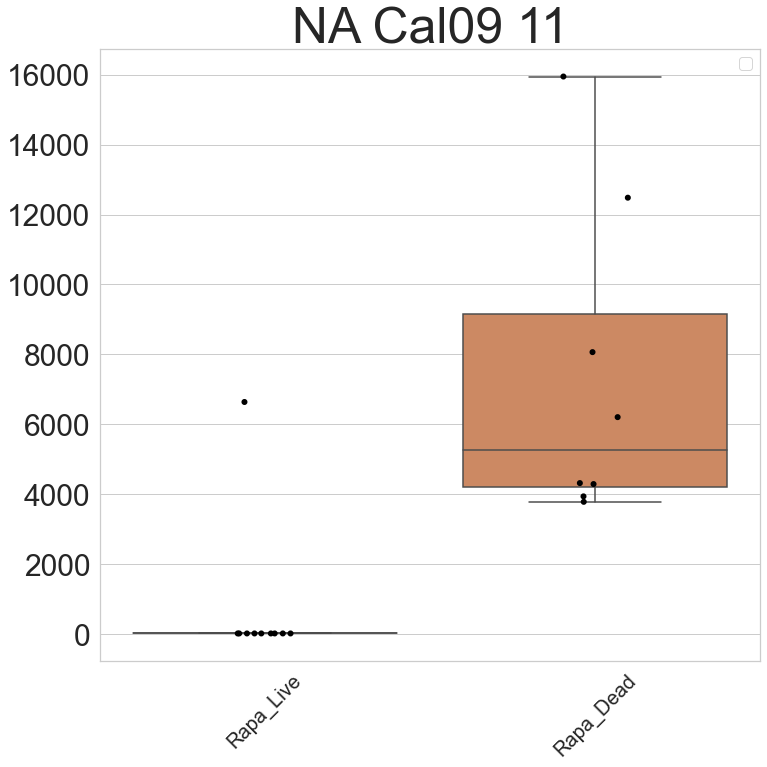

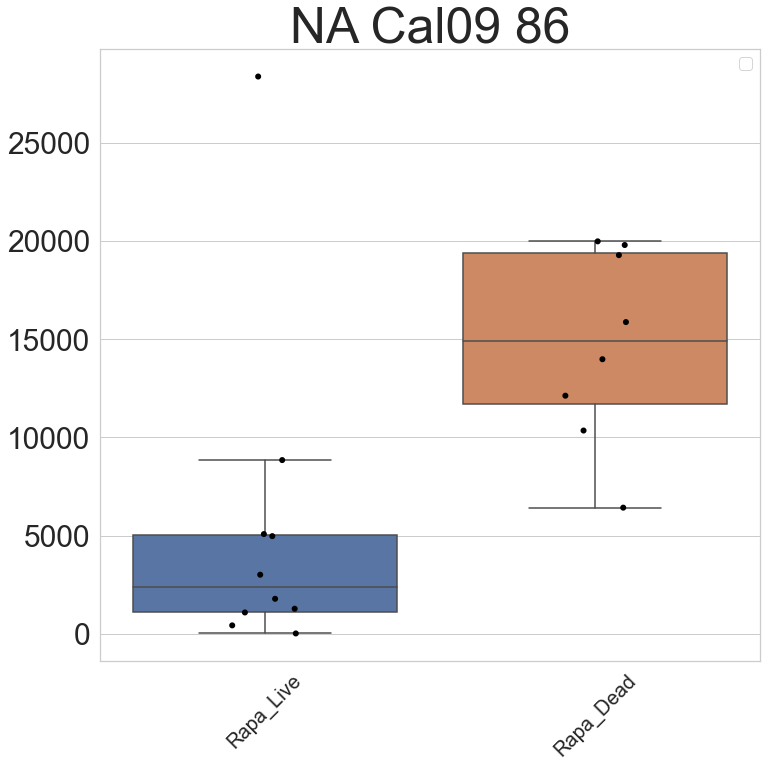

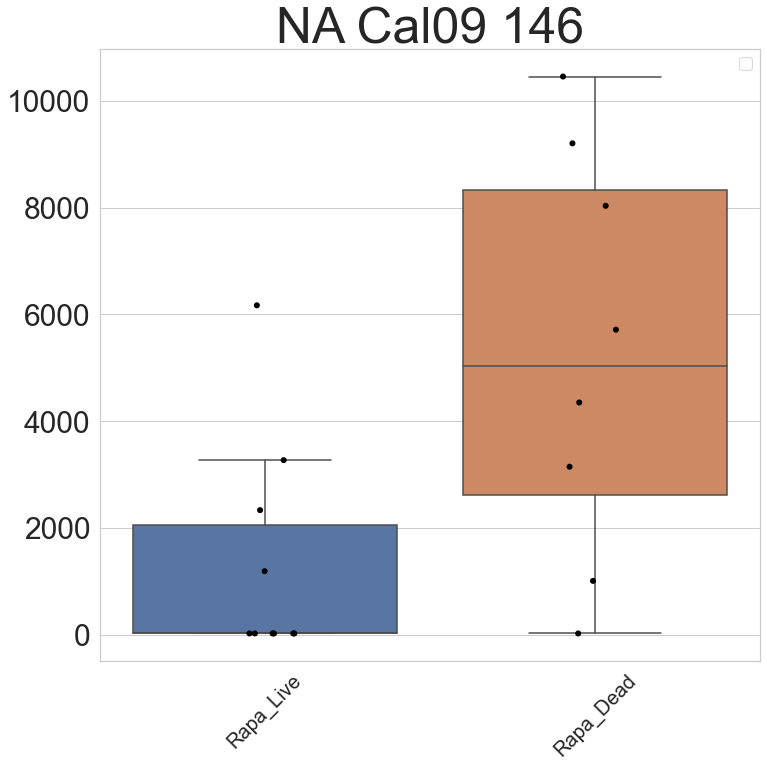

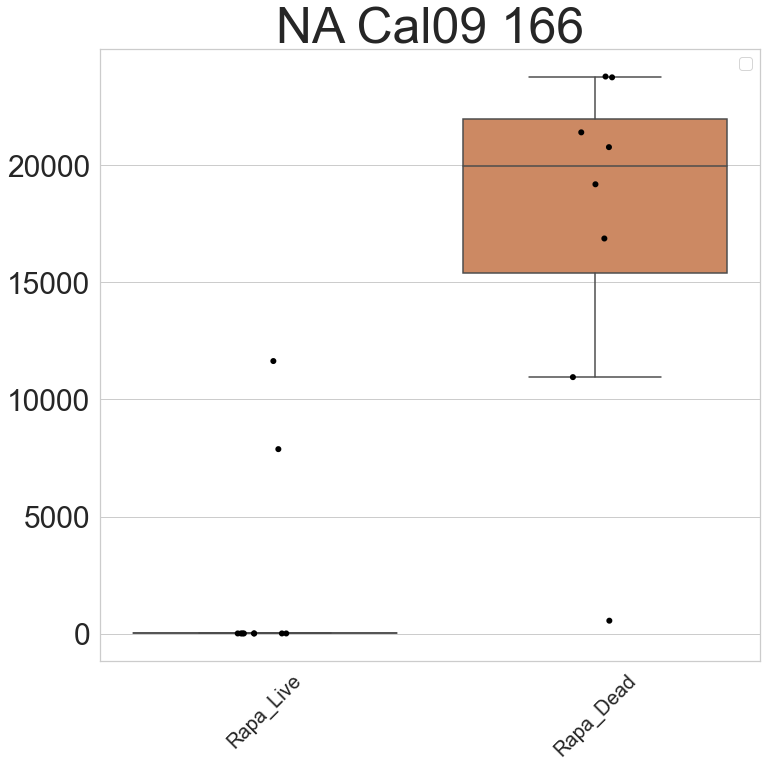

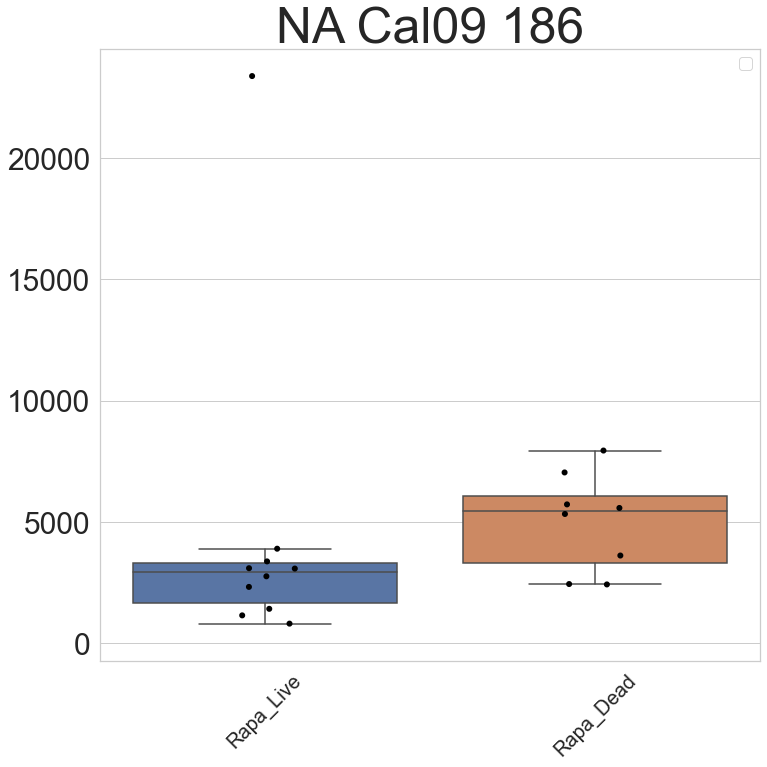

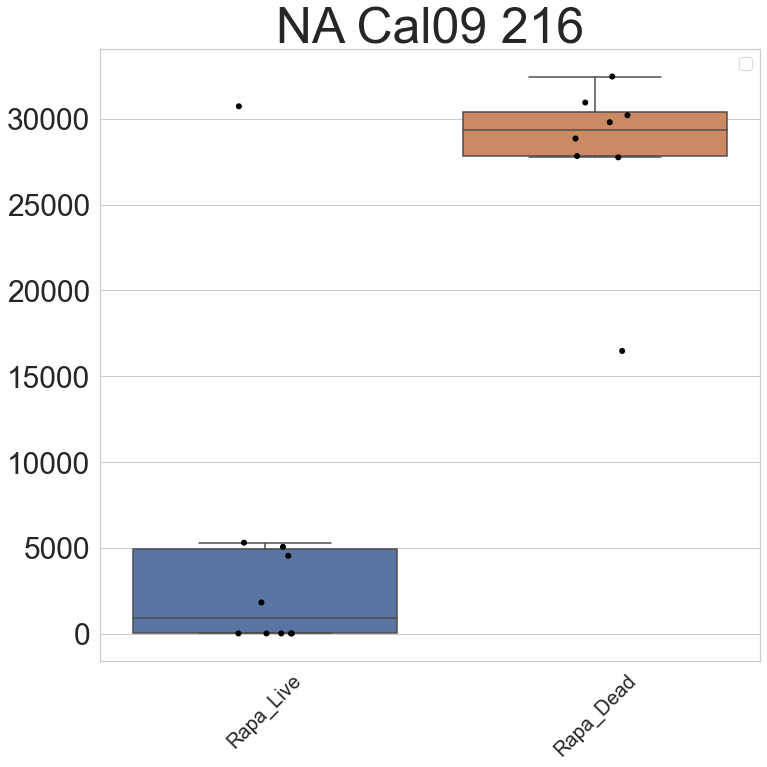

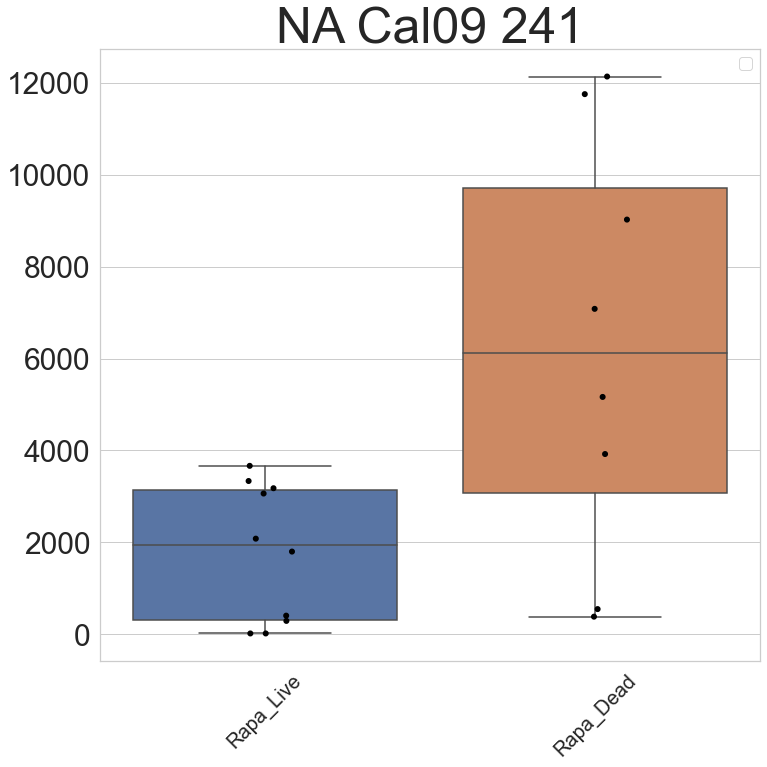

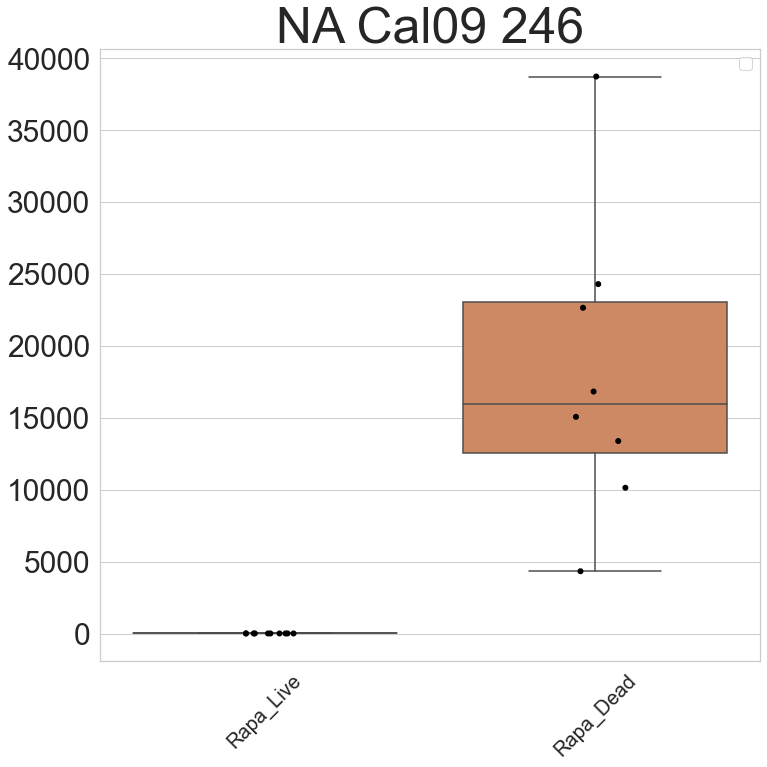

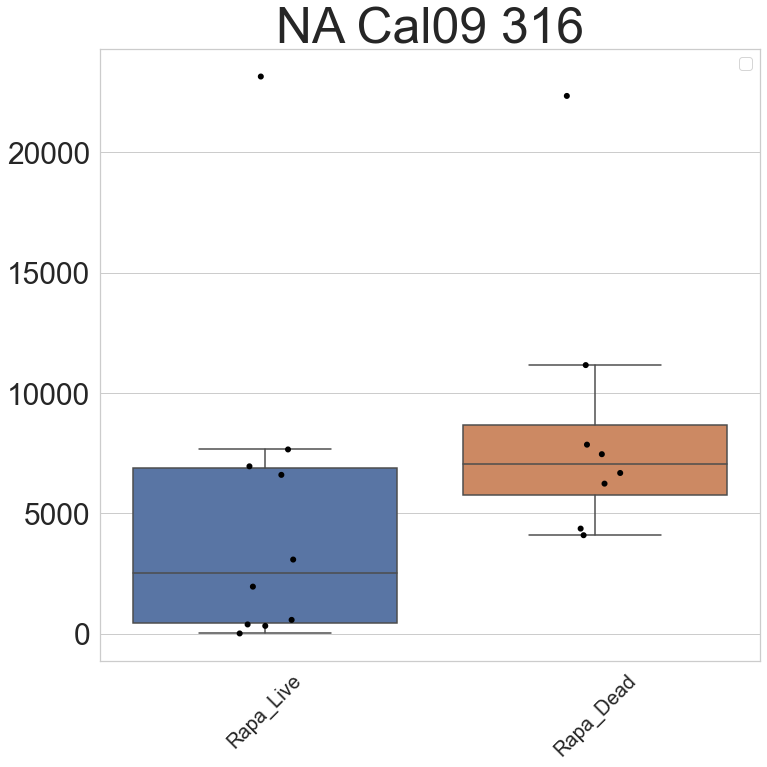

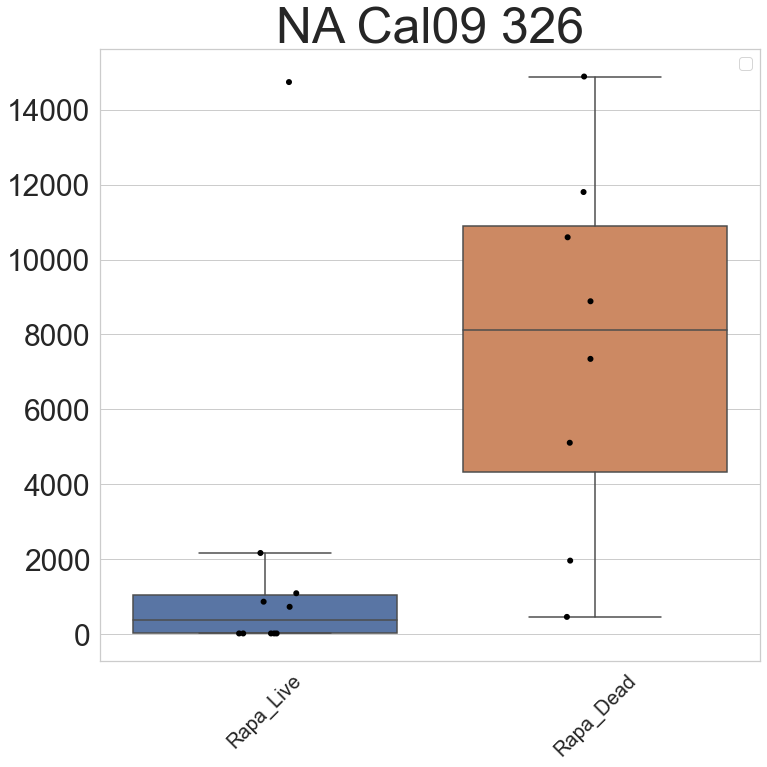

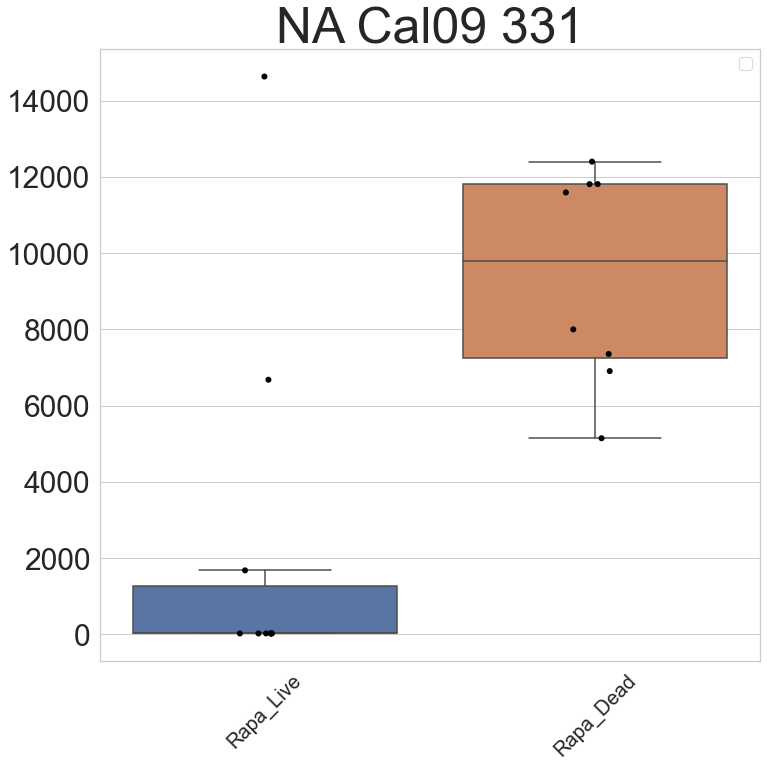

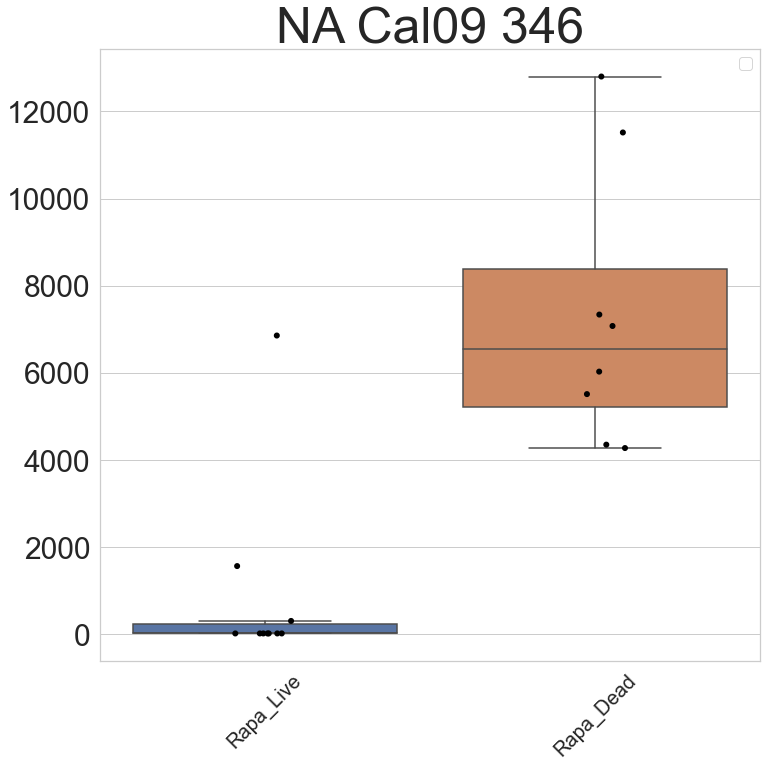

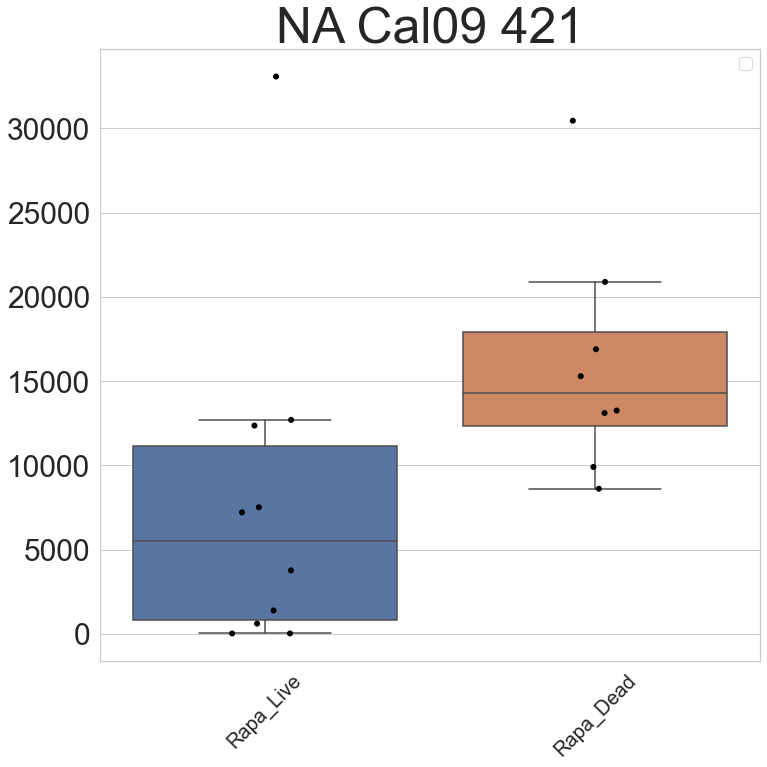

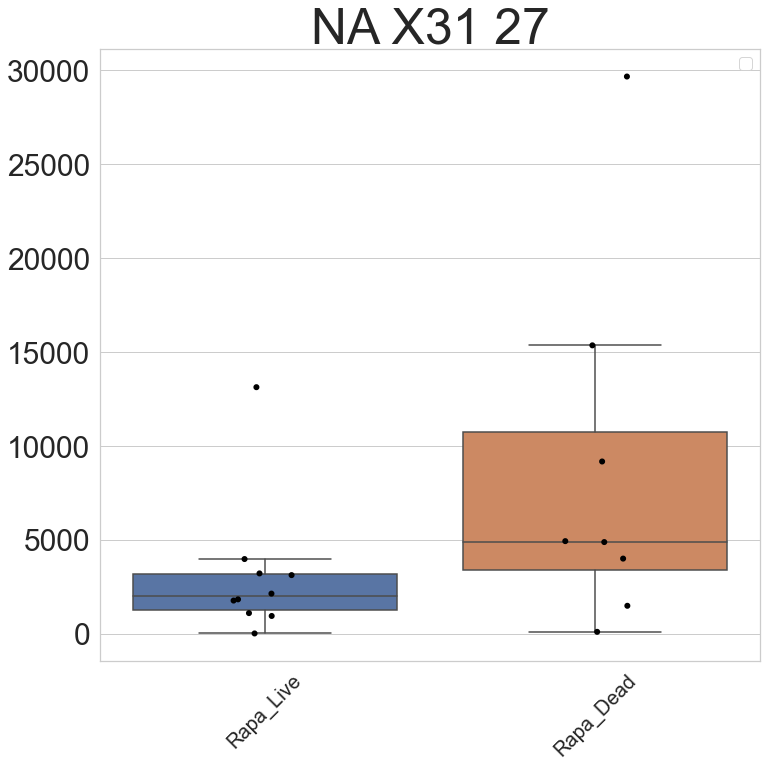

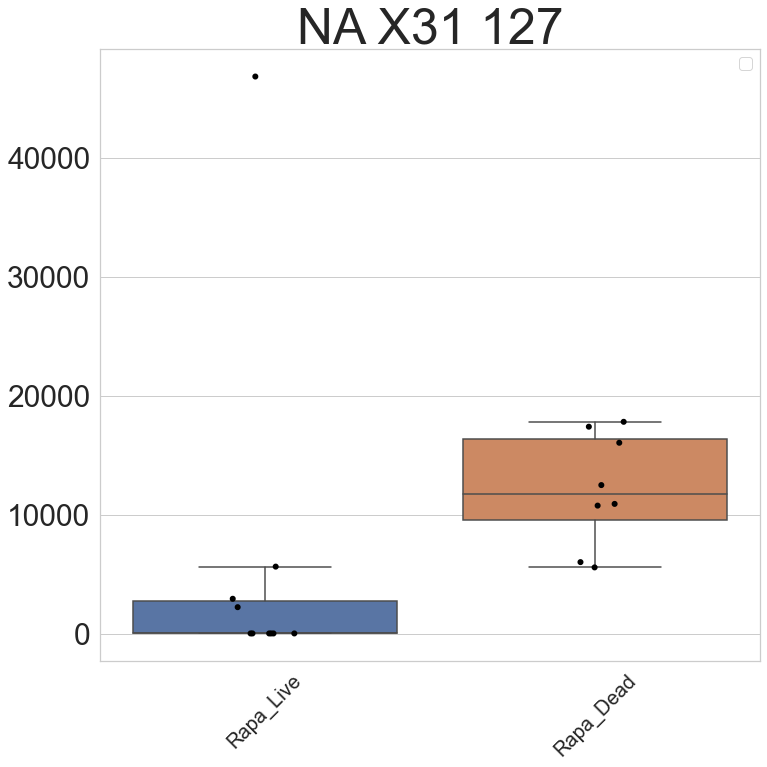

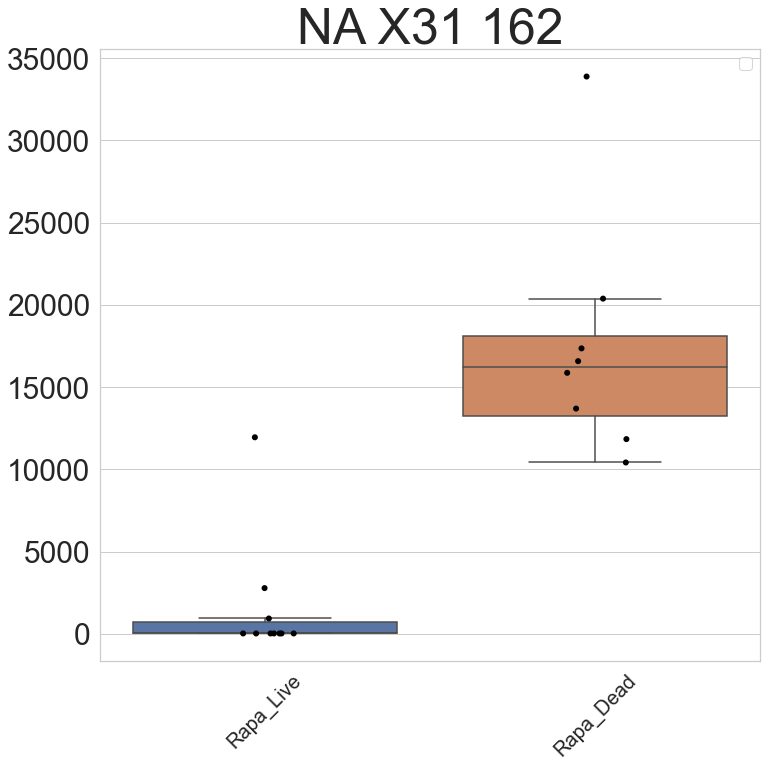

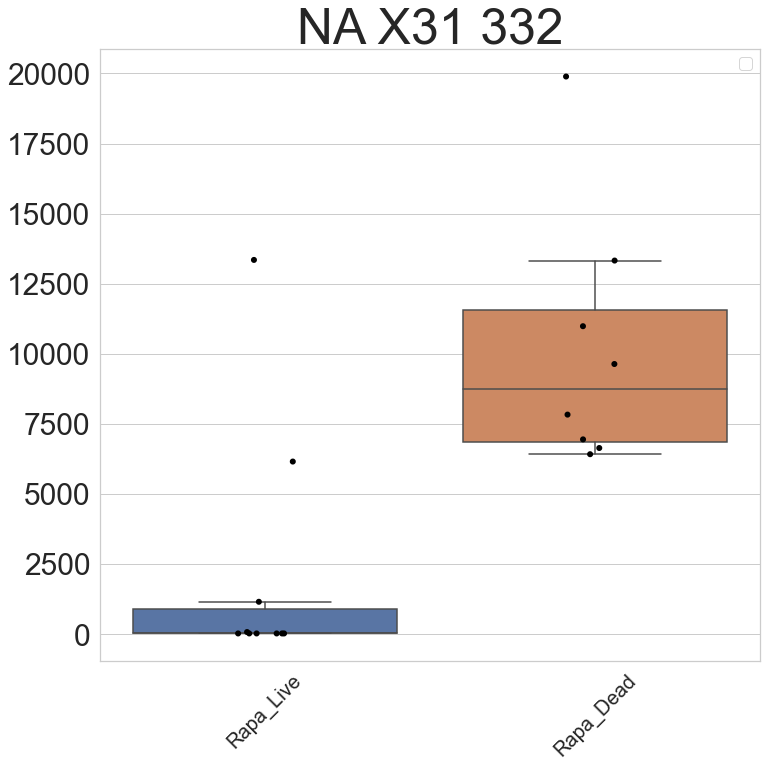

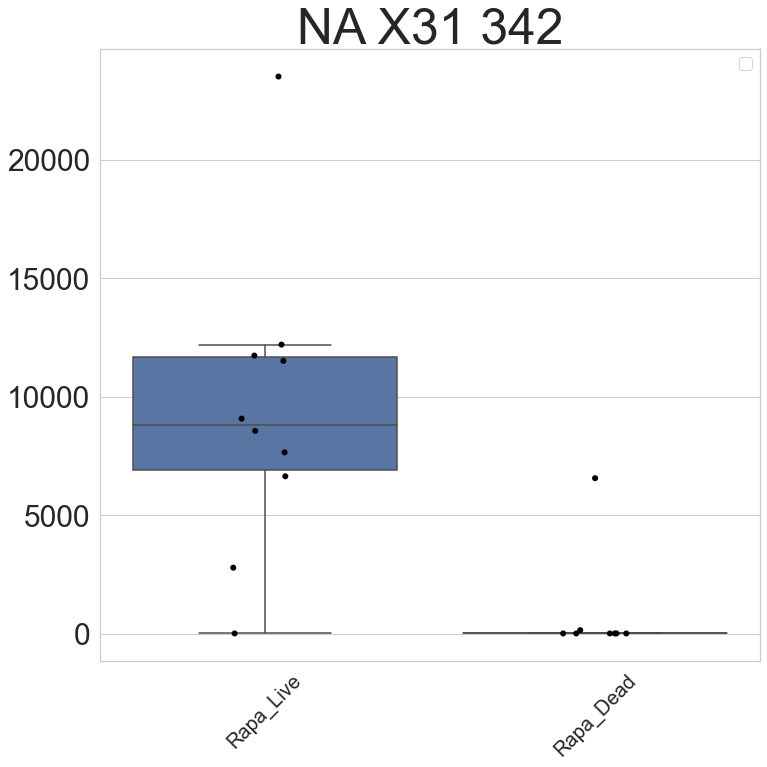

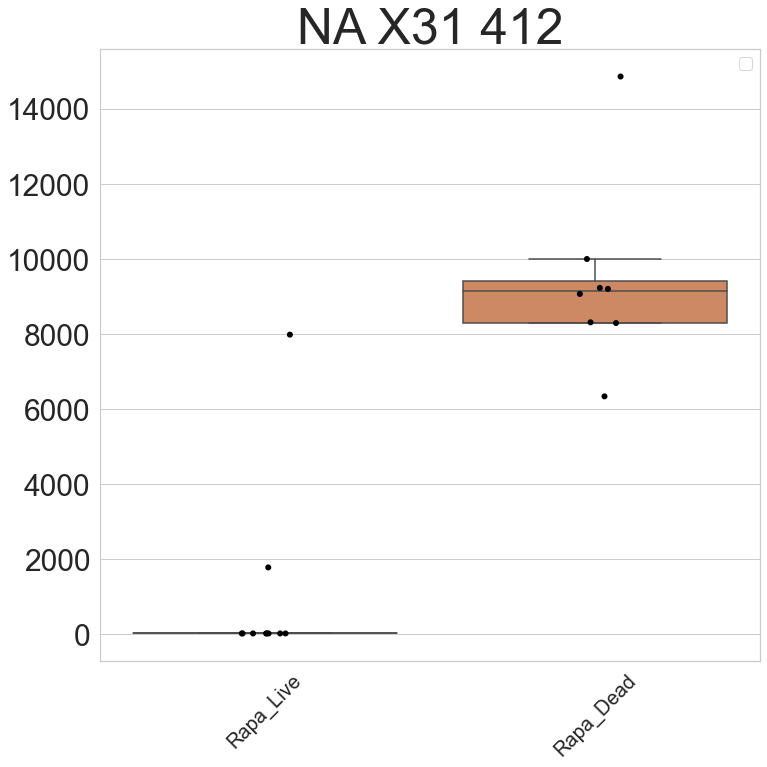

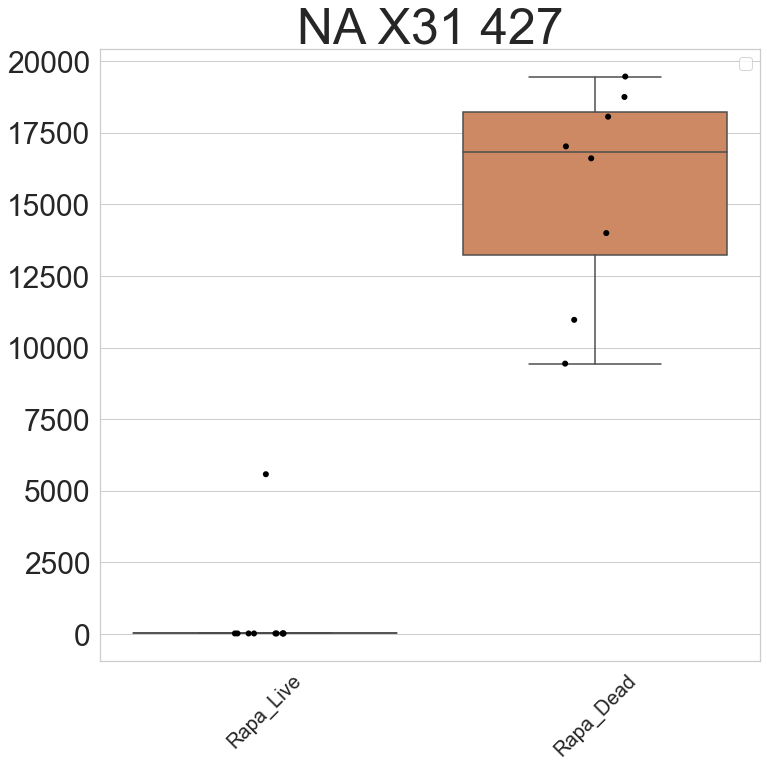

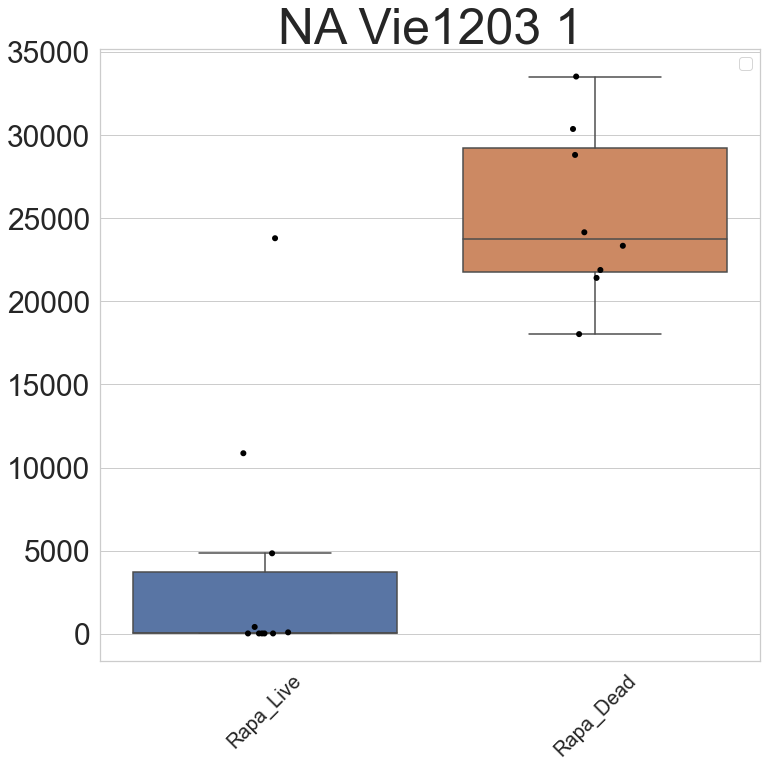

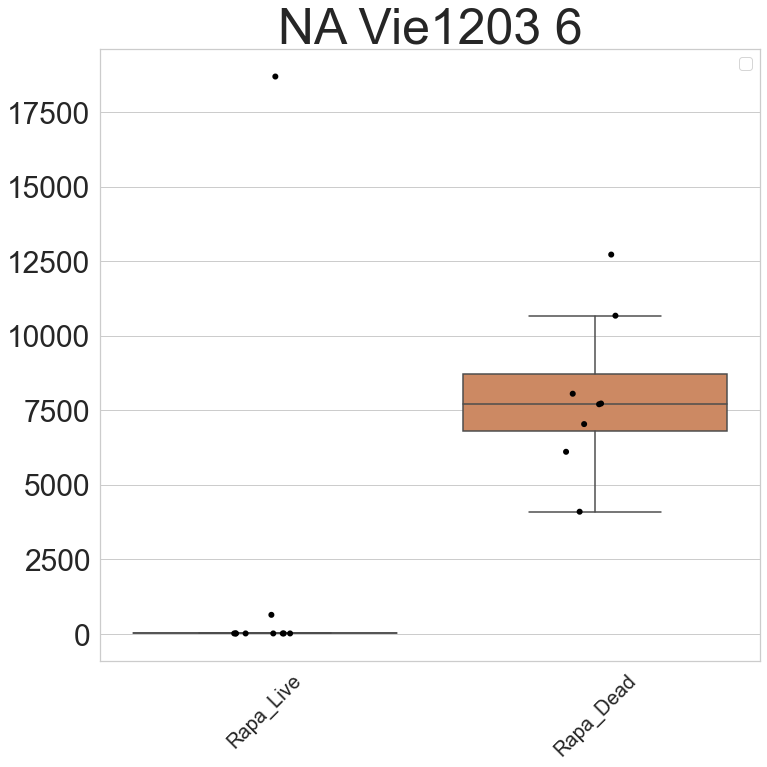

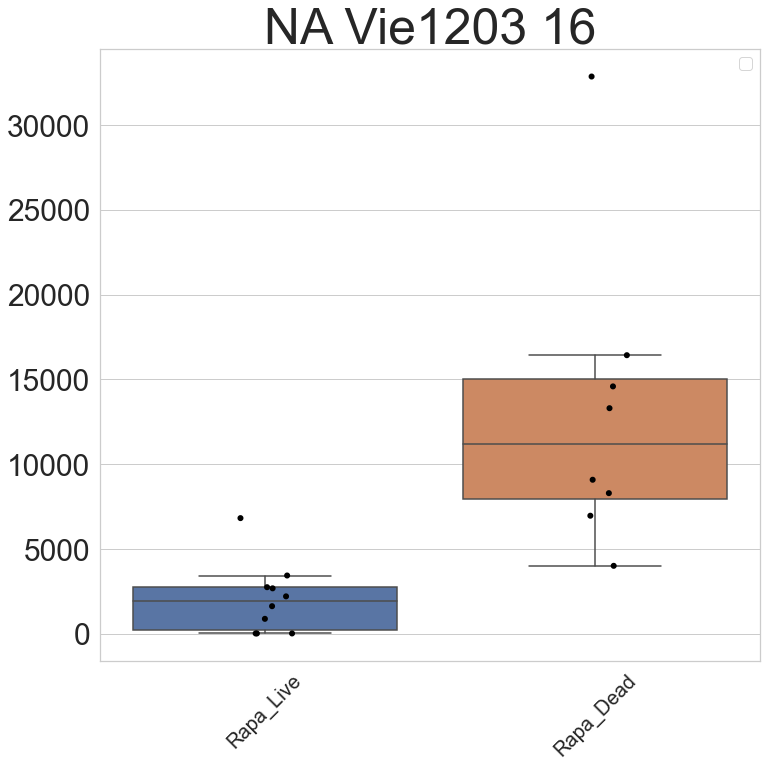

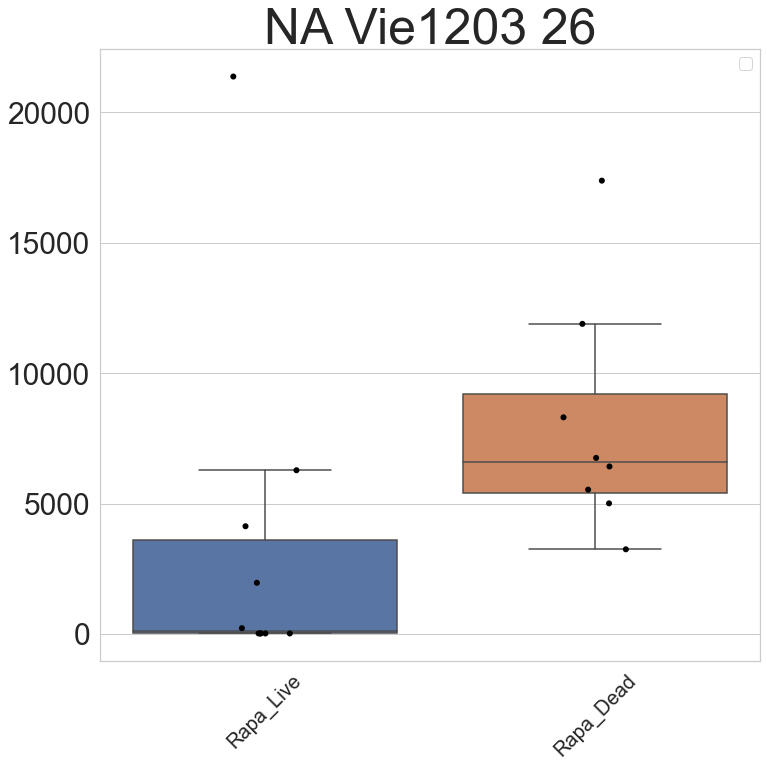

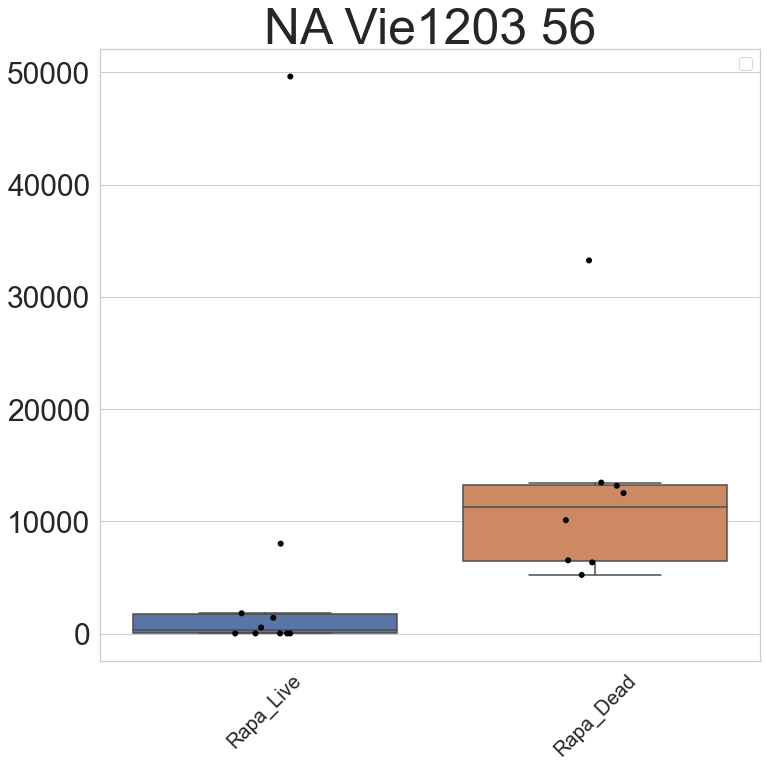

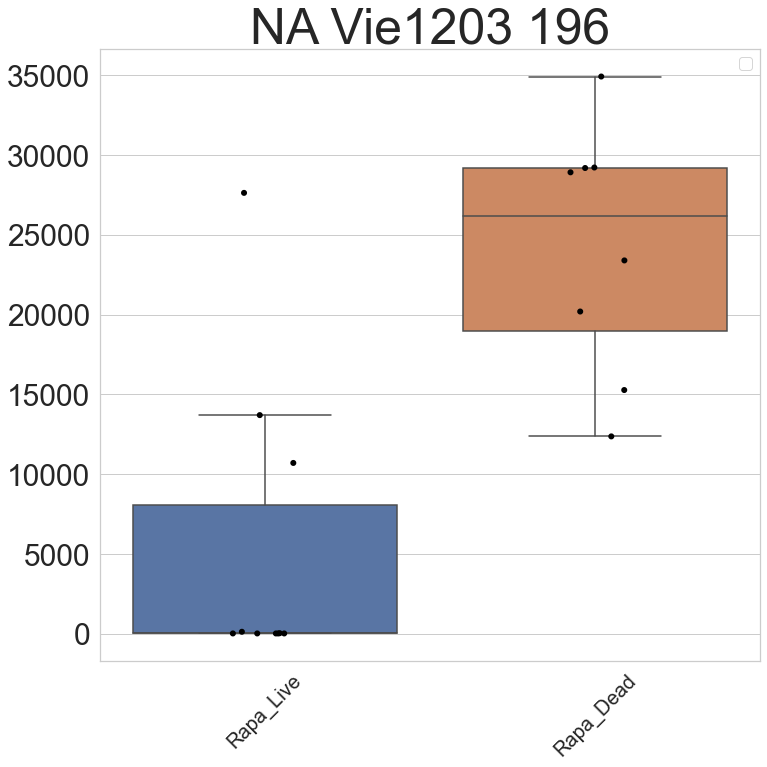

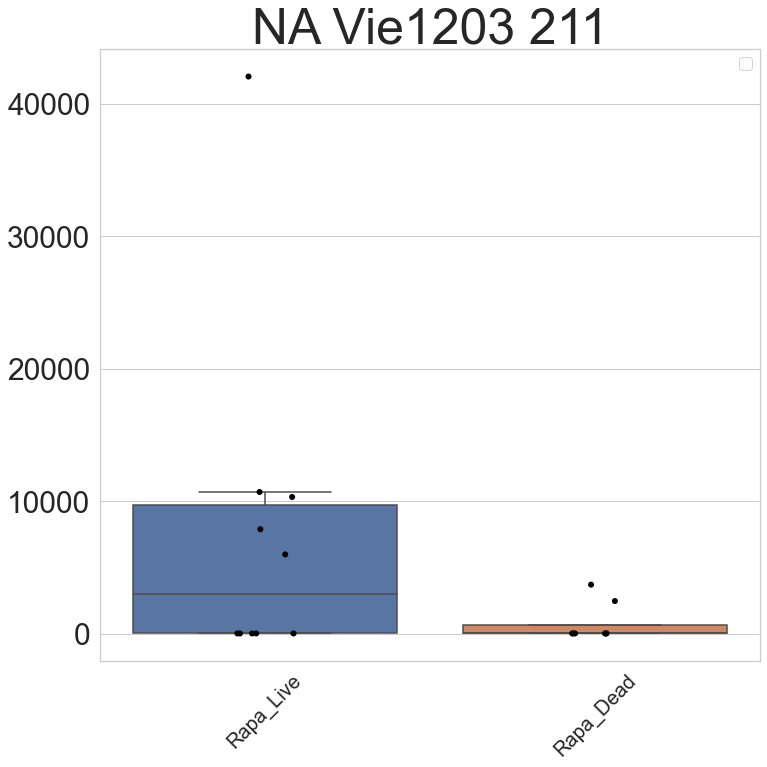

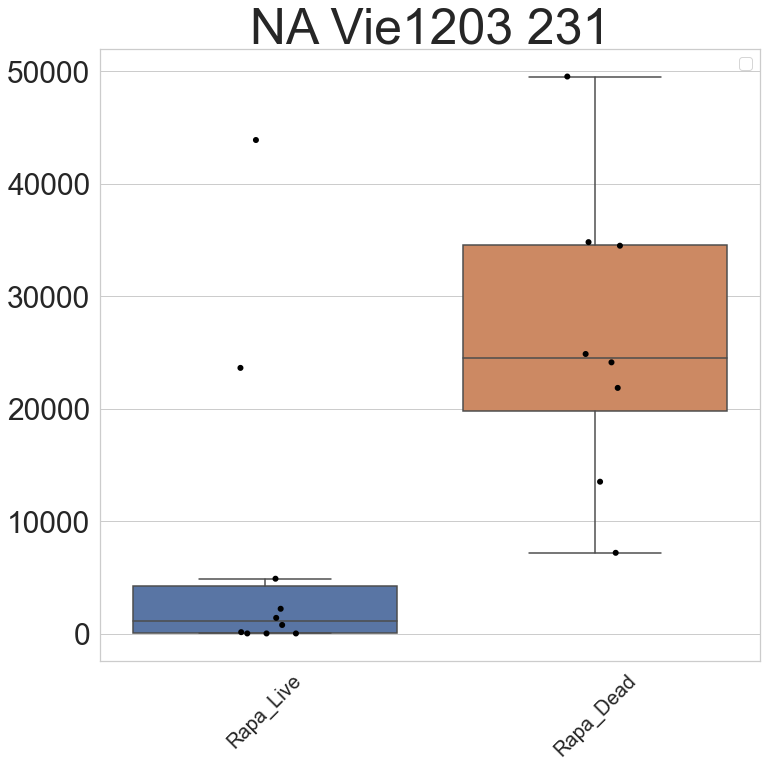

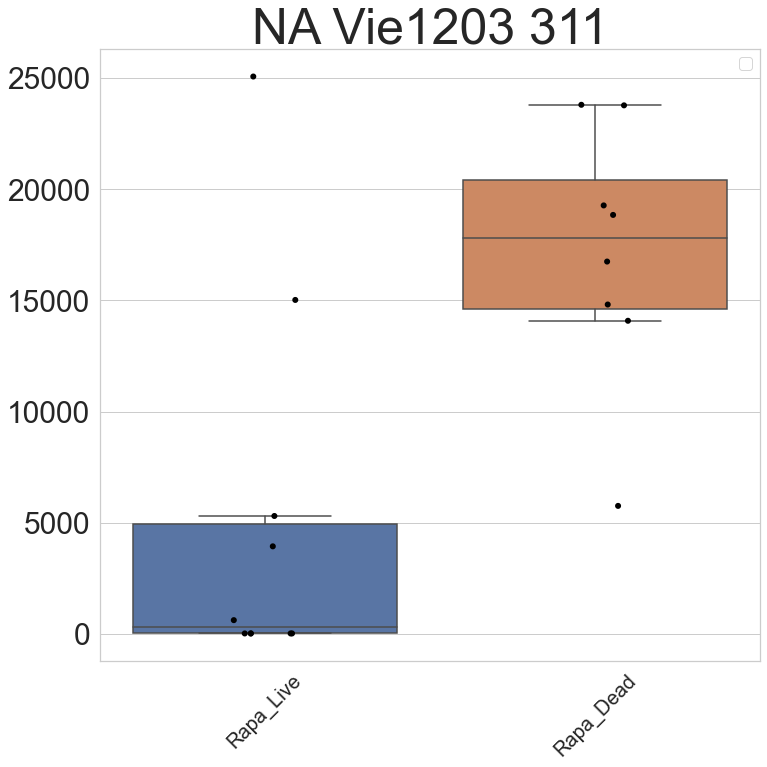

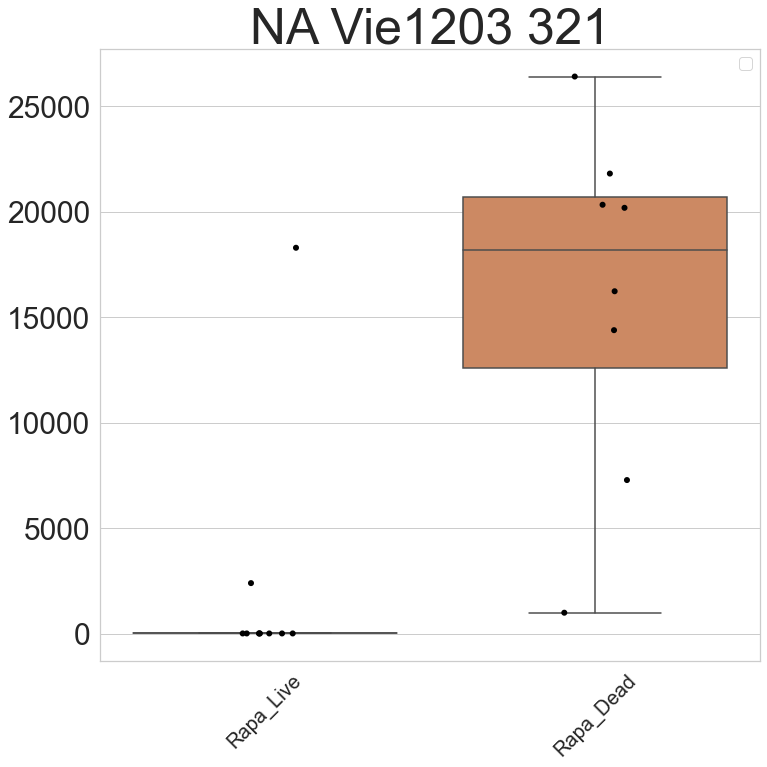

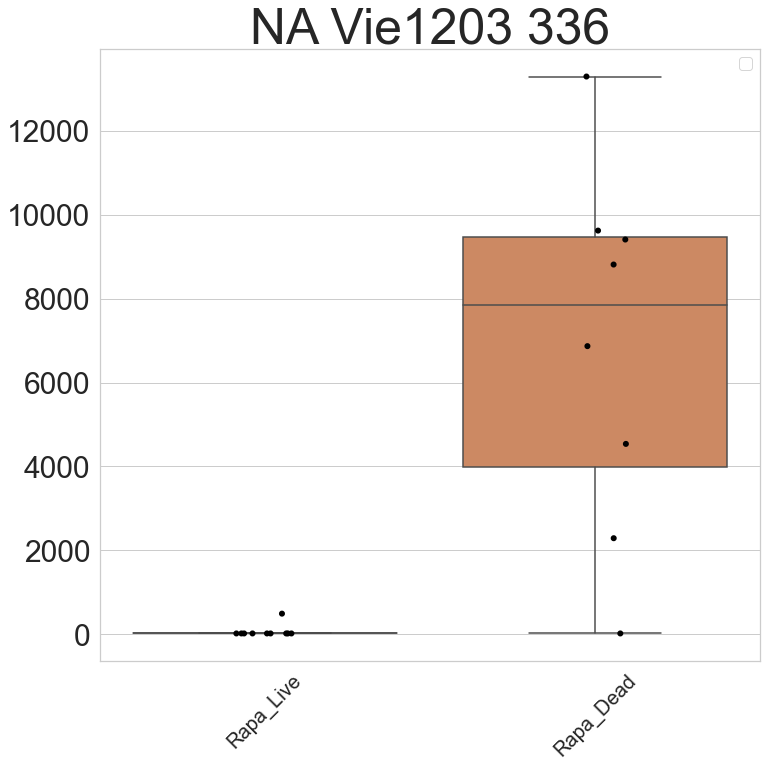

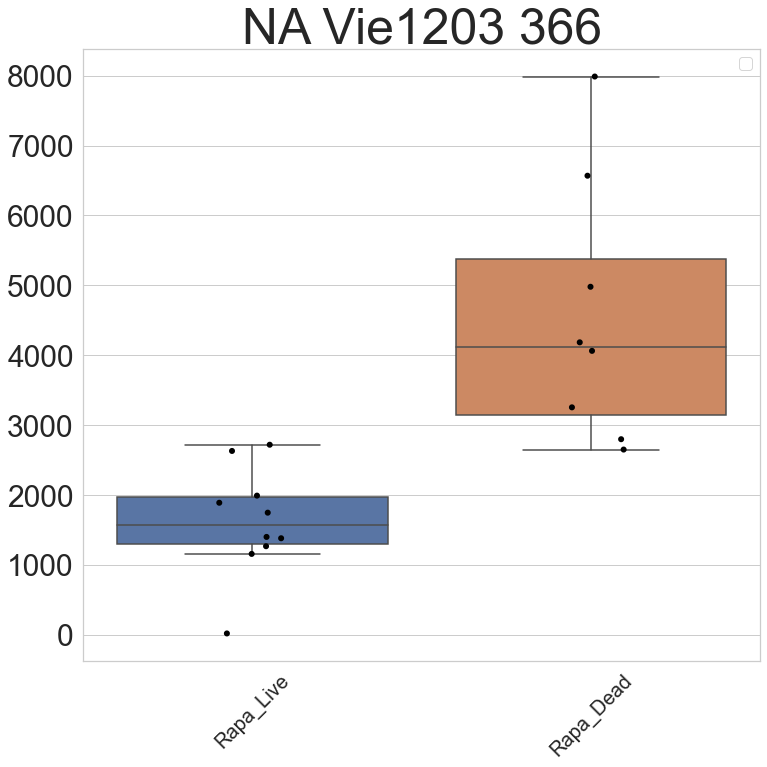

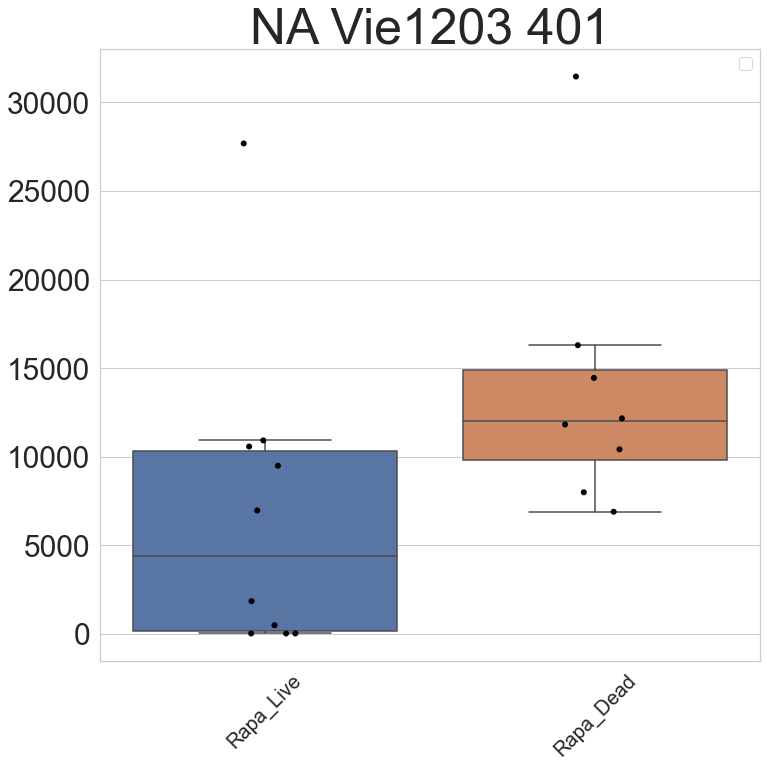

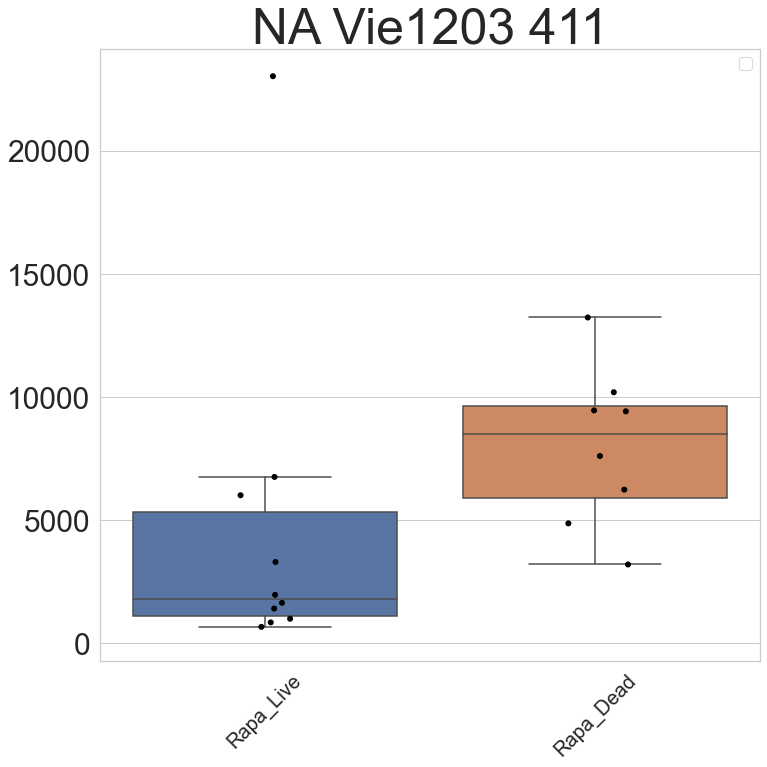

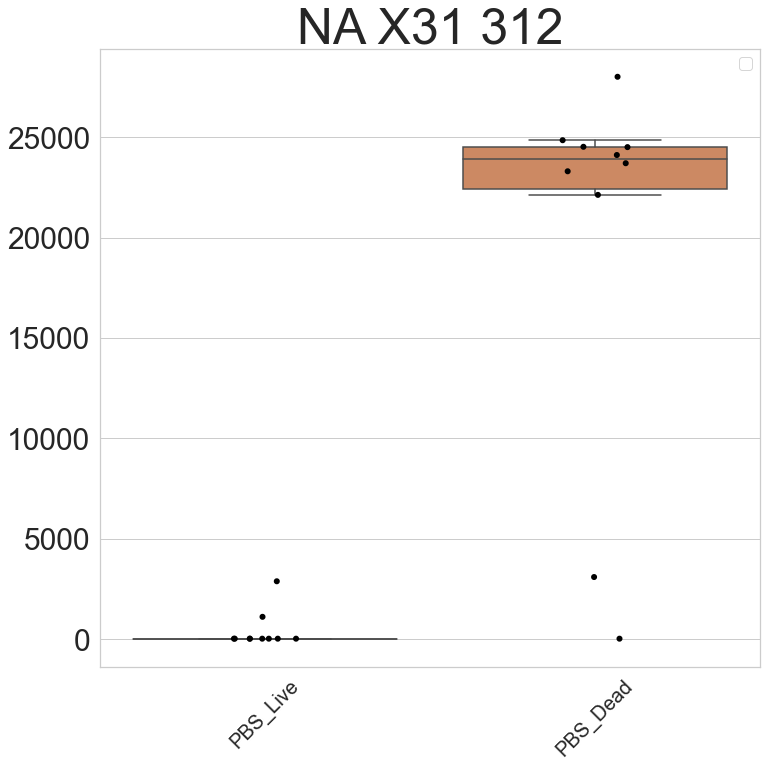

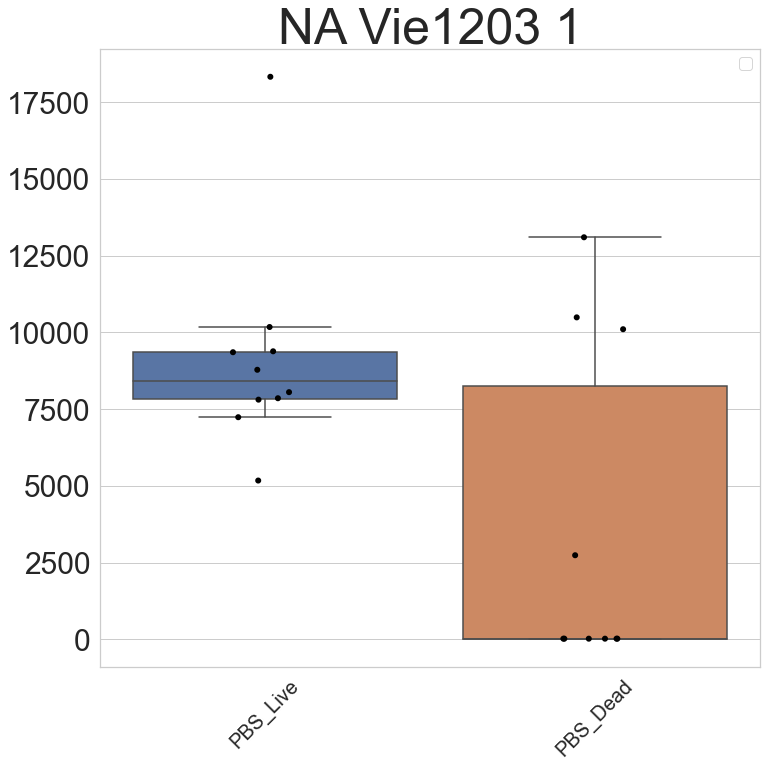

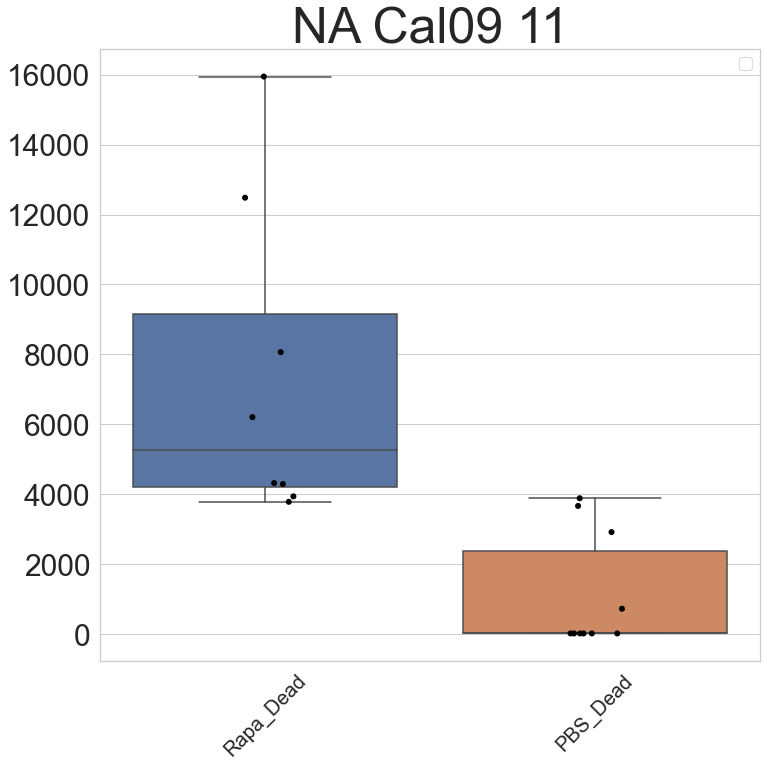

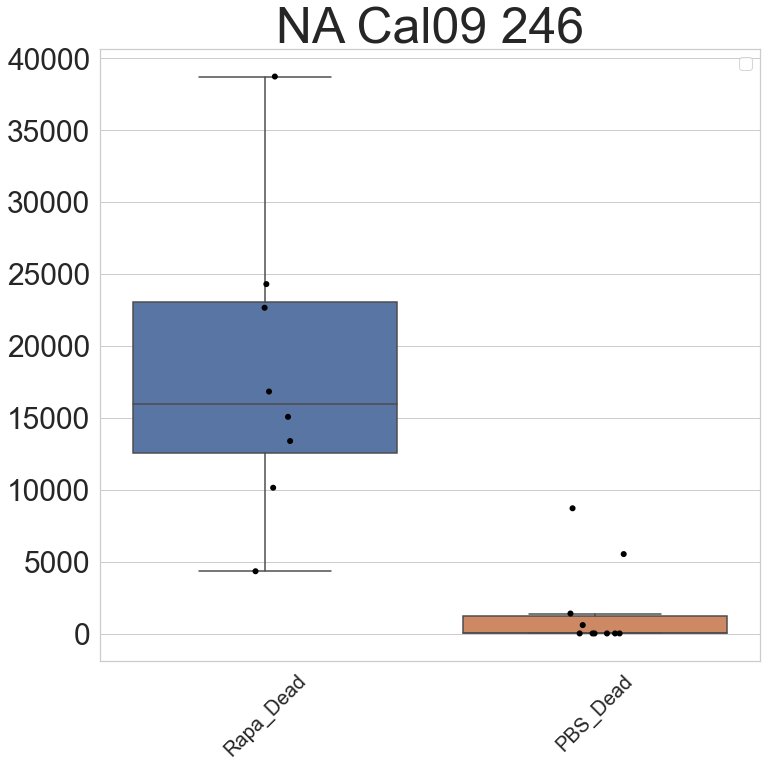

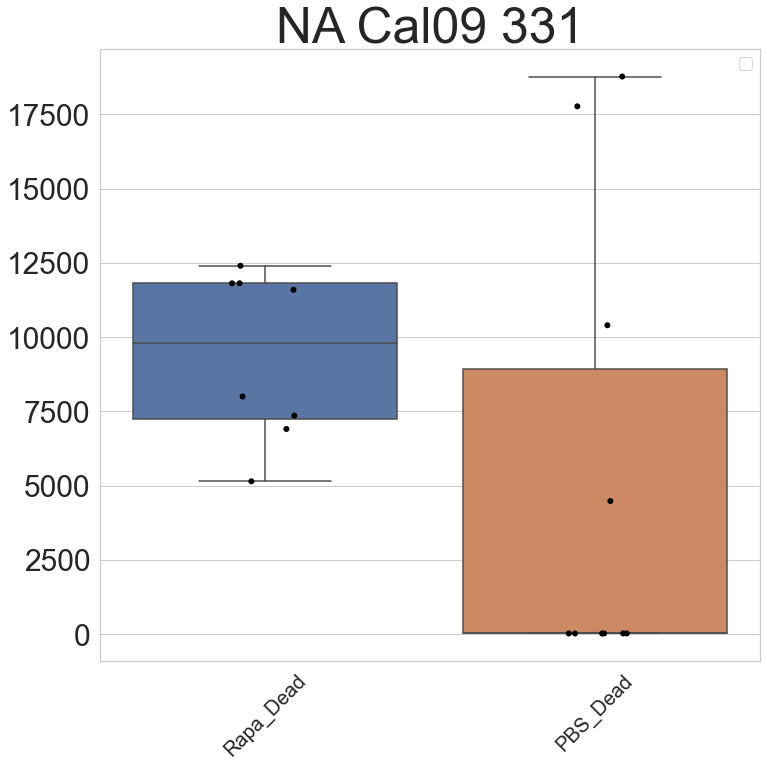

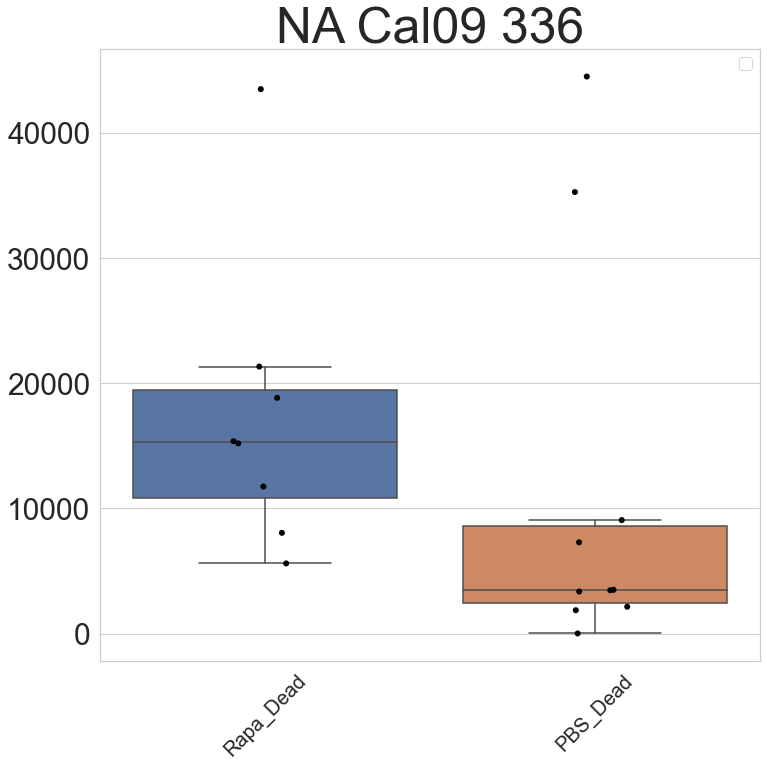

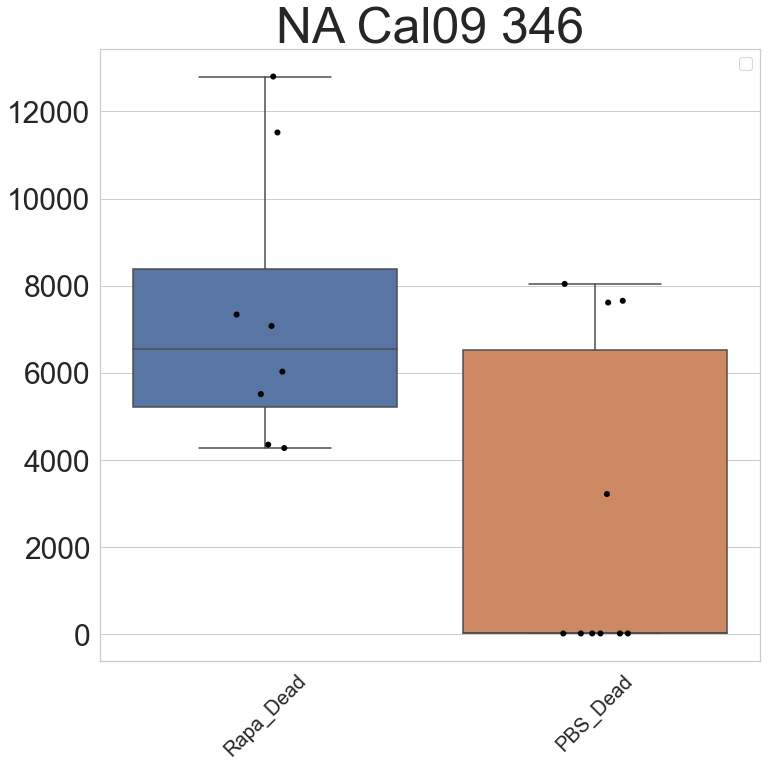

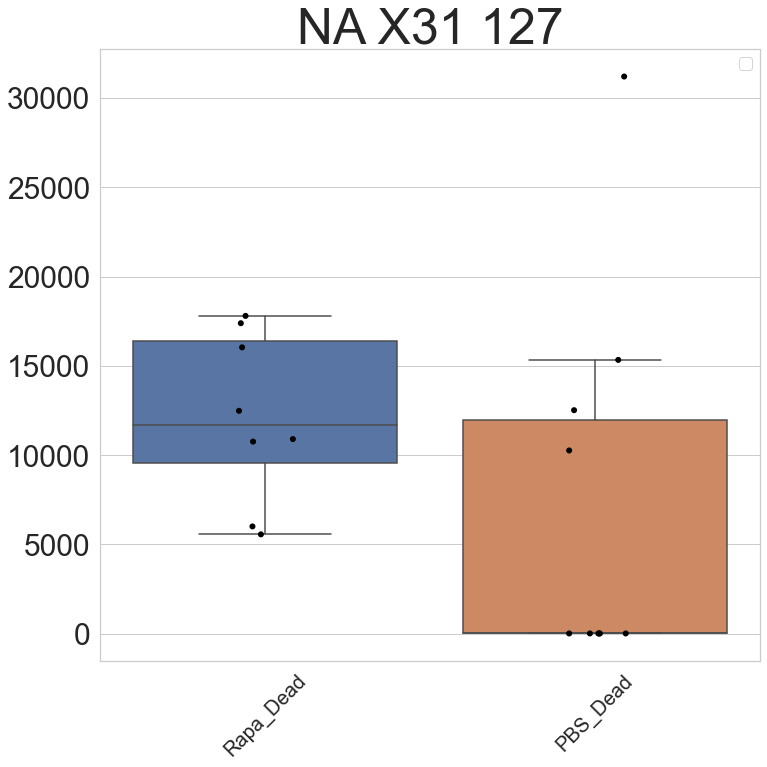

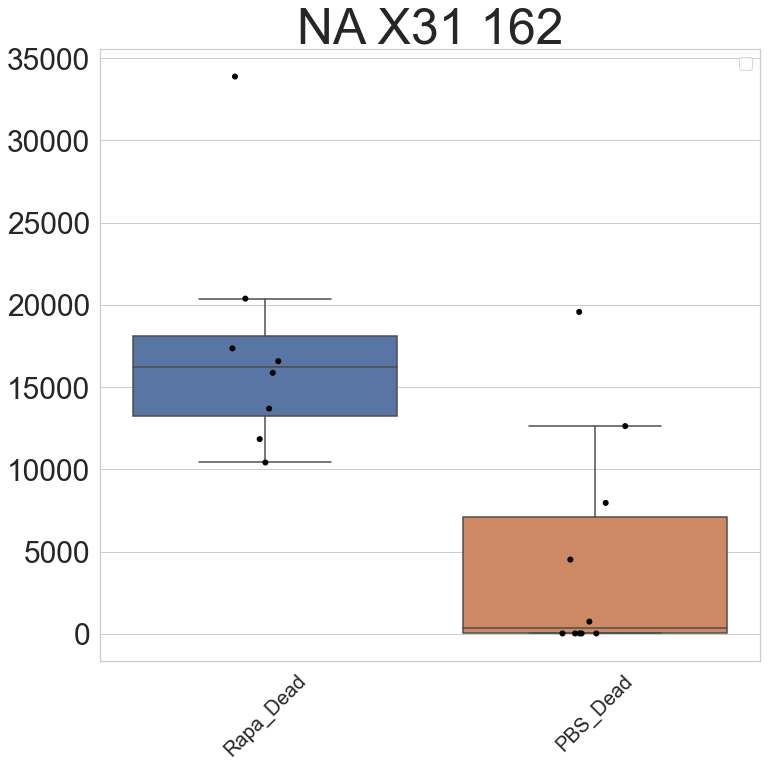

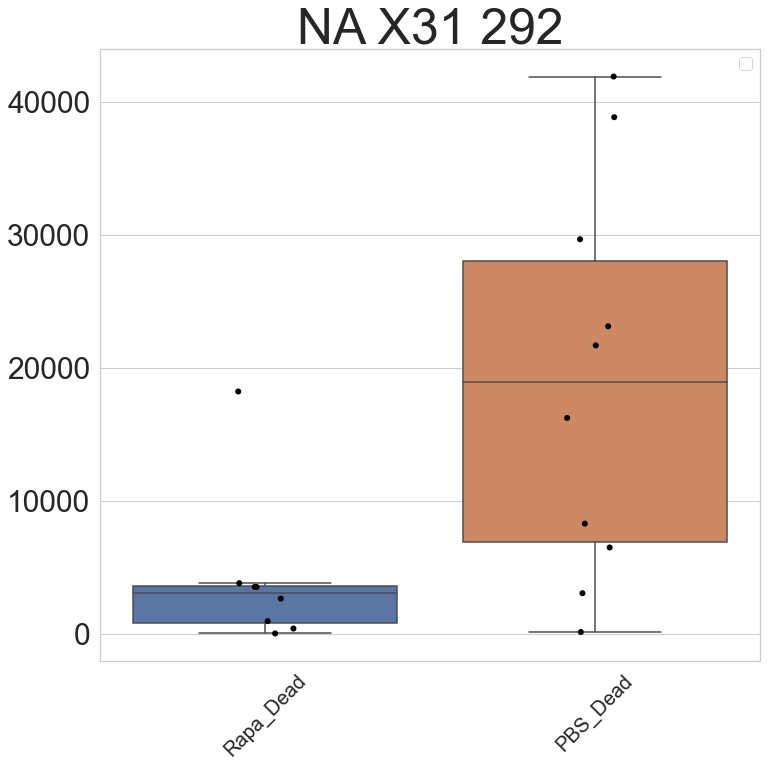

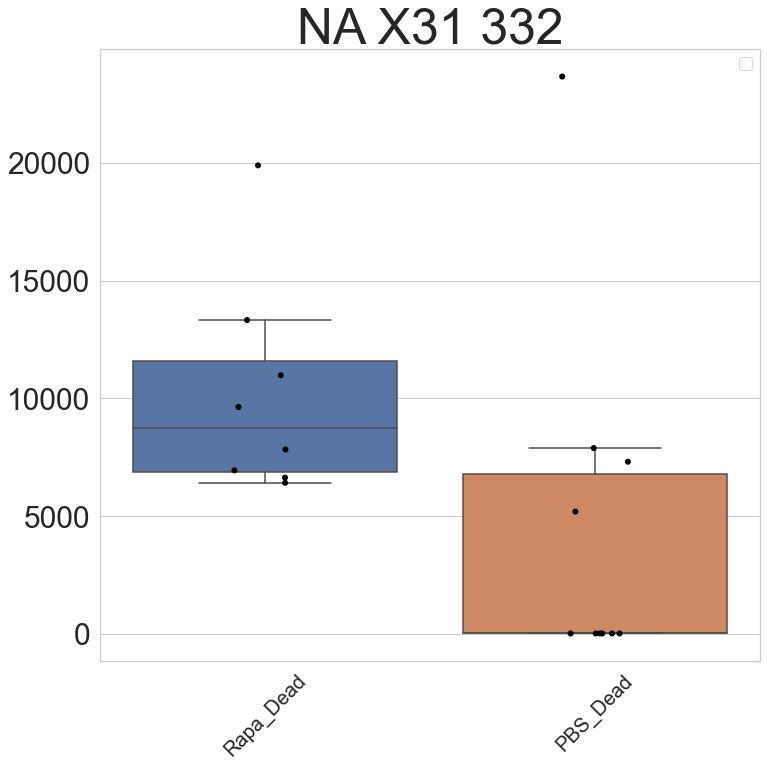

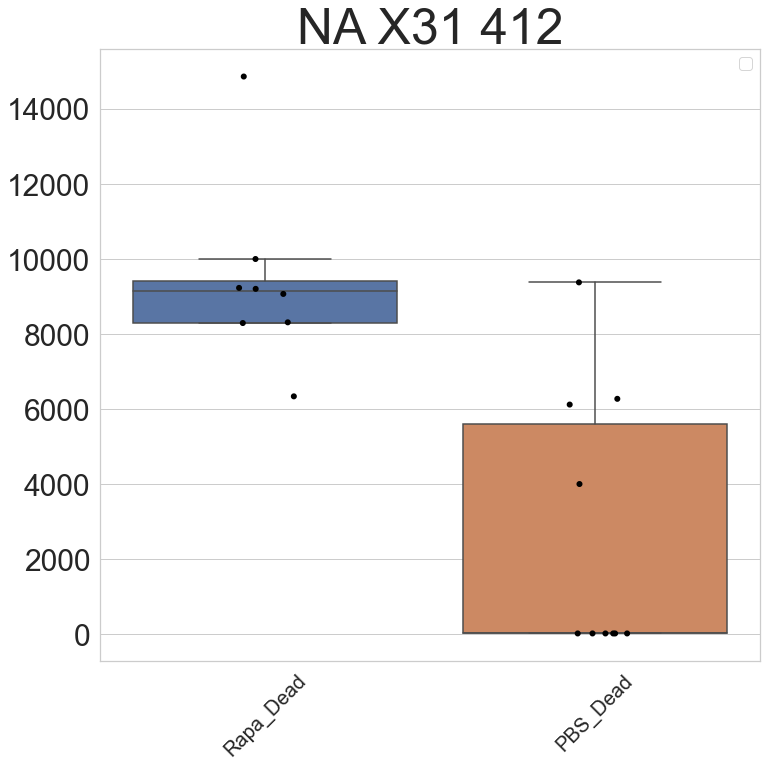

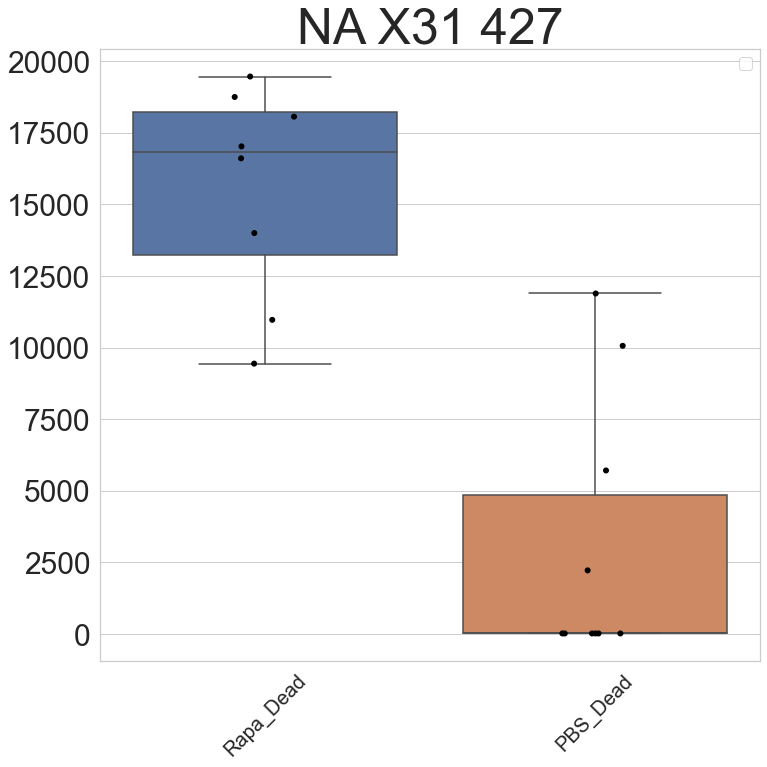

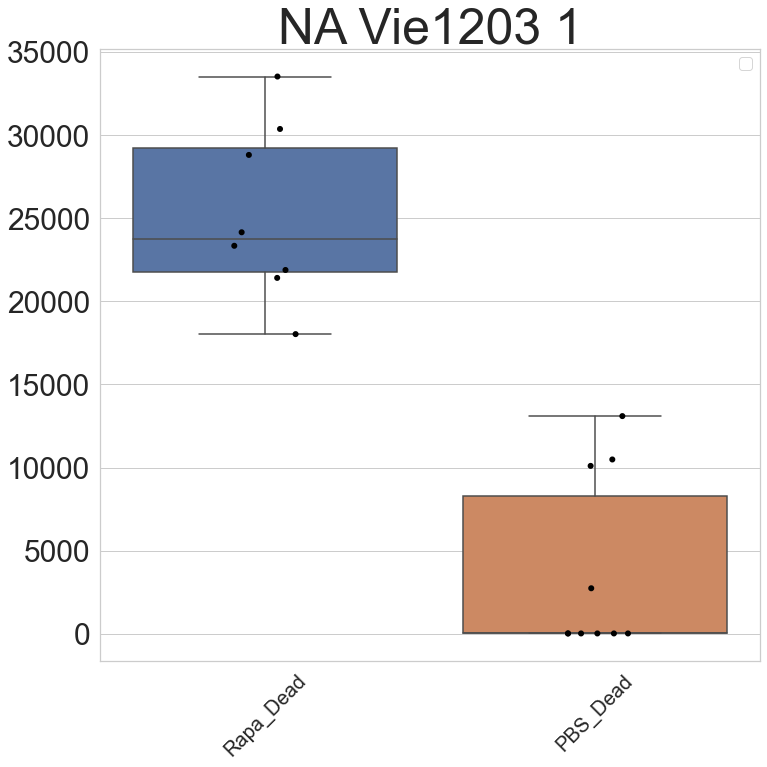

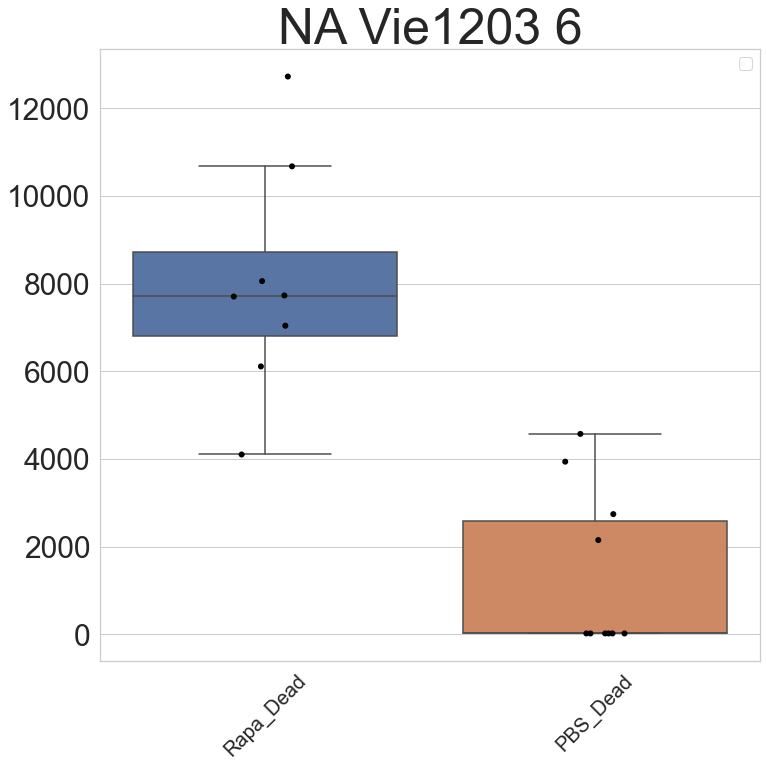

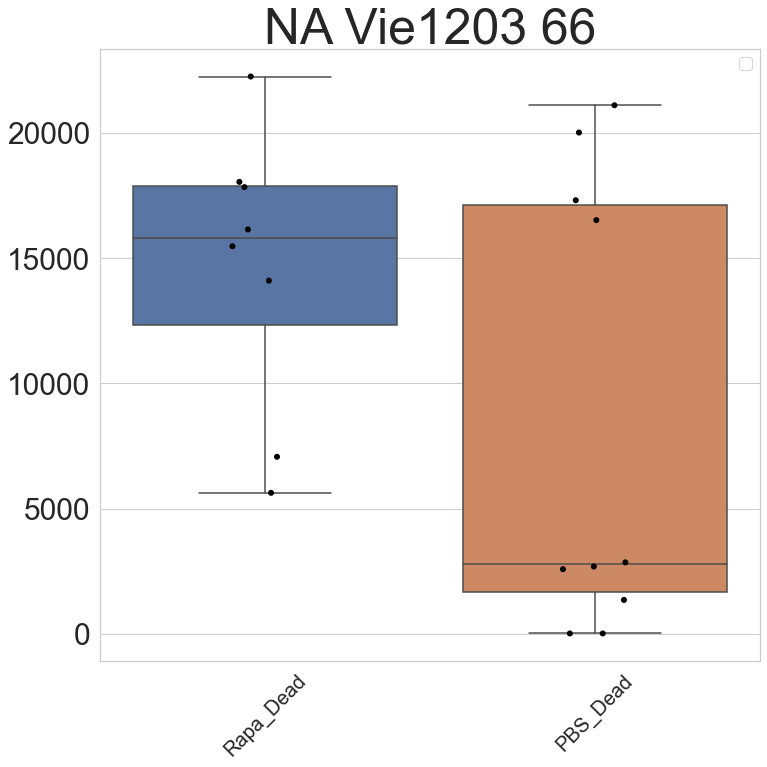

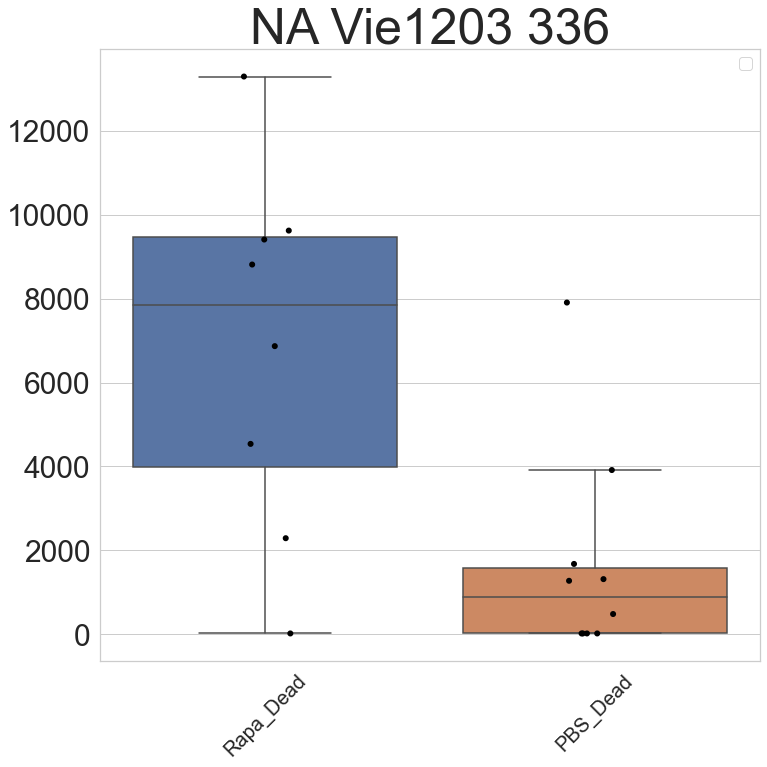

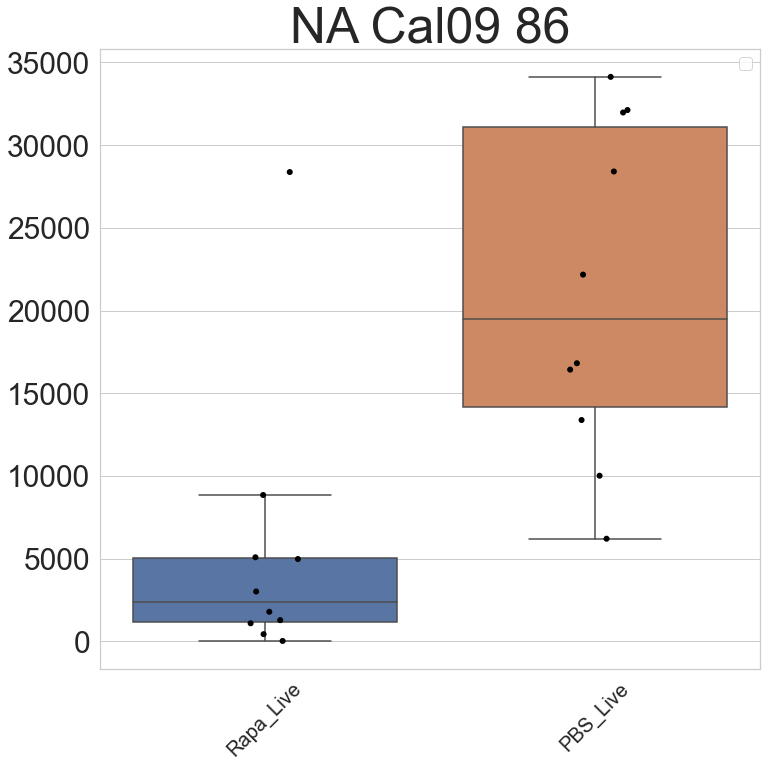

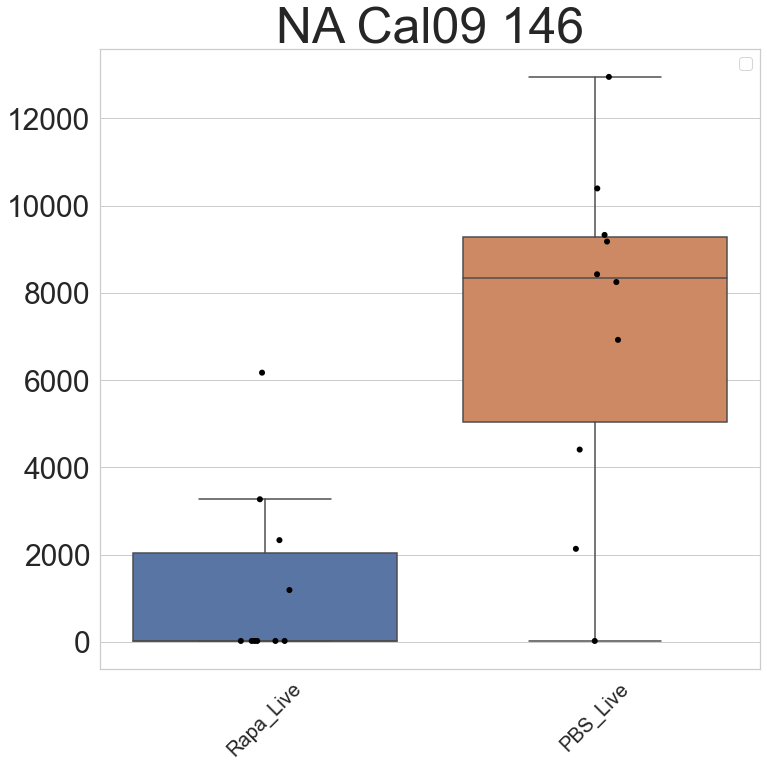

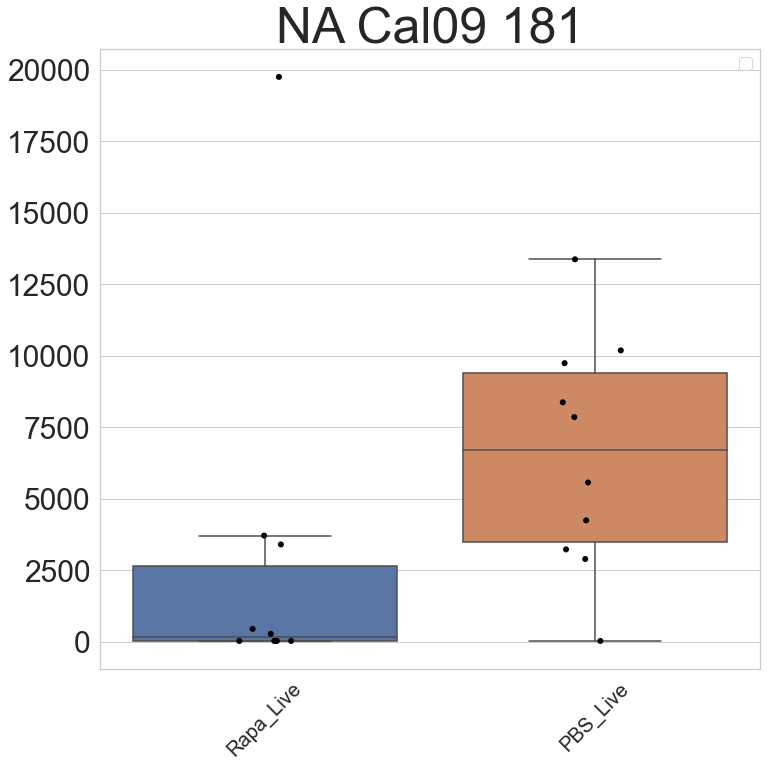

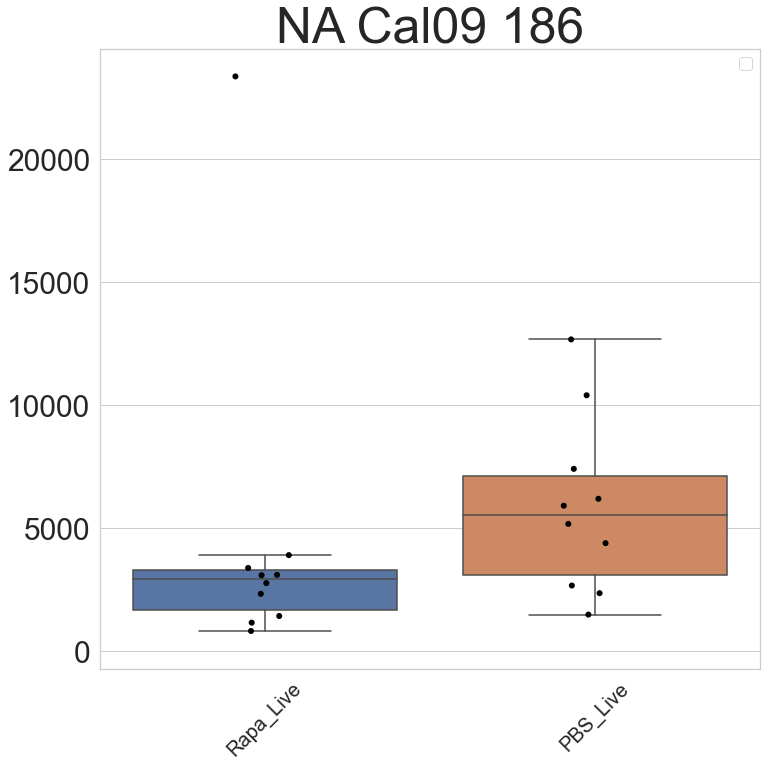

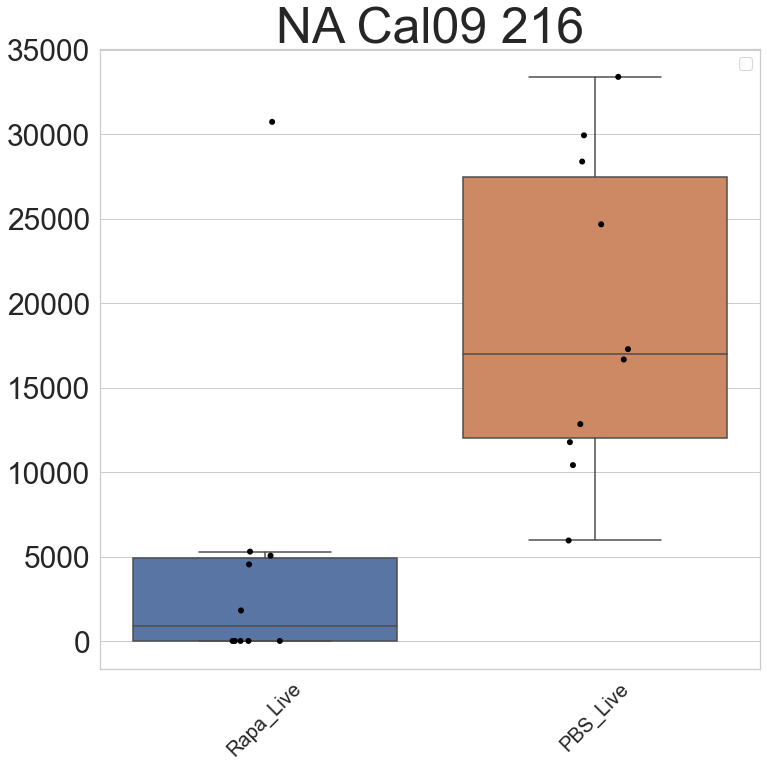

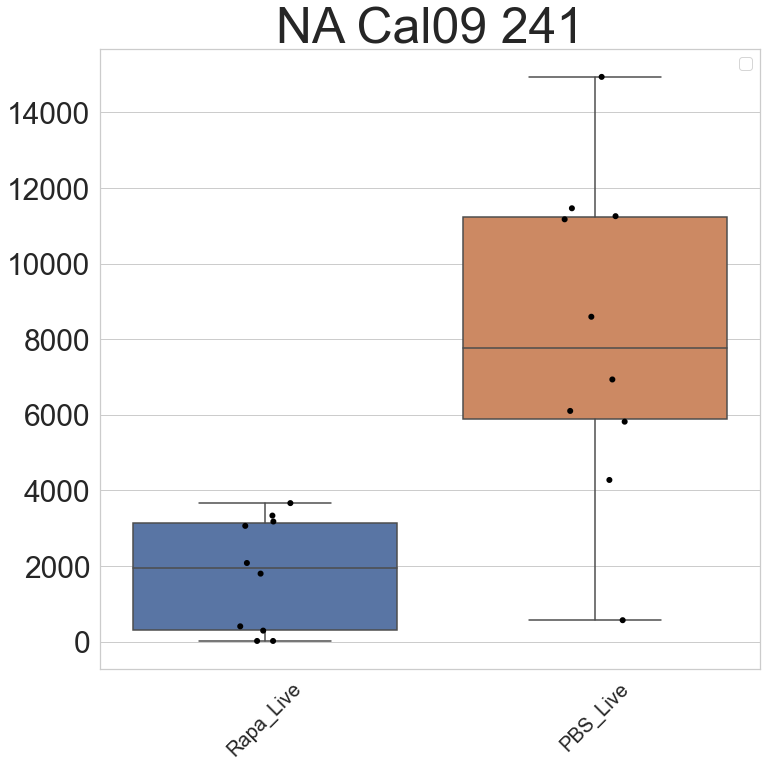

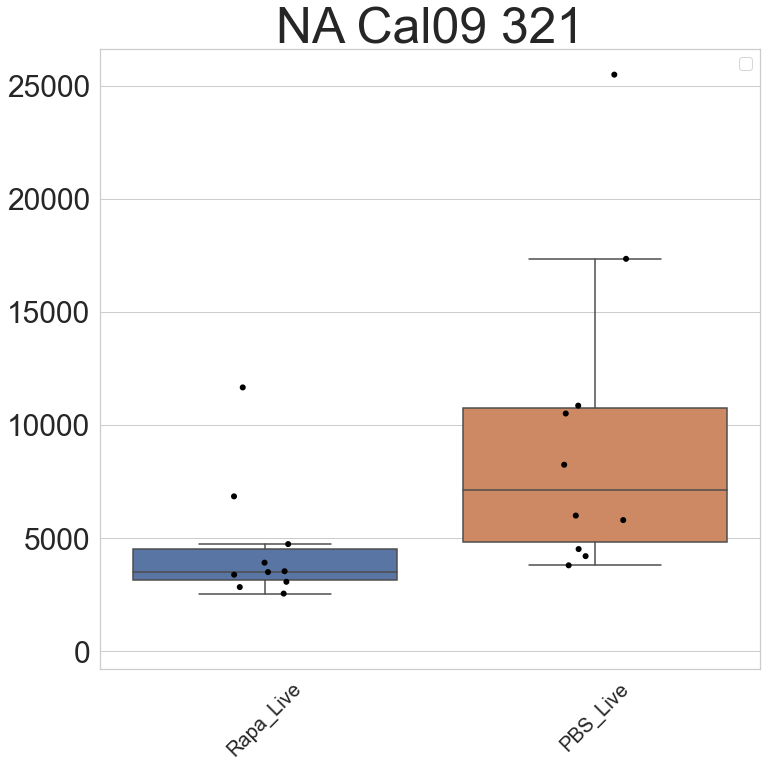

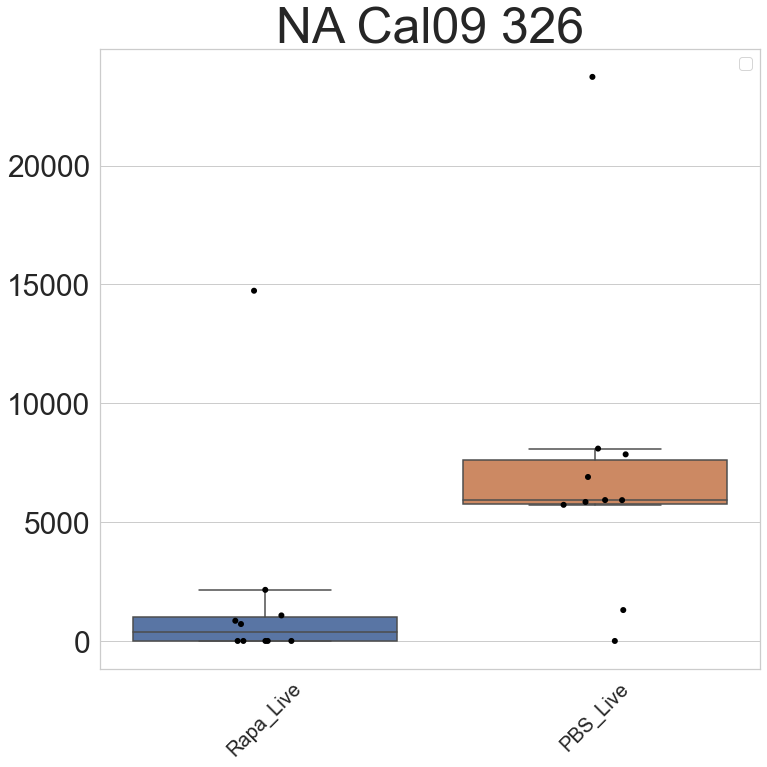

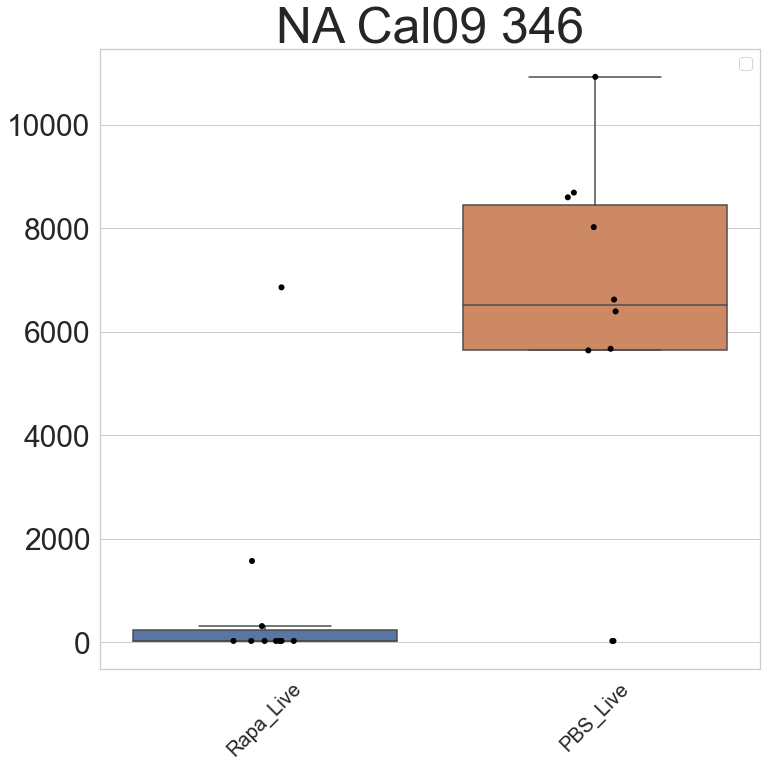

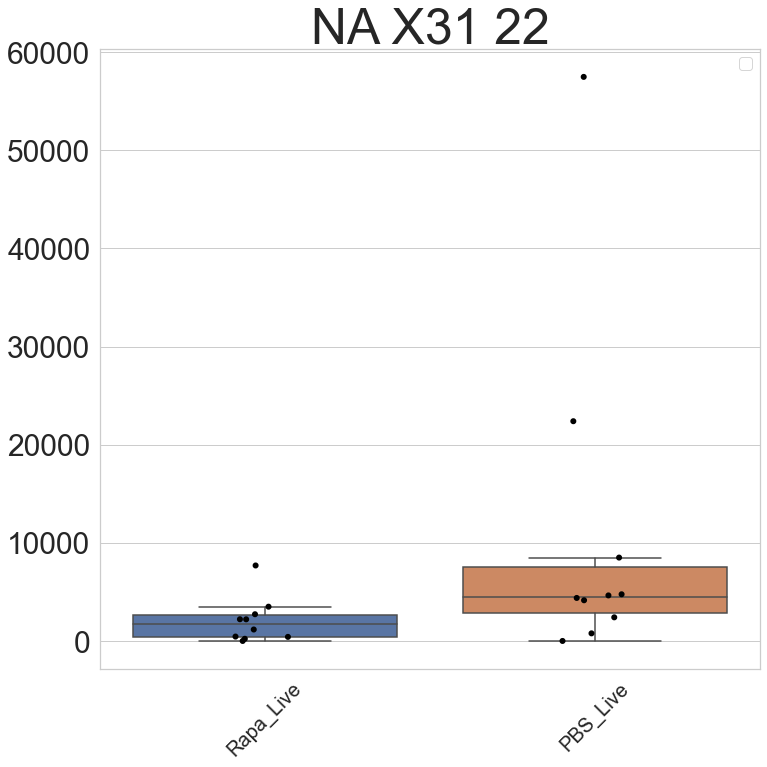

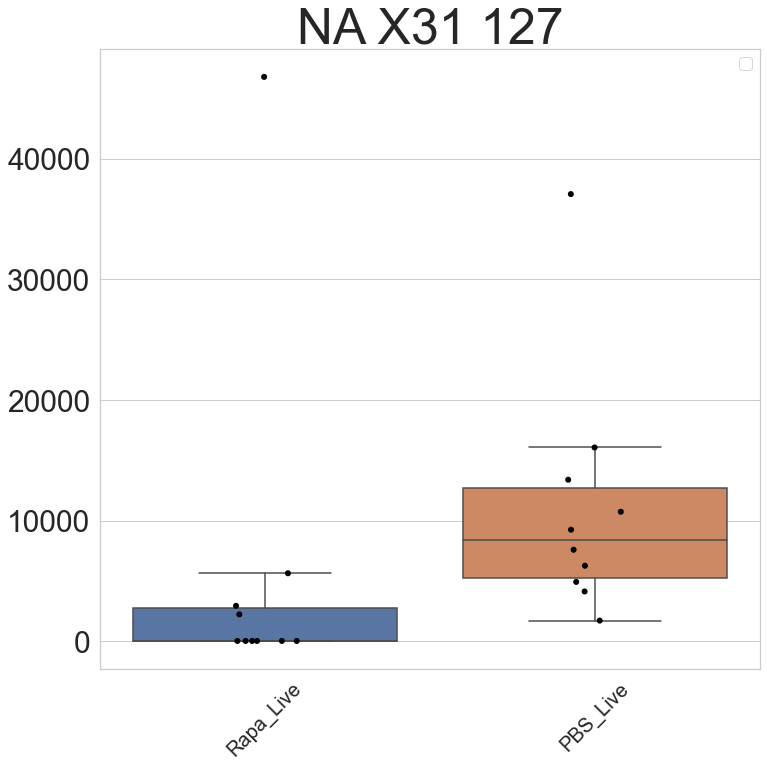

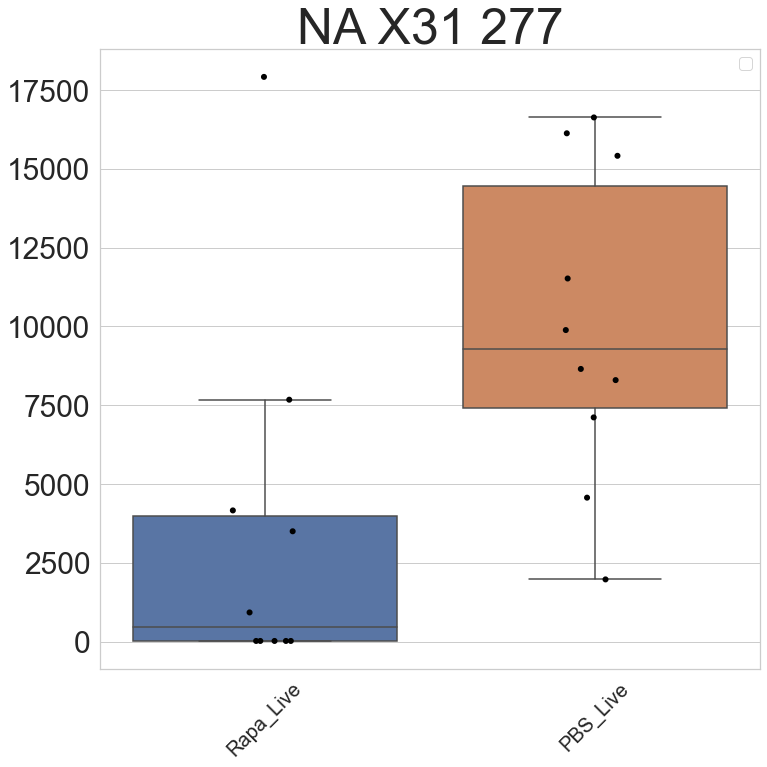

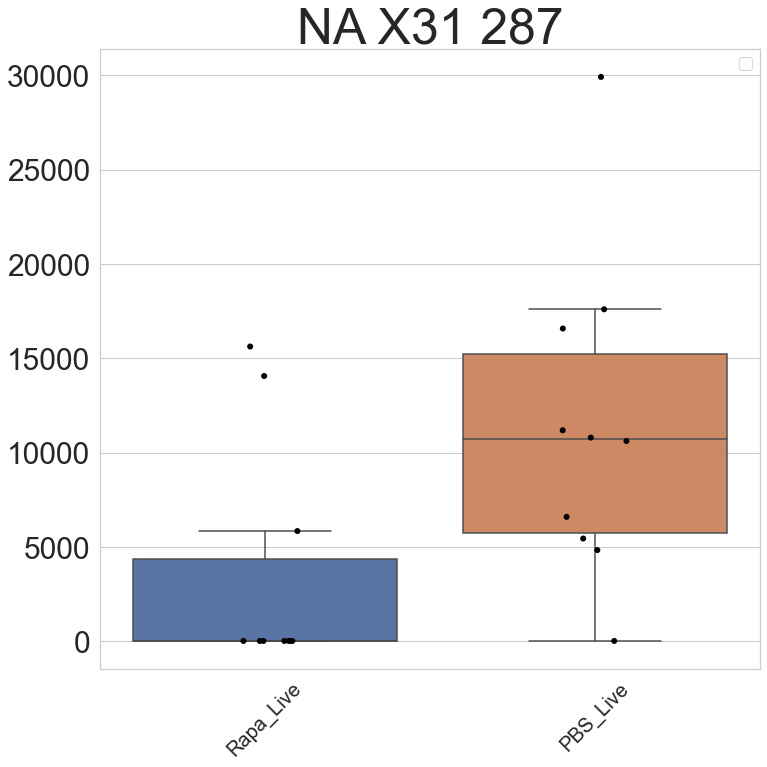

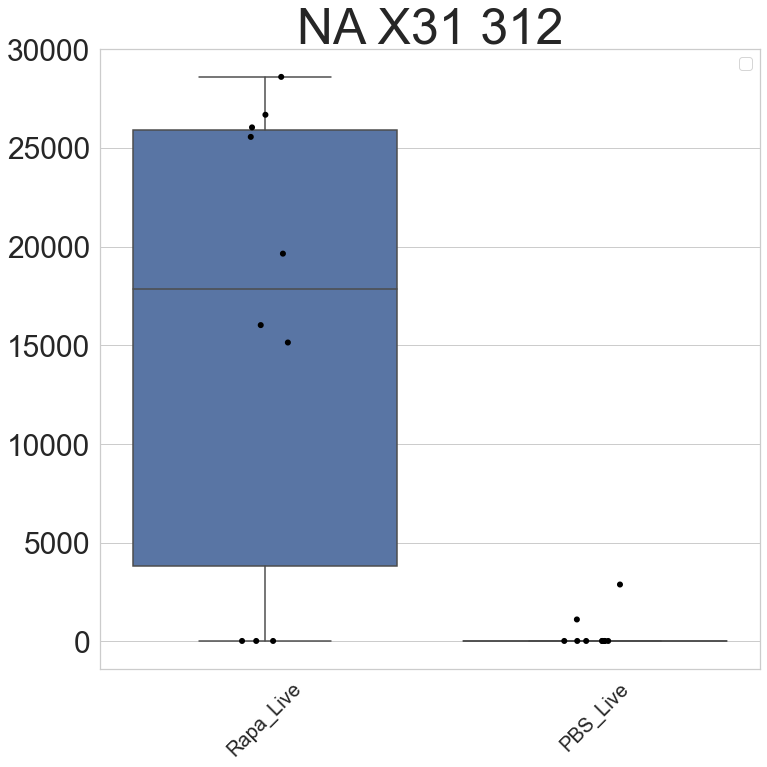

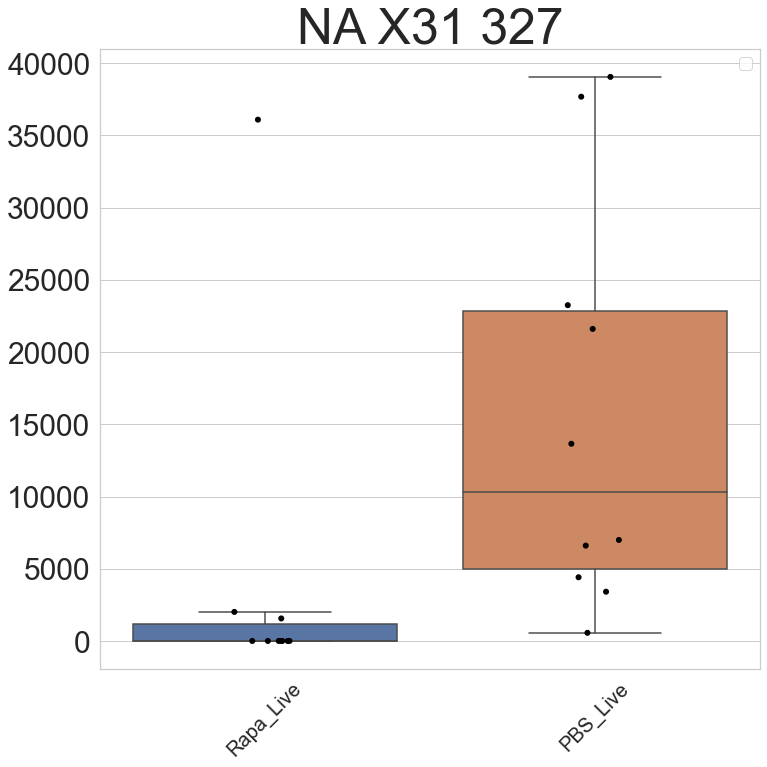

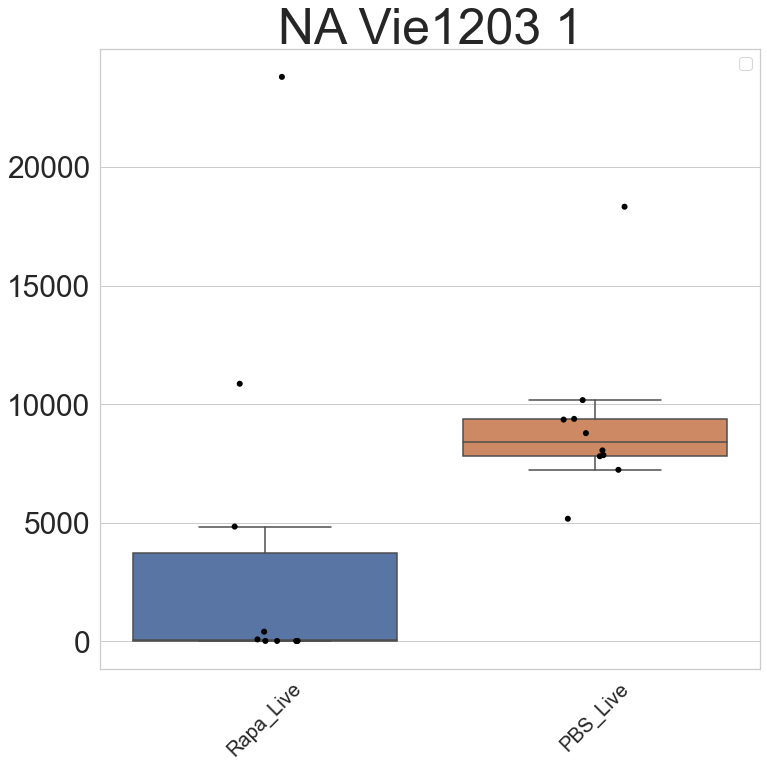

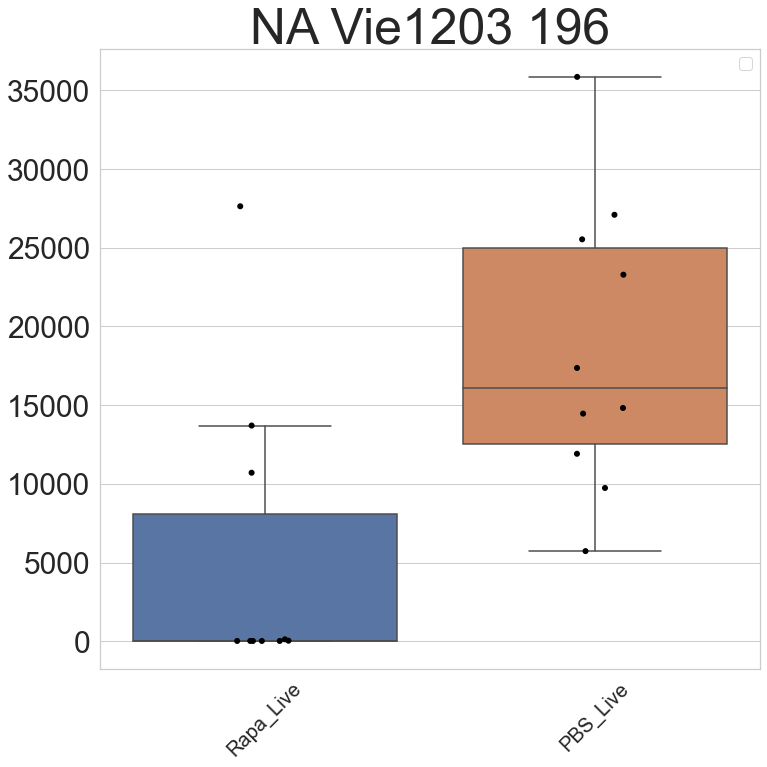

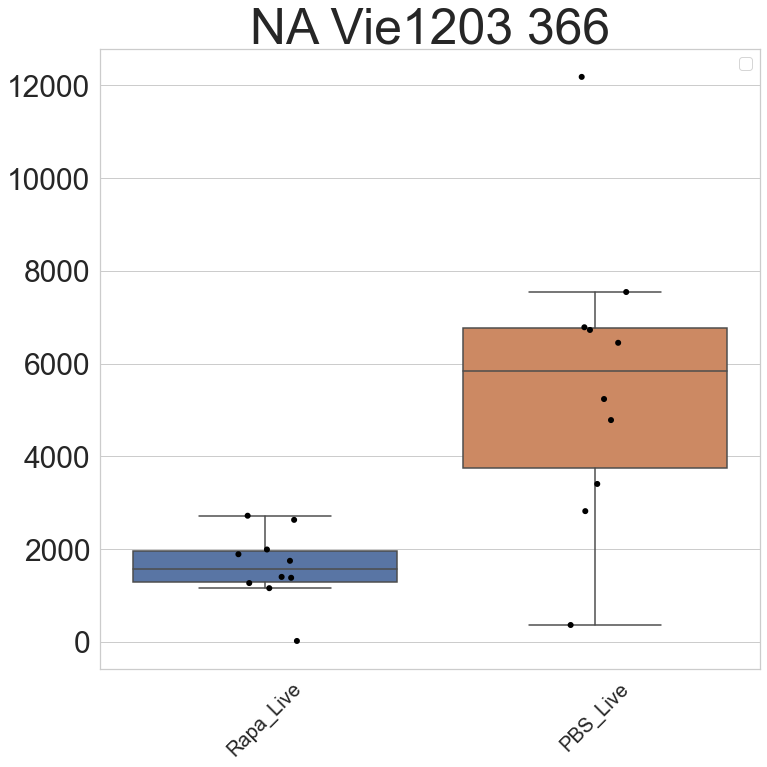

In [294]:
# analyze single antigens:
all_sig_antigens = {} # dictionary of all significant antigens across all comparisons
all_sig_antigens_df = pd.DataFrame(columns=['Antigen', 'Fisher Counts', 'p-value', 'adjusted p-value', 'q-value', 'isotype', 'group_names'])
plot_flag = True
if isotype_name[0] == 'IgM':
    pos_threshold = 4000# selected_threshold # threshold to define a positive response. Set high at this point due to high serum dilution used.
elif isotype_name[0] == 'IgG':
    pos_threshold = 2000# selected_threshold # threshold to define a positive response. Set high at this point due to high serum dilution used.

filter_threshold = 0.3 # precent responders threshold over the entire label-blinded cohort
reject_criteria = 'fdr' # criteria to adjust p-values by. can be 'fdr' (default), or 'bonferonni' (more restrictive)
fdr_threshold = 0.2

#group_names =curr_exp_groups

#filter antigens based on percent responders on post responses only:
filter_dict = amutils.compute_label_blinded_antigen_filters(arr_df, ind_dict, 
                                                                filter_threshold=filter_threshold, pos_threshold=pos_threshold)

for k, antigens in filter_dict.items():
    print('Number of peptides remaining for comparisons after blinded filtering for {0} is {1}'.format(k, len(antigens)))

print('\n')

for group_names in [ ('Rapa_Live', 'Rapa_Dead'), ('PBS_Live', 'PBS_Dead'), ('Rapa_Dead', 'PBS_Dead'), ('Rapa_Live', 'PBS_Live')]:
   
    curr_inds = group_inds[group_names[0]].append(group_inds[group_names[1]])

    #filter antigens based on percent responders on post responses only:
    # significant_antigens = {}
    # significant_antigen_stats = {}

    significant_antigens, significant_antigen_stats, sig_antigen_lists = \
        amutils.compare_single_antigens_by_groups(arr_df=arr_df.loc[curr_inds], group_names = group_names, 
                                                          antigen_filters=filter_dict,
                                                        pos_threshold=pos_threshold, group_column='group', 
                                                          reject_criteria=reject_criteria,
                                                        fdr_threshold=fdr_threshold)  
    # save all sig antigen names:
    all_sig_antigens[group_names] = sig_antigen_lists
    # now generate dataframes for sig antigens from proteins of interest:
    if FIG_PATH is not None:
        sig_antigens_filename= "".join([FIG_PATH, project_name, isotype_name[0], 'peptide_sig_antigen_stats_', group_names[0], '_vs_', group_names[1], '_th_', str(pos_threshold), '_filter_th_', str(filter_threshold), '.xlsx']) 
        writer = pd.ExcelWriter(sig_antigens_filename)
    for p, p_name in zip(prot_names, prot_strs):
        sig_antigens_df = pd.DataFrame(significant_antigens[p], columns=['Antigen', 'Fisher Counts', 'p-value', 'adjusted p-value', 'q-value'])
        if not sig_antigens_df.empty:
            sig_antigens_df.loc[:, 'isotype'] = isotype_name[0]
            sig_antigens_df.loc[:, 'group_names']= group_names[0] + ' vs. ' + group_names[1]
            all_sig_antigens_df = all_sig_antigens_df.append(sig_antigens_df)

        print('Results for comparisons of group {0} to group {1} for {2}'.format(group_names[0], group_names[1], p_name))
        print('-------------------------------------------------')
        display(sig_antigens_df)
        print('\n')
        if FIG_PATH is not None:
            sig_antigens_df.to_excel(writer, sheet_name=p_name)
    if FIG_PATH is not None:
        writer.save()
        
    # plot significant antigens
    if plot_flag:
        for prot in prot_names:
            curr_antigens = [a[0] for a in significant_antigens[prot]] 
            curr_antigen_names = [a.replace('_', ' ') for a in curr_antigens]
            # currently not working....
            # amp.plot_antigen_bar_plots_by_groups(arr_df=arr_df, antigens=curr_antigens, 
            #                                      group_names=exp_groups, 
            #                                      antigen_names=curr_antigen_names, fig_prefix=g + '_', fig_path=FIG_PATH)
            curr_groups = group_names
            # newer version of figure 4:
            sns.set(font_scale=1.5)
            amp.plot_antigen_boxplots_by_exp_groups(arr_df=arr_df.loc[curr_inds], antigens=curr_antigens,
                                                    antigen_names=dict(zip(curr_antigens,curr_antigen_names)),
                                                    order=curr_groups, exp_group_labels=curr_groups,
                                                     fig_path=FIG_PATH, fig_prefix=isotype_name[0] + '_' + group_names[0] + '_vs_' + group_names[1] + '_')

In [295]:
arr_df.group.unique()

array(['PBS_Dead', 'PBS_Live', 'Rapa_Dead', 'Rapa_Live'], dtype=object)

In [296]:
if HA_flag:
    prot_name = 'HA'
else:
    prot_name = 'NA'
    
filter_dict_filename = os.path.join(FIG_PATH, 'sig_peptides_df','filtered_peptide_lists_{0}_{1}.xlsx'.format(prot_name, isotype_name[0])) 
peptide_list = pd.Series()
writer = pd.ExcelWriter(filter_dict_filename)
for k, items in filter_dict.items():
    peptide_list = peptide_list.append(pd.Series(items))
peptide_list.to_excel(writer, sheet_name='selected_peptides')
writer.save()
writer.close()

all_sig_antigens_filename = os.path.join(FIG_PATH, 'sig_peptides_df','all_sig_comp_peptides_{0}_{1}.xlsx'.format(prot_name, isotype_name[0])) 
writer = pd.ExcelWriter(all_sig_antigens_filename)
all_sig_antigens_df.to_excel(writer)    
writer.save()
writer.close()

print(filter_dict_filename)
print(all_sig_antigens_filename)

//132.72.92.166\HertzLab_NAS\ArrayData\Influenza\Rapa4/Figs_RAPA_survival_paper/sig_peptides_df\filtered_peptide_lists_NA_IgM.xlsx
//132.72.92.166\HertzLab_NAS\ArrayData\Influenza\Rapa4/Figs_RAPA_survival_paper/sig_peptides_df\all_sig_comp_peptides_NA_IgM.xlsx


<ipython-input-296-8b2289034a0d>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  peptide_list = pd.Series()


In [297]:
peptide_list.head(30)

0      NA_Cal09_11
1      NA_Cal09_81
2      NA_Cal09_86
3      NA_Cal09_96
4     NA_Cal09_101
5     NA_Cal09_131
6     NA_Cal09_136
7     NA_Cal09_146
8     NA_Cal09_151
9     NA_Cal09_156
10    NA_Cal09_161
11    NA_Cal09_166
12    NA_Cal09_171
13    NA_Cal09_176
14    NA_Cal09_181
15    NA_Cal09_186
16    NA_Cal09_201
17    NA_Cal09_211
18    NA_Cal09_216
19    NA_Cal09_221
20    NA_Cal09_236
21    NA_Cal09_241
22    NA_Cal09_246
23    NA_Cal09_256
24    NA_Cal09_261
25    NA_Cal09_266
26    NA_Cal09_271
27    NA_Cal09_276
28    NA_Cal09_281
29    NA_Cal09_286
dtype: object

## Analyzing single peptides comparing live vs. dead across treatments

Number of peptides remaining for comparisons after blinded filtering for NA_Cal09 is 51
Number of peptides remaining for comparisons after blinded filtering for NA_X31 is 54
Number of peptides remaining for comparisons after blinded filtering for NA_Vie1203 is 57


Results for comparisons of group Live to group Dead for N1
-------------------------------------------------


Empty DataFrame
Columns: [Antigen, Fisher Counts, p-value, adjusted p-value, q-value]
Index: []



Results for comparisons of group Live to group Dead for N2
-------------------------------------------------


Empty DataFrame
Columns: [Antigen, Fisher Counts, p-value, adjusted p-value, q-value]
Index: []



Results for comparisons of group Live to group Dead for (H5)N1
-------------------------------------------------


Antigen         Fisher Counts  p-value  adjusted p-value   q-value  \
0  NA_Vie1203_16  a=7, b=13, c=15, d=3  0.00359          0.204616  0.102308   
1  NA_Vie1203_56  a=7, b=13, c=15, d=3  0.00359          0.204616  0.102308   

  isotype    group_names  
0     IgM  Live vs. Dead  
1     IgM  Live vs. Dead

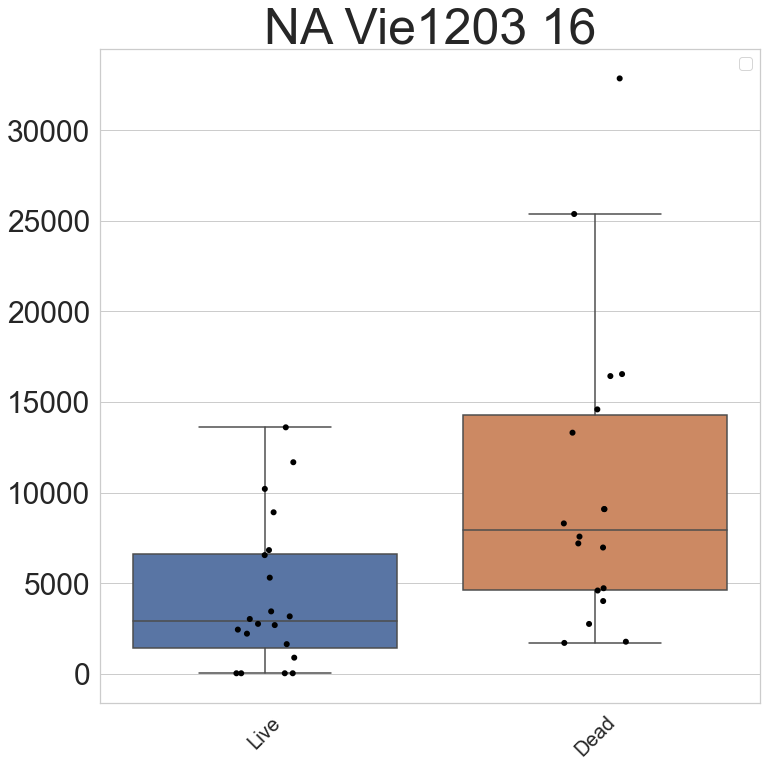

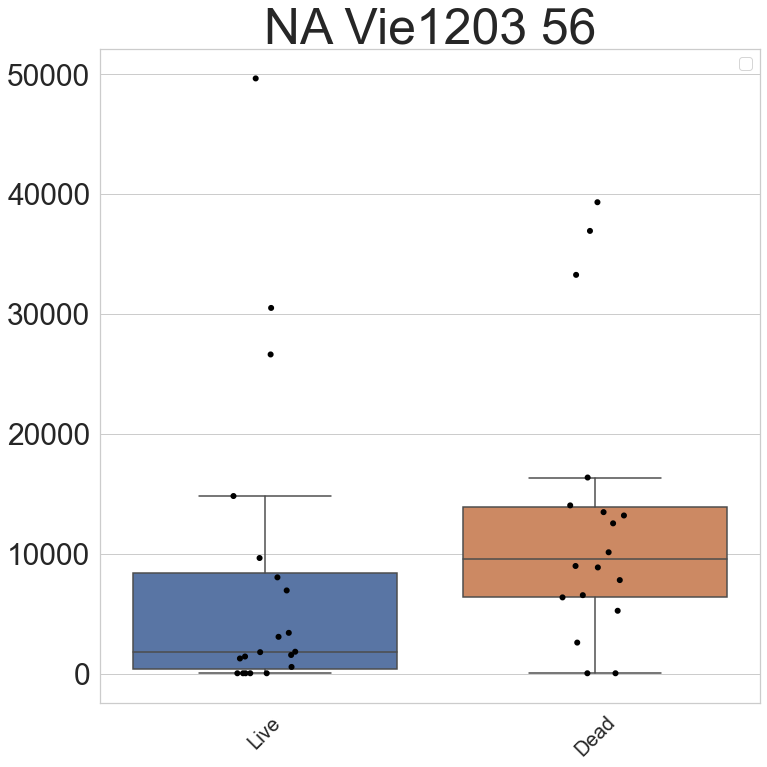

In [298]:
# analyze single antigens:
all_sig_antigens = {} # dictionary of all significant antigens across all comparisons
all_sig_antigens_df2 = pd.DataFrame(columns=['Antigen', 'Fisher Counts', 'p-value', 'adjusted p-value', 'q-value', 'isotype', 'group_names'])
plot_flag = True
if isotype_name[0] == 'IgM':
    pos_threshold = 4000# selected_threshold # threshold to define a positive response. Set high at this point due to high serum dilution used.
elif isotype_name[0] == 'IgG':
    pos_threshold = 2000# selected_threshold # threshold to define a positive response. Set high at this point due to high serum dilution used.

filter_threshold = 0.3 # precent responders threshold over the entire label-blinded cohort
reject_criteria = 'fdr' # criteria to adjust p-values by. can be 'fdr' (default), or 'bonferonni' (more restrictive)
fdr_threshold = 0.2

#group_names =curr_exp_groups

filter_dict = amutils.compute_label_blinded_antigen_filters(arr_df, ind_dict, 
                                                                    filter_threshold=filter_threshold, pos_threshold=pos_threshold)

for group_names in [ ('Live', 'Dead')]:
    
    curr_inds = group_inds_survival_ip[group_names[0]].append(group_inds_survival_ip[group_names[1]])

    #filter antigens based on percent responders on post responses only:

    for k, antigens in filter_dict.items():
        print('Number of peptides remaining for comparisons after blinded filtering for {0} is {1}'.format(k, len(antigens)))
        
    print('\n')
    # significant_antigens = {}
    # significant_antigen_stats = {}

    significant_antigens, significant_antigen_stats, sig_antigen_lists = \
        amutils.compare_single_antigens_by_groups(arr_df=arr_df.loc[curr_inds], group_names = group_names, antigen_filters=filter_dict,
                                                        pos_threshold=pos_threshold, group_column='survival_group', reject_criteria=reject_criteria,
                                                        fdr_threshold=fdr_threshold)  
    # save all sig antigen names:
    all_sig_antigens[group_names] = sig_antigen_lists
    # now generate dataframes for sig antigens from proteins of interest:
    if FIG_PATH is not None:
        sig_antigens_filename= "".join([FIG_PATH, project_name, isotype_name[0], 'peptide_sig_antigen_stats_', group_names[0], '_vs_', group_names[1], '_th_', str(pos_threshold), '_filter_th_', str(filter_threshold), '.xlsx']) 
        writer = pd.ExcelWriter(sig_antigens_filename)
    for p, p_name in zip(prot_names, prot_strs):
        sig_antigens_df = pd.DataFrame(significant_antigens[p], columns=['Antigen', 'Fisher Counts', 'p-value', 'adjusted p-value', 'q-value'])
        if not sig_antigens_df.empty:
            sig_antigens_df.loc[:, 'isotype'] = isotype_name[0]
            sig_antigens_df.loc[:, 'group_names']= group_names[0] + ' vs. ' + group_names[1]
            all_sig_antigens_df2 = all_sig_antigens_df2.append(sig_antigens_df)

        print('Results for comparisons of group {0} to group {1} for {2}'.format(group_names[0], group_names[1], p_name))
        print('-------------------------------------------------')
        display(sig_antigens_df)
        print('\n')
        if FIG_PATH is not None:
            sig_antigens_df.to_excel(writer, sheet_name=p_name)
    if FIG_PATH is not None:
        writer.save()
        
    # plot significant antigens
    if plot_flag:
        for prot in prot_names:
            curr_antigens = [a[0] for a in significant_antigens[prot]] 
            curr_antigen_names = [a.replace('_', ' ') for a in curr_antigens]
            # currently not working....
            # amp.plot_antigen_bar_plots_by_groups(arr_df=arr_df, antigens=curr_antigens, 
            #                                      group_names=exp_groups, 
            #                                      antigen_names=curr_antigen_names, fig_prefix=g + '_', fig_path=FIG_PATH)
            curr_groups = group_names
            # newer version of figure 4:
            sns.set(font_scale=1.5)
            amp.plot_antigen_boxplots_by_exp_groups(arr_df=arr_df.loc[curr_inds], antigens=curr_antigens,
                                                    antigen_names=dict(zip(curr_antigens,curr_antigen_names)),
                                                    order=curr_groups, exp_group_labels=curr_groups, group_column='survival_group',
                                                     fig_path=FIG_PATH, fig_prefix=isotype_name[0] + '_' + group_names[0] + '_vs_' + group_names[1] + '_')

### Export data to peptide list files for ML training (Liel):

In [299]:
if HA_flag:
    prot_name = 'HA'
else:
    prot_name = 'NA'
    
# filter_dict_filename = os.path.join(FIG_PATH, 'filtered_peptide_lists_{0}_{1}.xlsx'.format(prot_name, isotype_name[0])) 
# peptide_list = pd.Series()
# writer = pd.ExcelWriter(filter_dict_filename)
# for k, items in filter_dict.items():
#     peptide_list = peptide_list.append(pd.Series(items))
# peptide_list.to_excel(writer, sheet_name='selected_peptides')
# writer.save()
# writer.close()

all_sig_antigens_filename = os.path.join(FIG_PATH, 'sig_peptides_df', 'all_sig_peptides_Live_Dead_{0}_{1}.xlsx'.format(prot_name, isotype_name[0])) 
writer = pd.ExcelWriter(all_sig_antigens_filename)
all_sig_antigens_df2.to_excel(writer)    
writer.save()
writer.close()
print(all_sig_antigens_filename)

//132.72.92.166\HertzLab_NAS\ArrayData\Influenza\Rapa4/Figs_RAPA_survival_paper/sig_peptides_df\all_sig_peptides_Live_Dead_NA_IgM.xlsx


### plot significant antigens:

### Stat analysis and testing - starting with specific questions from Maureen

In [ ]:
all_sig_antigens_df